# Fall 2024 Final Project (OPIM 5512 and 5509)
**Dr. Dave Wanik - Dept. of Operations and Information Management - University of Connecticut**

* Group Number: 13
* Names of Groups Members: PJ Watson 2887247

By submitting this project, I accept responsibility for my role in ensuring the integrity of the work submitted.

# Problem Definition

Overview: Can we predict the level of problematic internet usage exhibited by children and adolescents, based on their physical activity? The goal of this "Child Mind Institute — Problematic Internet Use" competition is to develop a predictive model that analyzes children's physical activity and fitness data to identify early signs of problematic internet use. Identifying these patterns can help trigger interventions to encourage healthier digital habits.

The Healthy Brain Network (HBN) dataset is a clinical sample of about five-thousand 5-22 year-olds who have undergone both clinical and research screenings. The objective of the HBN study is to find biological markers that will improve the diagnosis and treatment of mental health and learning disorders from an objective biological perspective. Two elements of this study are being used for this competition: physical activity data (wrist-worn accelerometer data, fitness assessments and questionnaires) and internet usage behavior data. The goal of this competition is to predict from this data a participant's Severity Impairment Index (sii), a standard measure of problematic internet use.

Competition: https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview

💚 Approach

1. Read and unzip data files (demographic, acclerometer, mean accelerometer).
2. Drive the join of the demographic and accelerometer files by whether there is
accelerometer data, reducing the demographic file significantly.
2. Visualize data and perform initial EDA.

  a. Continue to reduce demographic and accelerometer features as feasible.

3. Prepare data for modeling.
4. Run and evaluate models. Consider baseline models with demographic and/or accelerometer data only.
5. Discuss results and make recommendations.


Please note that some code (e.g. labeled Housekeeping) may be for my documentation/later use. I approach these notebooks as docs I may want to return to later and assume I will have forgotten why I coded whatever, thus the comments.

# Set Up Environment

In [72]:
!pip install tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, GRU, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

import os, re
import pyarrow.parquet as pq

!pip install tsfresh
!pip install dask[complete]
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters,ComprehensiveFCParameters



import dask.dataframe as dd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
# Count the number of cores in a computer for parallel processing if needed
cores = multiprocessing.cpu_count()
cores
# 8 cores

8

# Read Data

The competition data is compiled into two sources, parquet files containing the accelerometer (actigraphy) series and csv files containing the remaining tabular data. The majority of measures are missing for most participants.

https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data


## Data Dictionary

For documentation:

**The target Severity Impairment Index 'sii' for this competition is derived from the field PCIAT-PCIAT_Total as described in the data dictionary: 0 for None, 1 for Mild, 2 for Moderate, and 3 for Severe**.

**Healthy Brain Network (HBN) Instruments**
The tabular data in train.csv and test.csv comprises measurements from a variety of instruments. The fields within each instrument are described in data_dictionary.csv. These instruments are:

    Demographics - Information about age and sex of participants.
    Internet Use - Number of hours of using computer/internet per day.
    Children's Global Assessment Scale - Numeric scale used by mental health clinicians to rate the general functioning of youths under the age of 18.
    Physical Measures - Collection of blood pressure, heart rate, height, weight and waist, and hip measurements.
    FitnessGram Vitals and Treadmill - Measurements of cardiovascular fitness assessed using the NHANES treadmill protocol.
    FitnessGram Child - Health related physical fitness assessment measuring five different parameters including aerobic capacity, muscular strength, muscular endurance, flexibility, and body composition.
    Bio-electric Impedance Analysis - Measure of key body composition elements, including BMI, fat, muscle, and water content.
    Physical Activity Questionnaire - Information about children's participation in vigorous activities over the last 7 days.
    Sleep Disturbance Scale - Scale to categorize sleep disorders in children.
    Actigraphy - Objective measure of ecological physical activity through a research-grade biotracker.
    Parent-Child Internet Addiction Test - 20-item scale that measures characteristics and behaviors associated with compulsive use of the Internet including compulsivity, escapism, and dependency.

**Actigraphy Files and Field Descriptions**
During their participation in the HBN study, some participants were given an accelerometer to wear for up to 30 days continually while at home and going about their regular daily lives.

series_{train|test}.parquet/id={id} - Series to be used as training data, partitioned by id. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

    id - The patient identifier corresponding to the id field in train/test.csv.
    step - An integer timestep for each observation within a series.
    X, Y, Z - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.
    enmo - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero.
    Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.
    anglez - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.
    non-wear_flag - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.
    light - Measure of ambient light in lux. See ​​here for details.
    battery_voltage - A measure of the battery voltage in mV.
    time_of_day - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.
    weekday - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.
    quarter - The quarter of the year, an integer from 1 to 4.
    relative_date_PCIAT - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/data

## Load Files

* Load and unzip, then save to MyDrive for subsequent runs:  
  * the Kaggle competition demographic csv and accelerometer parquet files
  * DrD's X/y/train/test _F24_withID files for identifying which 996 id's to process
  * DrD's feature files were uploaded to MyDrive
        MinFC_Results: These were generated for ALL time steps, but a small subset of features.
        SomeFC_Results: Contains SOME (a subset) of the efficient FC parameters on the downsampled data
        EfficientFC_Results: Note I was only able to process 995/996 files using a two min timeout and downsampling.
        You can fill the missing row with 0s or try to tweak the code to get the result.
* Inspect directory to confirm correct files were loaded before proceeding to EDA

In [74]:
# The first time you run this code, use !gdown to read data
# https://drive.google.com/file/d/1VDsNmh0KZSzcrNBapRT31xnYqtVUOmIO/view?usp=sharing
#!gdown 1VDsNmh0KZSzcrNBapRT31xnYqtVUOmIO
# 1 min download Colab Pro+ T4 High-RAM

In [75]:
# The first time you run this code, unzip the file, pointing to the desired directory on MyDrive
# For subsequent runs, just mount drive

# Unzip Kaggle competition demographic and parquet files
#!unzip -o /content/child-mind-institute-problematic-internet-use.zip -d /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project

# Unzip DrD's parquet mean value files
#!unzip /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/F24_DS_DL_finalProject_data.zip -d /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/

In [76]:
# Check work, click on "Files" and navigate to correct folder to inspect
# path below
dir_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project'

# List all files and directories within the specified path
file_list = os.listdir(dir_path)
for file_name in file_list:
  print(file_name)

sample_submission.csv
.ipynb_checkpoints
series_test.parquet
series_train.parquet
data_dictionary.csv
test.csv
train.csv
y_train_F24_withID.csv
y_test_F24_withID.csv
X_train_F24_withID.csv
X_test_F24_withID.csv
series_train_output.csv
top_TSF_features.csv
MinFC_Results
SomeFC_Results
EfficientFC_Results
Combined_dfs
X_train_no_PCIAT.csv
y_train_no_PCIAT.csv
X_test_no_PCIAT.csv
y_test_no_PCIAT.csv
X_train_MinFC_combined.csv
y_train_MinFC_combined.csv
X_test_MinFC_combined.csv
y_test_MinFC_combined.csv
Downsampling
Downsampling_Results
Downsampling_Results.csv
combined_df_downsample.csv


In [77]:
# Set display options to show all rows and columns if desired
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.width", None)

In [78]:
# Read data_dictionary.csv to have as documentation and help in feature reduction
data_dictionary = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/data_dictionary.csv')
# Display data_dictionary
data_dictionary

Instrument                                   Field  \
0                                      Identifier                                      id   
1                                    Demographics               Basic_Demos-Enroll_Season   
2                                    Demographics                         Basic_Demos-Age   
3                                    Demographics                         Basic_Demos-Sex   
4              Children's Global Assessment Scale                             CGAS-Season   
5              Children's Global Assessment Scale                         CGAS-CGAS_Score   
6                               Physical Measures                         Physical-Season   
7                               Physical Measures                            Physical-BMI   
8                               Physical Measures                         Physical-Height   
9                               Physical Measures                         Physical-Weight   
10                              Physical Measures            Physical-Waist_Circumference   
11                              Physical Measures                   Physical-Diastolic_BP   
12                              Physical Measures                      Physical-HeartRate   
13                              Physical Measures                    Physical-Systolic_BP   
14               FitnessGram Vitals and Treadmill                Fitness_Endurance-Season   
15               FitnessGram Vitals and Treadmill             Fitness_Endurance-Max_Stage   
16               FitnessGram Vitals and Treadmill             Fitness_Endurance-Time_Mins   
17               FitnessGram Vitals and Treadmill              Fitness_Endurance-Time_Sec   
18                              FitnessGram Child                              FGC-Season   
19                              FitnessGram Child                              FGC-FGC_CU   
20                              FitnessGram Child                         FGC-FGC_CU_Zone   
21                              FitnessGram Child                            FGC-FGC_GSND   
22                              FitnessGram Child                       FGC-FGC_GSND_Zone   
23                              FitnessGram Child                             FGC-FGC_GSD   
24                              FitnessGram Child                        FGC-FGC_GSD_Zone   
25                              FitnessGram Child                              FGC-FGC_PU   
26                              FitnessGram Child                         FGC-FGC_PU_Zone   
27                              FitnessGram Child                             FGC-FGC_SRL   
28                              FitnessGram Child                        FGC-FGC_SRL_Zone   
29                              FitnessGram Child                             FGC-FGC_SRR   
30                              FitnessGram Child                        FGC-FGC_SRR_Zone   
31                              FitnessGram Child                              FGC-FGC_TL   
32                              FitnessGram Child                         FGC-FGC_TL_Zone   
33                Bio-electric Impedance Analysis                              BIA-Season   
34                Bio-electric Impedance Analysis              BIA-BIA_Activity_Level_num   
35                Bio-electric Impedance Analysis                             BIA-BIA_BMC   
36                Bio-electric Impedance Analysis                             BIA-BIA_BMI   
37                Bio-electric Impedance Analysis                             BIA-BIA_BMR   
38                Bio-electric Impedance Analysis                             BIA-BIA_DEE   
39                Bio-electric Impedance Analysis                             BIA-BIA_ECW   
40                Bio-electric Impedance Analysis                             BIA-BIA_FFM   
41                Bio-electric Impedance Analysis                            BIA-BIA_FFMI   
42                Bio-electric Impedance

# EDA: Approach and Initial File Inspection

EDA, data cleaning and feature engineering:

* `X_train`, `X_test`, `y_train`, and `y_test` have been provided to all students.

    * Modified 11/13/24 to

        'X_train_F24_withID'

        'X_test_F24_withID',

        'y-train_F24_withID',

        'y_test_Fw24_withID'
        
        for the purposes of knowing which id's to use.
        WE ARE FOCUSING ON TRAIN.DF

* We only should model the 996 observations that have a corresponding parquet file (so that you can do some modeling with corresponding data.) If any parquet is empty or only has a few observations, you can use fillna() or some other method without data leakage to impute.

💚 Approach
1. Examine demographic csv files train_df (and test_df for reference); accelerometer parquet files; and mean accelerator files (provided by DrD for id's).
2. Use list of mean accelerometer data 'id's to reduce train_df to only rows with acclerator data.
3. Recode rows with 'sii' such that any value >= 1.0 == 1.0.
4. Reduce train_df features where possible based on feature analysis and dictionary review.
5. Join train_df with its corresponding accelerometer data before spliting out to 80/20 files for modeling based on the XXX_F24_withID files (the X/y/train/test files)
6. Keep tabs on row and column counts - X_train should be 796 rows and X_test should be 200 rows.


## Inspect Demographic Data, Acclerometer Parquet Files and Mean Accelerator Data (provided by DrD, _F24_withID files)

### Inspect train_df (3960, 82) (and test_df (20, 59) for reference).

In [79]:
# Load, inspect train.csv demographic file
train_df = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/train.csv')
print("\n This is the shape of train_df: \n", train_df.shape)
print("\n This is head of train_df sorted by id: \n", train_df.sort_values('id').head(10))

# (3960, 82)


 This is the shape of train_df: 
 (3960, 82)

 This is head of train_df sorted by id: 
          id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex CGAS-Season  \
0  00008ff9                      Fall                5                0      Winter   
1  000fd460                    Summer                9                0         NaN   
2  00105258                    Summer               10                1        Fall   
3  00115b9f                    Winter                9                0        Fall   
4  0016bb22                    Spring               18                1      Summer   
5  001f3379                    Spring               13                1      Winter   
6  0038ba98                      Fall               10                0         NaN   
7  0068a485                      Fall               10                1         NaN   
8  0069fbed                    Summer               15                0         NaN   
9  0083e397                    Summer    

In [80]:
train_df.info()
# 3960 rows, 82 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [81]:
# Load, inspect test.csv demographic file # DD SAYS DONT NEED
test_df = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/test.csv')
print("This is head of test_df sorted by id: \n", test_df.sort_values('id').head(10))
print("\n This is the tail of test_df sorted by id: \n", test_df.sort_values('id').tail(10))
print("\n This is the shape of test_df: \n", test_df.shape)
# (20, 59) which we know is light from the competition documentation
# BUT WHY ONLY 59 cols compared to train_df? What does it tell us?

This is head of test_df sorted by id: 
          id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex CGAS-Season  \
0  00008ff9                      Fall                5                0      Winter   
1  000fd460                    Summer                9                0         NaN   
2  00105258                    Summer               10                1        Fall   
3  00115b9f                    Winter                9                0        Fall   
4  0016bb22                    Spring               18                1      Summer   
5  001f3379                    Spring               13                1      Winter   
6  0038ba98                      Fall               10                0         NaN   
7  0068a485                      Fall               10                1         NaN   
8  0069fbed                    Summer               15                0         NaN   
9  0083e397                    Summer               19                1      Summer   

  

In [82]:
test_df.info()
# 20 row, ONLY 59 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


#### Examine train_df vs test_df Column Discrepancy

Examine why test_df (59 cols) is smaller than train_df (82 cols).
We expect the target variable 'sii' to be absent from test_df,
but why are other columns absent?

In test_df, the columns removed are:
  * 22 Parent-Child Internet Addiction Test (PCIAT) columns
    * including 'PCIAT-Season' and 'PCIAT-PCIAT_Total'
  * target var 'sii'

train_df = 82 columns

test_df  = 82 columns - 22 PCIAT columns - target var 'sii' = 59 columns

💚 This is fine because the target var 'sii' is derived from the field PCIAT-PCIAT_Total as described in the data dictionary, which itself is derived from the individual PCIAT features. We will drop the PCIAT features from train_df later on.

In [83]:
# Examine why test_df has many fewer columns than train_df
# We expect the target variable 'sii' to be absent from test_df
# but why other cols?

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

print("Columns in train_df but not in test_df:", train_cols - test_cols)
print("Columns in test_df but not in train_df:", test_cols - train_cols)

# There are 22 PCIAT columns (including 'PCIAT-Season' and 'PCIAT-PCIAT_Total') + target var 'sii' = 23 columns
# not in test_df but in train_df
# 82 - 23 = 59

Columns in train_df but not in test_df: {'PCIAT-PCIAT_15', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_08', 'PCIAT-Season', 'sii', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_20'}
Columns in test_df but not in train_df: set()


#### Housekeeping: Demographic Column Names

In [84]:
# List train_df columns for easy copy/paste later if needed
train_df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season',
       'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
       'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
    

### Inspect series_train.parquet

Parquet files will vary depending on the number of time series observations' but their number of columns is 13.

Let's look at the 1st series_train.parquet file (is = 00115b9f) to get familiar with parquet files.


In [85]:
# Inspect the first train series_train.parquet file
# This is 'id' = 00115b9f
# Look at series_train.parquet metadata

train_file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=00115b9f/part-0.parquet'
train_parquet_file_sample = pq.ParquetFile(train_file_path)
train_parquet_file_sample.metadata

# Metadata explanation
#   created_by: Polars: This tells you that the Parquet file was created using the Polars library.
#   num_columns: 13: Your Parquet file contains 13 columns.
#   num_rows: 43330: There are 43,330 rows in the data.
#   num_row_groups: 1: The file has a single row group.
#       Row groups are a way to divide a Parquet file into smaller chunks for efficient reading.
#   format_version: 1.0: This indicates the version of the Parquet format used to create the file.
#   serialized_size: 2574: The size (in bytes) of the serialized metadata footer.

  created_by: Polars
  num_columns: 13
  num_rows: 43330
  num_row_groups: 1
  format_version: 1.0
  serialized_size: 2574

In [86]:
# Get familiar with a train parquet file
# Inspect rows for 'id' = 00115b9f

# Read parquet file into df
df = pd.read_parquet(train_file_path, engine='pyarrow')  # or engine='fastparquet'
print('\n This is the shape of series_train.parquet for 00115b9f \n', df.shape)
print('\n This is the head of series_train.parquet for 00115b9f \n', df.head(10))

#(43330, 13)


 This is the shape of series_train.parquet for 00115b9f 
 (43330, 13)

 This is the head of series_train.parquet for 00115b9f 
    step         X         Y         Z      enmo     anglez  non-wear_flag      light  \
0     0  0.021536  0.022214 -1.022370  0.022853 -88.280762            0.0  53.000000   
1     1  0.022005  0.022187 -1.019740  0.020231 -88.241707            0.0  51.666668   
2     2  0.022240  0.022005 -1.019401  0.019893 -88.170067            0.0  50.333332   
3     3  0.021589  0.022578 -1.018177  0.018667 -88.250031            0.0  50.500000   
4     4  0.022005  0.023763 -1.014323  0.016848 -88.130775            0.0  33.166668   
5     5  0.023281  0.025156 -1.015599  0.016680 -88.130775            0.0  31.333334   
6     6  0.024818  0.027109 -1.015781  0.017497 -88.130775            0.0  29.500000   
7     7  0.022578  0.024766 -1.015026  0.015589 -88.141670            0.0  27.666666   
8     8  0.022318  0.024792 -1.015990  0.016576 -88.130775            0.0  25.8

#### Housekeeping: Parquet Column Names

step, X, Y, Z, enmo, anglez, non-wear_flag, light, battery_voltage, time_of_day, weekday, quarter, relative_date_PCIAT

In [87]:
# Extract series_train.parquet column names if needed later
# Get schema which contains columns
schema = train_parquet_file_sample.schema

# Extract column names
column_names = schema.names

# Print the column names
print("Column names in series_train.parquet:")
for name in column_names:
    print(name)

Column names in series_train.parquet:
step
X
Y
Z
enmo
anglez
non-wear_flag
light
battery_voltage
time_of_day
weekday
quarter
relative_date_PCIAT


### Inspect  _F24_withID Mean Accelerometer Files
    X_train_F24_withID (796, 15)
    y_train_F24_withID (796, 2)
    X_test_F24_withID  (200, 15)
    y_test_F24_withID  (200, 2)

Inspect X_train_F24_withID, y_train_F24_withID, X_test_F24_withID, y_test_F24_withID datasets provided by DrD. These are the mean values of the parquet files, per identifier 'id'. These datasets will be used to identify the demographic and accelerator records to be split into X/y/train/test based on 'id'; consider using the mean data for modeling.


In [88]:
_# Load X_train_F24_withID mean accelerometer data
X_train_F24_withID = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_F24_withID.csv')
print("\nThis is the shape of X_train_F24_withID: \n", X_train_F24_withID.shape)
print("\nThis is the head of X_train_F24_withID: \n", X_train_F24_withID.head(10))

# (796, 15)



This is the shape of X_train_F24_withID: 
 (796, 15)

This is the head of X_train_F24_withID: 
          id      step         X         Y         Z      enmo     anglez  non-wear_flag  \
0  a0522c83  200315.5 -0.505789 -0.069706  0.013336  0.025508   1.611984       0.031900   
1  4a4a0f78  190155.5  0.121610  0.032871  0.152650  0.034276  10.249540       0.000000   
2  a8b0428d     692.5 -0.275158  0.259596  0.317515  0.029915  20.623983       0.000000   
3  6282e693   68514.0 -0.256388 -0.066792 -0.174034  0.086394 -12.297556       0.000000   
4  a4530b41  203633.5  0.016842 -0.047838  0.140291  0.047017   8.838480       0.048070   
5  994ee014  201503.5 -0.074303 -0.196612 -0.669580  0.004133 -53.643944       0.612345   
6  ad536dea   82765.0  0.034705  0.013680  0.199181  0.123219  12.254392       0.000000   
7  66f619e3   96515.5  0.089066  0.015215  0.453564  0.026195  40.569038       0.704927   
8  48e69212  194315.5  0.027370 -0.044955 -0.122075  0.050251  -8.920275       0.031

In [89]:
X_train_F24_withID.info()
# 796 rows, 15 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   796 non-null    object 
 1   step                 796 non-null    float64
 2   X                    796 non-null    float64
 3   Y                    796 non-null    float64
 4   Z                    796 non-null    float64
 5   enmo                 796 non-null    float64
 6   anglez               796 non-null    float64
 7   non-wear_flag        796 non-null    float64
 8   light                796 non-null    float64
 9   battery_voltage      796 non-null    float64
 10  time_of_day          796 non-null    float64
 11  weekday              796 non-null    float64
 12  quarter              796 non-null    float64
 13  relative_date_PCIAT  796 non-null    float64
 14  sii                  0 non-null      float64
dtypes: float64(14), object(1)
memory usage: 

In [90]:
_# Load y_train_F24_withID mean accelerometer data
y_train_F24_withID = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_F24_withID.csv')
print("\nThis is the shape of y_train_F24_withID: \n", y_train_F24_withID.shape)
print("\nThis is the head of y_train_F24_withID: \n", y_train_F24_withID.head(10))

# (796, 2)



This is the shape of y_train_F24_withID: 
 (796, 2)

This is the head of y_train_F24_withID: 
          id  sii
0  a0522c83    1
1  4a4a0f78    1
2  a8b0428d    1
3  6282e693    0
4  a4530b41    0
5  994ee014    0
6  ad536dea    1
7  66f619e3    1
8  48e69212    0
9  0b7d9da6    0


In [91]:
y_train_F24_withID.info()
# 796 rows, 2 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      796 non-null    object
 1   sii     796 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


In [92]:
# Load X_test_F24_withID mean accelerometer data
X_test_F24_withID = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_F24_withID.csv')
print("\nThis is the shape of X_test_F24_withID: \n", X_test_F24_withID.shape)
print("\nThis is the head of X_test_F24_withID: \n", X_test_F24_withID.head(10))

# (200, 15)



This is the shape of X_test_F24_withID: 
 (200, 15)

This is the head of X_test_F24_withID: 
          id      step         X         Y         Z      enmo     anglez  non-wear_flag  \
0  d8037389  165125.5  0.143036 -0.181769 -0.181729  0.016326 -11.711159       0.527468   
1  fa34f945  201455.5  0.006469  0.181113  0.016930  0.005865   0.282131       0.655512   
2  15f2e240  103292.0  0.067980  0.048636 -0.043515  0.060265  -3.391100       0.000000   
3  98ed2153  207209.5 -0.018163  0.005685 -0.128748  0.025637 -10.272767       0.229767   
4  7187caec  204647.5 -0.013084 -0.121897 -0.086763  0.020461  -8.525217       0.429443   
5  3f1f23e7  197675.5  0.037991 -0.001074 -0.394080  0.042157 -32.632088       0.286833   
6  464a75fb  141550.0  0.076907 -0.005659  0.249862  0.042399  16.524336       0.000000   
7  26aeacdf   98913.0 -0.350450 -0.035766 -0.274072  0.093760 -18.782854       0.000000   
8  a9c53cdb  197879.5 -0.087888 -0.064451 -0.214804  0.048475 -15.489414       0.16781

In [93]:
X_test_F24_withID.info()
# 200 rows, 15 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   200 non-null    object 
 1   step                 200 non-null    float64
 2   X                    200 non-null    float64
 3   Y                    200 non-null    float64
 4   Z                    200 non-null    float64
 5   enmo                 200 non-null    float64
 6   anglez               200 non-null    float64
 7   non-wear_flag        200 non-null    float64
 8   light                200 non-null    float64
 9   battery_voltage      200 non-null    float64
 10  time_of_day          200 non-null    float64
 11  weekday              200 non-null    float64
 12  quarter              200 non-null    float64
 13  relative_date_PCIAT  200 non-null    float64
 14  sii                  0 non-null      float64
dtypes: float64(14), object(1)
memory usage: 

In [94]:
# Load y_test_F24_withID mean accelerometer data
y_test_F24_withID = pd.read_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_F24_withID.csv')
print("\nThis is the shape of y_test_F24_withID: \n", y_test_F24_withID.shape)
print("\nThis is the head of y_test_F24_withID: \n", y_test_F24_withID.head(10))

(200, 2)



This is the shape of y_test_F24_withID: 
 (200, 2)

This is the head of y_test_F24_withID: 
          id  sii
0  d8037389    1
1  fa34f945    1
2  15f2e240    0
3  98ed2153    1
4  7187caec    1
5  3f1f23e7    1
6  464a75fb    1
7  26aeacdf    0
8  a9c53cdb    1
9  93fda84a    0


(200, 2)

In [95]:
y_test_F24_withID.info()
# (200, 2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      200 non-null    object
 1   sii     200 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


# EDA: Demographic Data Reduction

💚 Approach

1. Refresh: At this point, train_df shape is (3960, 82) (and test_df shape is (20,59) for reference).
2. Drop PCIAT columns from train_df. Target variable is *derived from PCIAT columns.
3. Housekeeping: Examine (and clean if needed) key field 'id' before joining demographic and mean acclerometer datasets.
4. Reduce demographic dataset based on the presence of accelerometer data, reducing demographic dataset to only rows with accelerometer data.
5. Perform EDA to reduce features for further analysis and modeling.

In [96]:
# Refresh train_df
train_df.shape
# (3960, 82) as expected

(3960, 82)

In [97]:
# Refresh test_df
test_df.shape
# (20,59) as expected


(20, 59)

## Drop PCIAT Columns From train_df (3960, 60)


Our target var 'sii' is derived from PCIAT-PCIAT_Total, which itself is derived from the subsidiary PCIAT vars.

💚 Approach
1. Start with dropping the PCIAT columns from train_df.
2. Analyze train_df to determine features to drop *BEFORE using the _F24_withID datasets to perform the 80/20 split based on the respective _F24_withID files' 'id' field. This is so the columns are dropped in one place (train_df) rather than needing to drop the columns four times in in four datasets (X/y/train/test).

In [98]:
# Recall from 'Examine train_df vs test_df Column Discrepancy' section:

# "Columns in train_df but not in test_df:"

 # {'PCIAT-PCIAT_01', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_09',
 # 'sii', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_18',
 # 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_19', 'PCIAT-Season', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_03',
 # 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_04'}

# These vars will become our .drop (columns =)


In [99]:
# Drop train_df PCIAT columns
# Wrap the drop operation in a try-except block to check for KeyError,
# which would indicate that some of the specified columns aren’t in train_df.
try:
    train_df.drop(columns=[
        'PCIAT-Season', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04',
        'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09',
        'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14',
        'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19',
        'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total'
    ], inplace=True)
    print("Drop successful.")
except KeyError as e:
    print("KeyError: Some columns were not found in train_df:", e)

# Print shape and remaining columns to verify the drop
print("train_df shape after dropping PCIAT columns:", train_df.shape)
print("Remaining columns:", train_df.columns)

# (3960,60)

Drop successful.
train_df shape after dropping PCIAT columns: (3960, 60)
Remaining columns: Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season',
       'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate',
       'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',


In [100]:
# Another way to check if test_df and train_dfhave have any features differences

train_cols = set(train_df.columns)
test_cols = set(test_df.columns)

print("Columns in train_df but not in test_df:", train_cols - test_cols)
print("Columns in test_df but not in train_df:", test_cols - train_cols)
# 'sii' as expected based on initial data

Columns in train_df but not in test_df: {'sii'}
Columns in test_df but not in train_df: set()


## Housekeeping: Examine Key Join Field 'id'

Before we go too far, and because the 'id' variable is the key to the demographic, acclerator and mean accelerator files, let's examine 'id' and clean if needed. Check for any values that are not 8 characters (numeric and alpha) using module re, sort ascending and visually inspect. We need to check 'id' in train_df as well as the (4) X/y/train/test_F24withID files. 'id' should be good in all files based on DrD's 80/20 split, but let's just check before going any further.

What is re?

Re is Python's built-in module for working with regular expressions.
Regular expressions, or "regex," are a powerful tool for matching patterns
within strings, useful for tasks like searching, validating, or extracting
specific text patterns.

💚 train_df, X_train_F24_withID, y_train_F24_withID, y_train_F24_withID, and y_test_F24_withID have valid 'id''s (alphas and numerics) .

In [101]:
# Check 'id' in combined_df, X_train_F24_withID, y_train_F24_withID,
# y_train_F24_withID, and y_test_F24_withID before joins

# Define the regular expression pattern for 8 alphanumeric characters
pattern = r'^[A-Za-z0-9]{8}$'

# Dfs to check
dataframes = {
    "train_df": train_df,
    "X_train_F24_withID": X_train_F24_withID,
    "y_train_withID": y_train_F24_withID,
    "y_train_F24_withID": y_train_F24_withID,
    "y_test_F24_withID": y_test_F24_withID
}

# Loop through each df, check 'id' values
for name, df in dataframes.items():
    # Find rows where 'id' does not match the 8-character alphanumeric pattern
    invalid_ids = df[~df['id'].astype(str).str.match(pattern)]

    # Print results if there are any invalid rows
    if not invalid_ids.empty:
        print(f"\nDataFrame: {name}")
        print("Rows with invalid 'id':")
        print(invalid_ids)

        # Print count of invalid rows
        invalid_count = len(invalid_ids)
        print(f"Count of rows with invalid 'id' in {name}: {invalid_count}")
    else:
        print(f"\nDataFrame: {name} has no invalid 'id' values.")



DataFrame: train_df has no invalid 'id' values.

DataFrame: X_train_F24_withID has no invalid 'id' values.

DataFrame: y_train_withID has no invalid 'id' values.

DataFrame: y_train_F24_withID has no invalid 'id' values.

DataFrame: y_test_F24_withID has no invalid 'id' values.


## Reduce Demographic Data Based on Presence of Accelerometer Data (996, 60)

Reduce train_df to only rows with accelerometer data (from the _F24_withID files), based on key field = 'id'.


In [102]:
# Extract unique 'id' values from each DataFrame
ids_from_X_train = set(X_train_F24_withID['id'])
ids_from_X_test = set(X_test_F24_withID['id'])
ids_from_y_train = set(y_train_F24_withID['id'])
ids_from_y_test = set(y_test_F24_withID['id'])

# Combine all unique 'id' values into one set
all_ids = ids_from_X_train | ids_from_X_test | ids_from_y_train | ids_from_y_test

# Filter combined_df to keep only rows with 'id' values in all_ids
train_df = train_df[train_df['id'].isin(all_ids)]

# Check the result
print("train_df shape after filtering for parquet id's:", train_df.shape)

# good shape (996,60)

train_df shape after filtering for parquet id's: (996, 60)


## EDA: Demographic Data Feature Reduction

### Demographic Data Analysis


💚 Approach

Examine train_df demographic data looking for patterns, correlations or other insights.

Refresh: train_df shape: (998, 60)

1. Look at summary statistics for train_df to determine additional fields to drop in initial analysis. We could loop through all the demographic variables, but I prefer to look at the subsets in case I want to refer to them later as a group.

  a. Look at subsets of data in more detail (frequency counts, distributions)
      - demographic/physical measures
      - fitness data
      - bioelectrical impedence data
      - physical activity
      - NOT parent child internet addiction data (redundant with 'sii', already removed because test_df had dropped this data)
      - sleep disturbance
      - internet use

2. Based on data subset observations, continue to reduce combined_df further before additional analysis and modeling.

3. Dataset combined_df_temp will be used for the reduced demographic data to keep combined_df...pristine.

💚 Observations
* Demographic/Physical Measures

  1. Season of study enrollment was relatively consistent throughout the year (prob not important)
  2. 6-12 year olds were abundant in the study
  3. 2:1 male:female
  4. Need to round body mass index (BMI) to make any sense of the data. Given that BMI is a calculation that measures body weight relative to height, weight and height are redundant features.
  5. Drop Physical-Waist_Circumference due to missing values

* Fitness Data

  1. Drop Fitness_Endurance-Max_Stage, Fitness_Endurance-Time_Mins, Fitness_Endurance-Time_Secs due to missing values
  2. Keep only the fitness assessment categorical variables (_Zone) which are derived from the various fitness tests to reduce features, with the exception of FGC-FGC_GSND_Zone and FGC-FGC_GSD_Zone which have over 2/3 of observations missing (685).

* Bioelectric Impedence Data (most fields need recoding)

  1.Round body mass index (BMI) to make any sense of the data. Redunant with Physical Measures BMI?
  2. Recode BIA-BIA_BMR, BIA-BIA_DEE, BIA-BIA_ECW, BIA-BIA_FFMI, BIA-BIA_ICW,
  'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM','BIA-BIA_TBW'
  3. Drop BIA-BIA_FFM
  4. Drop BIA-BIA_Fat

    Fat mass index (FMI)
    FMI is calculated by dividing body fat mass by height squared. It was first introduced in a 1990 study on nutritional assessment. One study suggests that FMI may be a better indicator of metabolic syndrome than BMI or body fat percentage.
    
    Body fat percentage
    Body fat percentage is calculated by dividing the total mass of fat by the total body mass, and then multiplying by 100. It includes both essential and storage body fat. Body fat percentage can provide insight into overall health and disease risk.

  5. Drop BIA-BIA_Frame_num

* Physical Activity Data

  1. Drop all fields

* Sleep Disturbance Data

  1. Given that a raw score for sleep disturbance is the total score calculated from a participant's responses to a survey, while a T-score is a standardized version of that raw score, drop 'SDS-SDS_Total_Raw'.

* Internet Use Data
  1. Keep PreInt_EduHx-computerinternet_hoursday

* Drop _Season variables (enrollment, etc).



#### Summary Statistics


In [103]:
# Summary statistics for combined_df
train_df.describe()

Basic_Demos-Age  Basic_Demos-Sex  CGAS-CGAS_Score  Physical-BMI  Physical-Height  \
count       996.000000       996.000000       954.000000    985.000000       988.000000   
mean         10.308233         0.346386        64.427673     19.289689        56.121488   
std           3.462414         0.476057        11.532040      5.041315         7.463518   
min           5.000000         0.000000        31.000000      0.000000        39.000000   
25%           8.000000         0.000000        55.250000     15.874194        50.500000   
50%          10.000000         0.000000        63.000000     17.881836        55.000000   
75%          12.000000         1.000000        72.000000     21.533192        62.000000   
max          21.000000         1.000000        95.000000     45.306026        78.000000   

       Physical-Weight  Physical-Waist_Circumference  Physical-Diastolic_BP  Physical-HeartRate  \
count       986.000000                     47.000000             979.000000          979.000000   
mean         90.886613                     25.106383              70.077630           81.980592   
std          43.458727                      5.957217              14.804593           13.849418   
min           0.000000                     19.000000              11.000000           27.000000   
25%          58.600000                     21.500000              61.000000           73.000000   
50%          78.600000                     23.000000              68.000000           81.000000   
75%         113.900000                     26.000000              76.000000           92.000000   
max         315.000000                     46.000000             179.000000          138.000000   

       Physical-Systolic_BP  Fitness_Endurance-Max_Stage  Fitness_Endurance-Time_Mins  \
count            979.000000                   299.000000                   298.000000   
mean             117.855975                     5.033445                     7.412752   
std               17.708983                     2.026391                     3.102205   
min               62.000000                     0.000000                     0.000000   
25%              107.000000                     4.000000                     6.000000   
50%              114.000000                     5.000000                     7.000000   
75%              126.000000                     6.000000                     9.000000   
max              203.000000                    26.000000                    20.000000   

       Fitness_Endurance-Time_Sec  FGC-FGC_CU  FGC-FGC_CU_Zone  FGC-FGC_GSND  FGC-FGC_GSND_Zone  \
count                  298.000000  698.000000       685.000000    315.000000         312.000000   
mean                    26.291946   11.530086         0.525547     21.672698           1.807692   
std                     17.150512   11.670258         0.499712      8.929616           0.611943   
min                      0.000000    0.000000         0.000000      0.000000           1.000000   
25%                     12.000000    4.000000         0.000000     15.500000           1.000000   
50%                     25.000000    9.000000         1.000000     19.200000           2.000000   
75%                     40.000000   15.000000         1.000000     25.850000           2.000000   
max                     59.000000  100.000000         1.000000     53.700000           3.000000   

       FGC-FGC_GSD  FGC-FGC_GSD_Zone  FGC-FGC_PU  FGC-FGC_PU_Zone  FGC-FGC_SRL  FGC-FGC_SRL_Zone  \
count   315.000000        312.000000  697.000000       684.000000   695.000000        682.000000   
mean     23.063778          1.891026    5.804878         0.346491     8.948993          0.653959   
std       9.249829          0.606224    7.312352         0.476200     3.197184          0.476056   
min       7.700000          1.000000    0.000000         0.000000     0.000000          0.000000   
25%      16.600000          2.000000    0.000000         0.000000     7.000000          0.000000   
5

#### Demographic and Physical Measures

Frequency Counts for Basic_Demos-Enroll_Season:
Basic_Demos-Enroll_Season
Spring    270
Fall      263
Summer    246
Winter    217
Name: count, dtype: int64



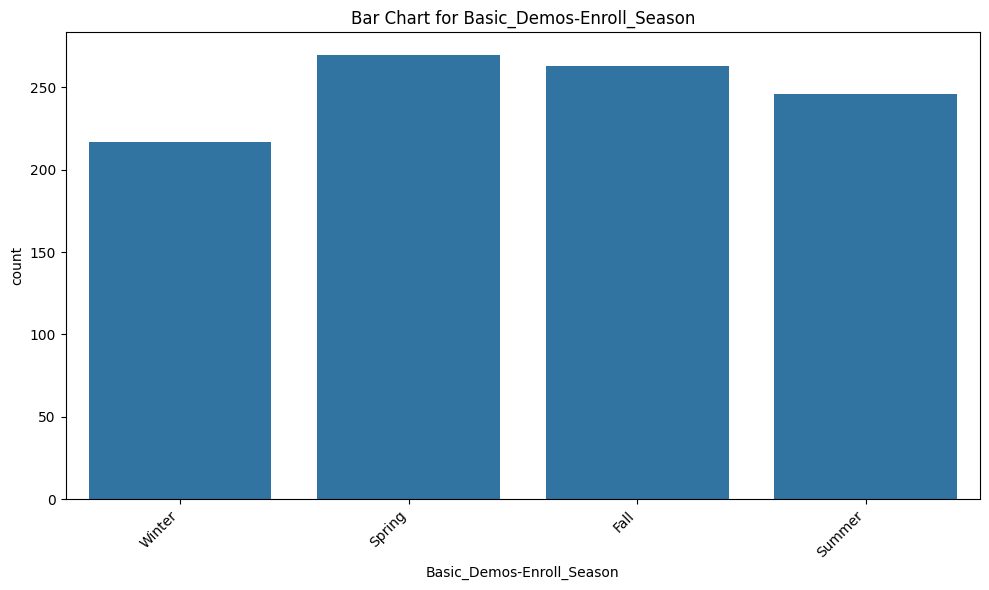

Frequency Counts for Basic_Demos-Age:
Basic_Demos-Age
9     135
8     121
10    110
7     105
6      98
12     84
11     70
14     55
13     51
15     44
16     31
17     30
5      28
18     17
19      7
20      5
21      5
Name: count, dtype: int64



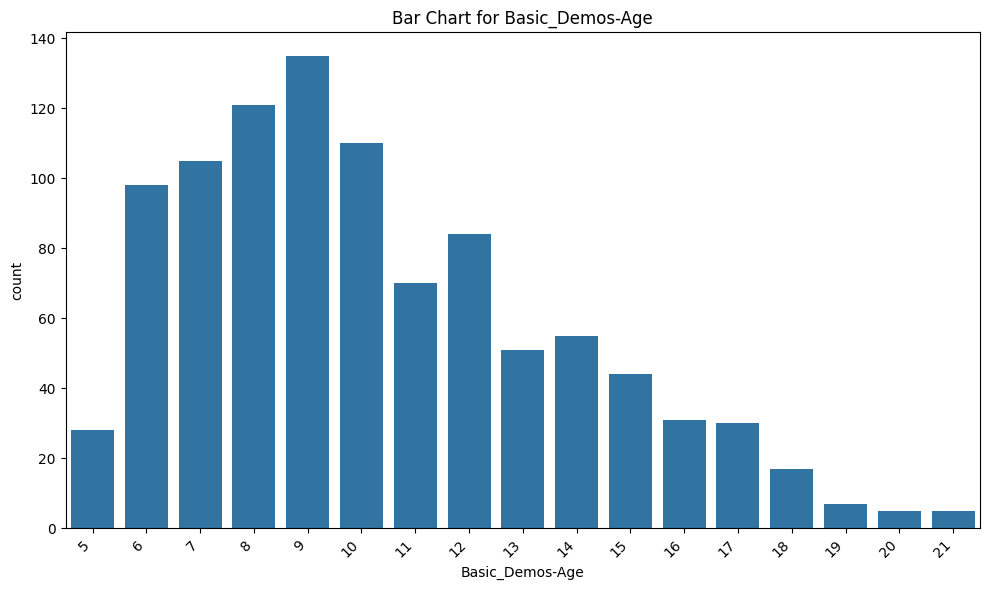

Frequency Counts for Basic_Demos-Sex:
Basic_Demos-Sex
0    651
1    345
Name: count, dtype: int64



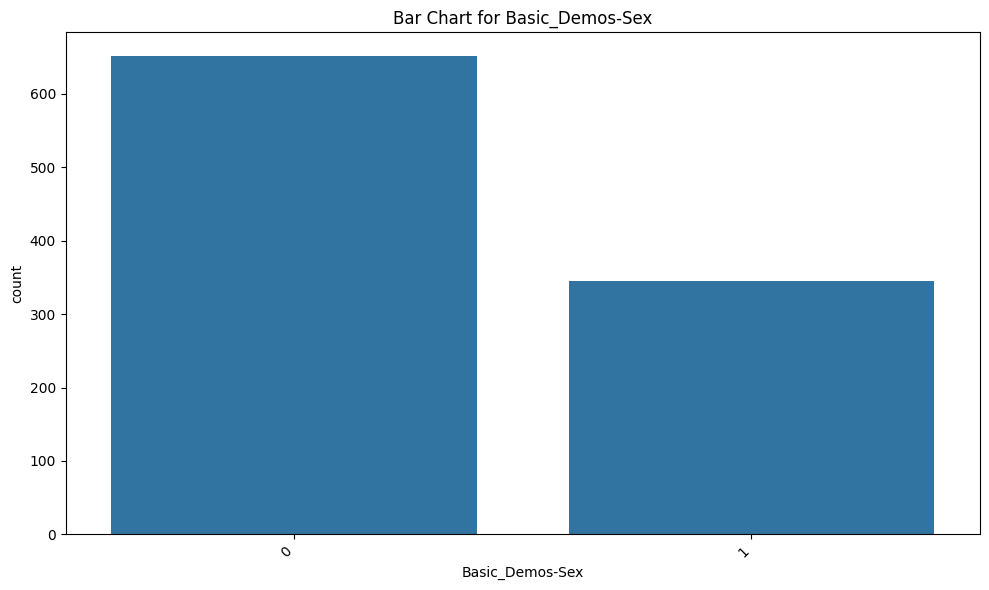

Frequency Counts for CGAS-Season:
CGAS-Season
Spring    311
Winter    259
Fall      204
Summer    180
Name: count, dtype: int64



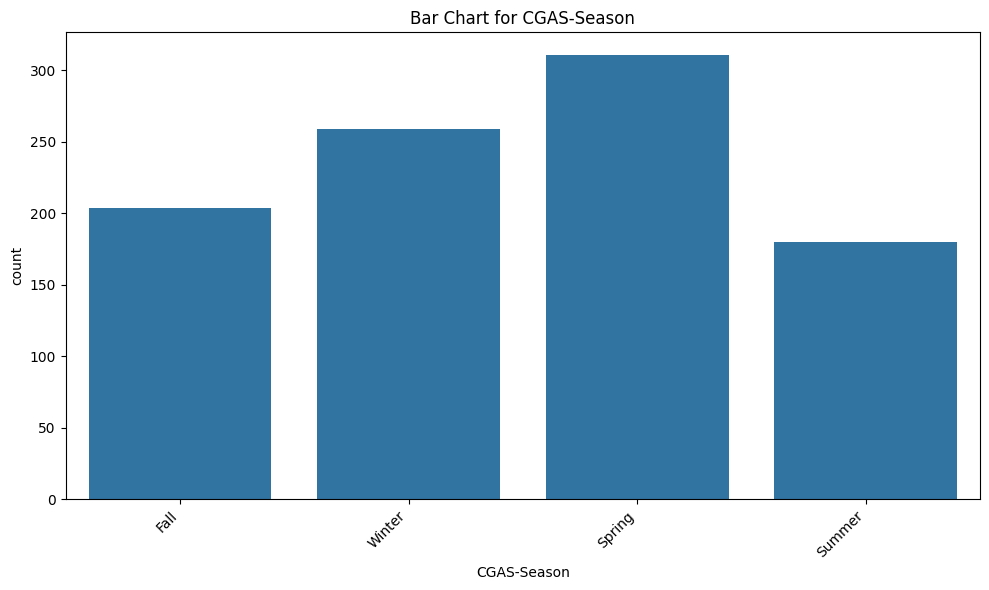

Frequency Counts for CGAS-CGAS_Score:
CGAS-CGAS_Score
60.0    138
55.0     90
65.0     85
80.0     75
70.0     74
61.0     54
75.0     50
50.0     47
45.0     40
85.0     37
51.0     20
63.0     19
71.0     17
62.0     16
68.0     16
78.0     13
41.0     13
58.0     12
90.0     12
67.0     11
59.0     10
81.0      9
40.0      9
72.0      9
82.0      7
66.0      7
64.0      6
77.0      6
74.0      6
53.0      5
69.0      5
91.0      4
79.0      4
73.0      3
47.0      3
57.0      3
54.0      3
52.0      2
49.0      2
48.0      2
31.0      2
87.0      2
92.0      1
95.0      1
42.0      1
88.0      1
56.0      1
83.0      1
Name: count, dtype: int64



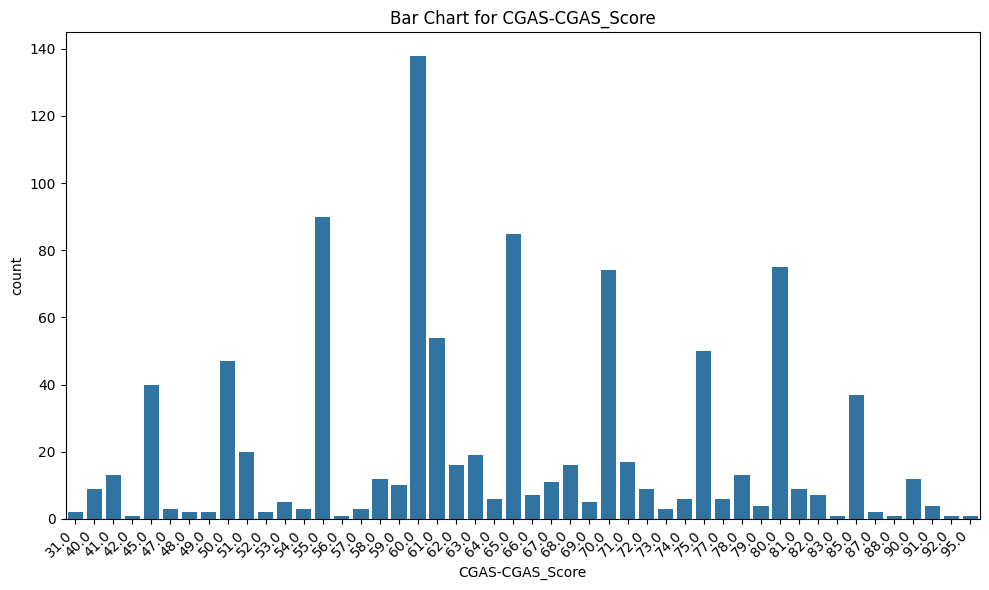

Frequency Counts for Physical-Season:
Physical-Season
Winter    273
Spring    248
Summer    240
Fall      231
Name: count, dtype: int64



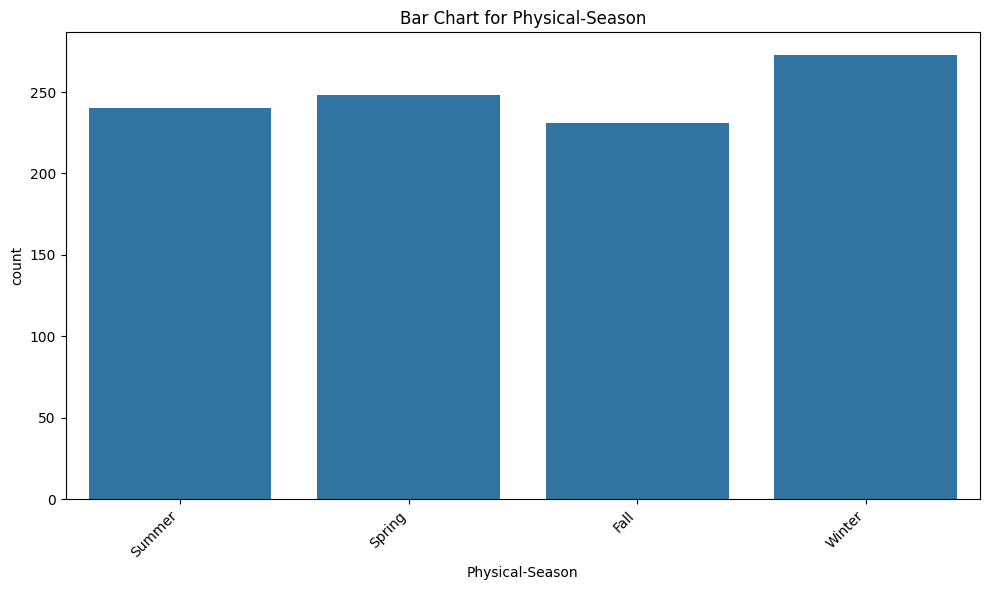

Frequency Counts for Physical-BMI:
Physical-BMI
16.110417    3
17.603120    3
18.023942    3
18.369598    2
16.249040    2
15.283882    2
14.000538    2
17.138225    2
17.264100    2
16.571139    2
17.358025    2
15.968632    2
13.891280    2
16.267769    2
14.002716    2
14.734880    2
15.855901    2
16.433064    2
15.622222    2
15.466000    2
14.418809    2
17.570840    2
16.267355    2
19.136484    2
18.900960    2
14.035590    2
15.663537    2
16.108727    2
15.988368    2
29.118343    2
19.009694    2
15.484507    2
14.819157    2
15.718656    2
22.279952    2
14.706104    2
16.675962    2
26.394084    1
16.905207    1
16.638316    1
18.081276    1
18.765155    1
16.239078    1
19.682207    1
29.588912    1
15.969383    1
23.502663    1
15.973722    1
16.700632    1
34.055363    1
19.986116    1
18.312859    1
21.533192    1
15.891994    1
22.348832    1
15.642884    1
15.602296    1
15.911523    1
17.743759    1
25.435693    1
16.943762    1
18.745089    1
27.543222    1
17.2776

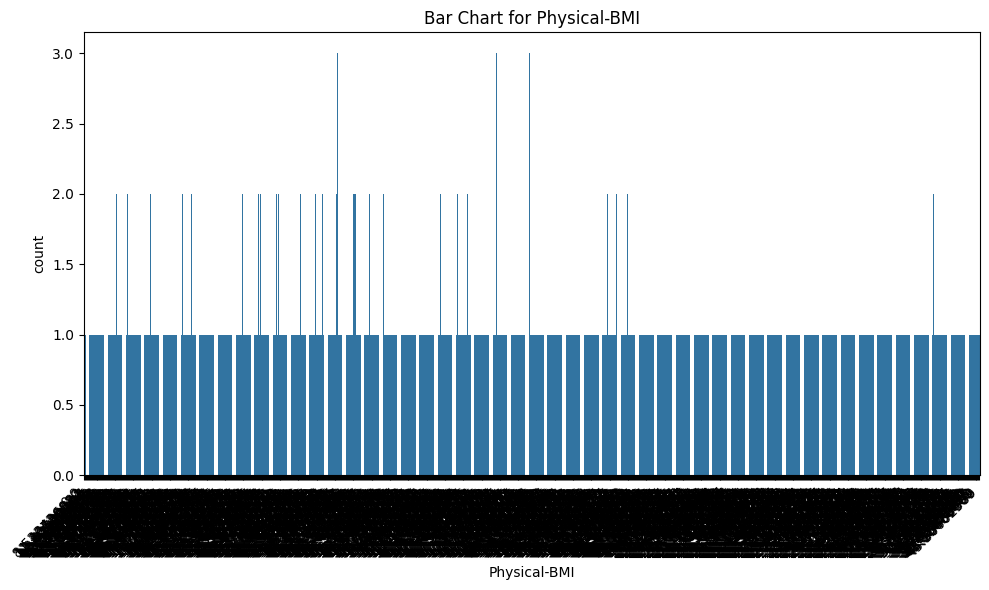

Frequency Counts for Physical-Height:
Physical-Height
54.00    42
48.00    30
55.00    28
51.00    27
50.00    26
49.00    24
53.00    24
57.00    24
56.00    23
62.00    23
52.00    22
61.00    21
63.00    20
65.00    19
45.00    19
60.00    18
51.50    17
64.00    16
55.50    16
58.00    16
46.00    15
56.50    15
53.50    14
50.50    14
59.00    14
52.50    13
45.50    13
67.00    12
66.00    11
47.00    11
54.50    11
57.50    11
47.50    10
58.50    10
68.00    10
65.50    10
60.50     9
64.50     8
43.00     8
63.50     8
69.00     8
44.00     8
49.50     7
68.50     7
51.75     7
61.50     7
46.50     7
48.50     6
66.50     6
50.25     6
67.50     5
70.50     5
60.75     5
70.00     5
59.50     5
48.25     5
47.25     4
71.00     4
56.25     4
53.25     4
65.25     4
64.25     3
62.50     3
64.13     3
42.50     3
64.75     3
41.50     3
63.75     3
57.75     3
52.25     3
43.50     3
73.00     3
68.75     3
62.75     3
69.50     3
49.90     2
65.40     2
47.40     2
74.00     

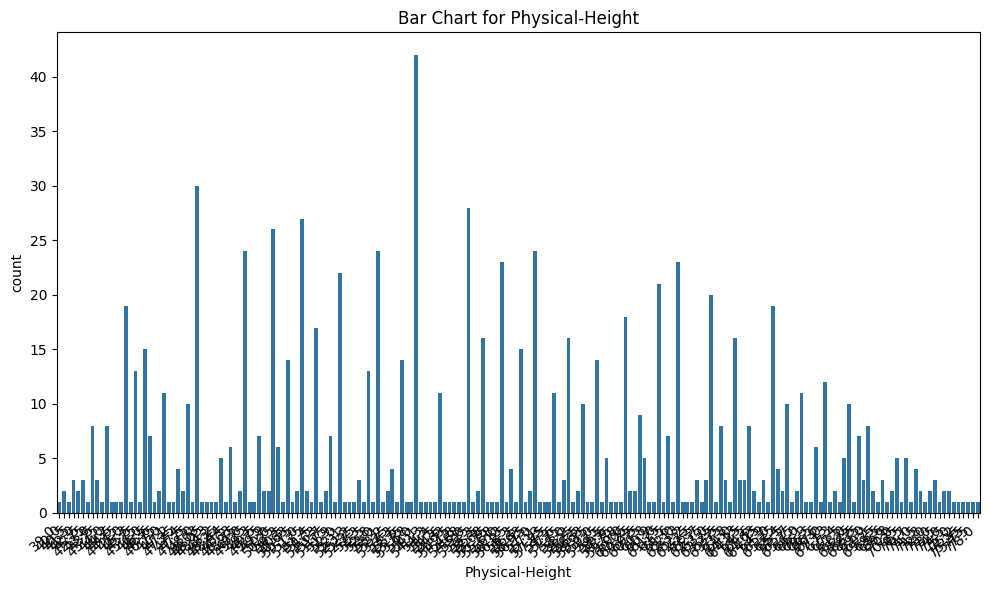

Frequency Counts for Physical-Weight:
Physical-Weight
46.0     8
56.0     7
75.8     6
62.6     6
48.8     6
52.4     6
64.0     6
65.0     6
65.4     5
58.0     5
61.0     5
62.4     5
57.6     5
56.2     5
52.2     5
44.0     5
63.0     5
59.8     5
67.4     5
60.8     5
75.6     5
49.4     5
50.6     5
56.8     5
114.2    5
91.0     5
57.0     5
59.0     4
52.8     4
58.6     4
64.8     4
47.6     4
74.2     4
50.2     4
117.4    4
105.6    4
64.6     4
60.6     4
73.4     4
69.6     4
94.6     4
72.2     4
79.0     4
51.8     4
83.6     4
54.6     4
73.8     4
84.0     4
55.0     4
63.2     4
108.0    4
47.4     4
85.6     4
46.8     4
96.0     4
49.2     4
64.4     4
108.6    3
38.6     3
69.4     3
72.4     3
84.8     3
101.0    3
69.0     3
81.2     3
68.4     3
81.4     3
43.4     3
95.0     3
80.4     3
124.2    3
55.2     3
92.4     3
49.6     3
67.6     3
121.0    3
89.0     3
68.2     3
114.8    3
71.0     3
71.2     3
51.2     3
118.0    3
112.2    3
45.6     3
133.0    3


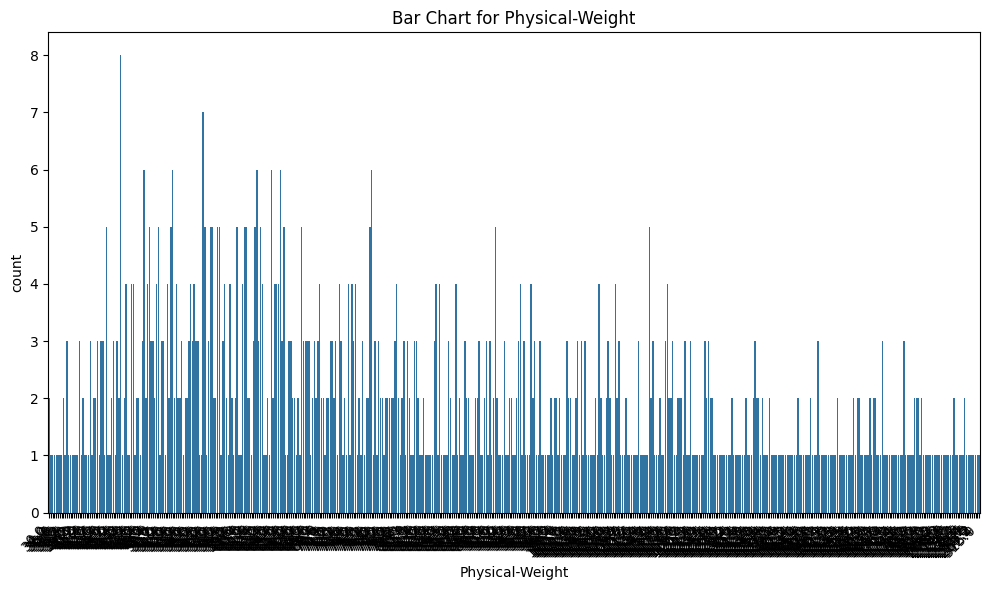

Frequency Counts for Physical-Waist_Circumference:
Physical-Waist_Circumference
22.0    8
21.0    6
23.0    5
20.0    5
26.0    4
25.0    4
24.0    3
28.0    3
30.0    2
34.0    1
40.0    1
32.0    1
46.0    1
19.0    1
45.0    1
27.0    1
Name: count, dtype: int64



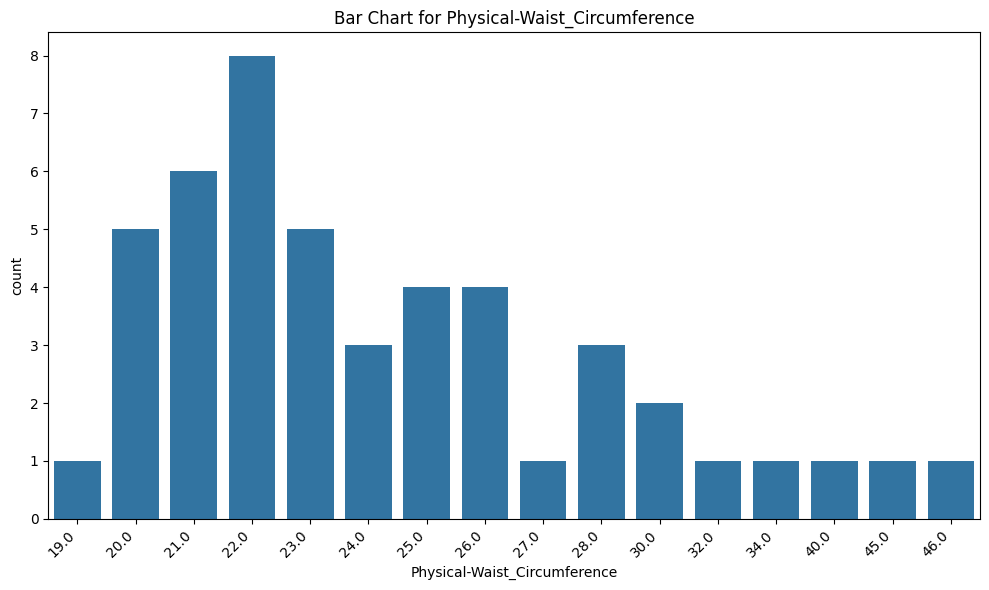

Frequency Counts for Physical-Diastolic_BP:
Physical-Diastolic_BP
60.0     52
67.0     39
61.0     39
70.0     39
62.0     36
66.0     35
73.0     34
64.0     34
65.0     33
69.0     31
71.0     31
68.0     30
63.0     30
74.0     28
76.0     27
59.0     26
72.0     24
57.0     23
58.0     23
75.0     21
80.0     19
56.0     19
78.0     19
77.0     17
55.0     16
79.0     16
81.0     13
83.0     13
54.0     12
50.0     10
53.0     10
85.0      9
86.0      8
84.0      8
52.0      7
87.0      7
82.0      7
88.0      6
45.0      6
93.0      6
105.0     6
89.0      6
95.0      5
94.0      5
101.0     5
49.0      5
106.0     4
51.0      4
111.0     4
92.0      4
97.0      4
43.0      3
39.0      3
102.0     3
42.0      3
103.0     3
98.0      3
90.0      3
115.0     3
48.0      3
96.0      3
91.0      3
40.0      2
35.0      2
108.0     2
104.0     2
109.0     2
145.0     2
47.0      2
44.0      2
99.0      1
123.0     1
179.0     1
34.0      1
114.0     1
129.0     1
119.0     1
127.0     

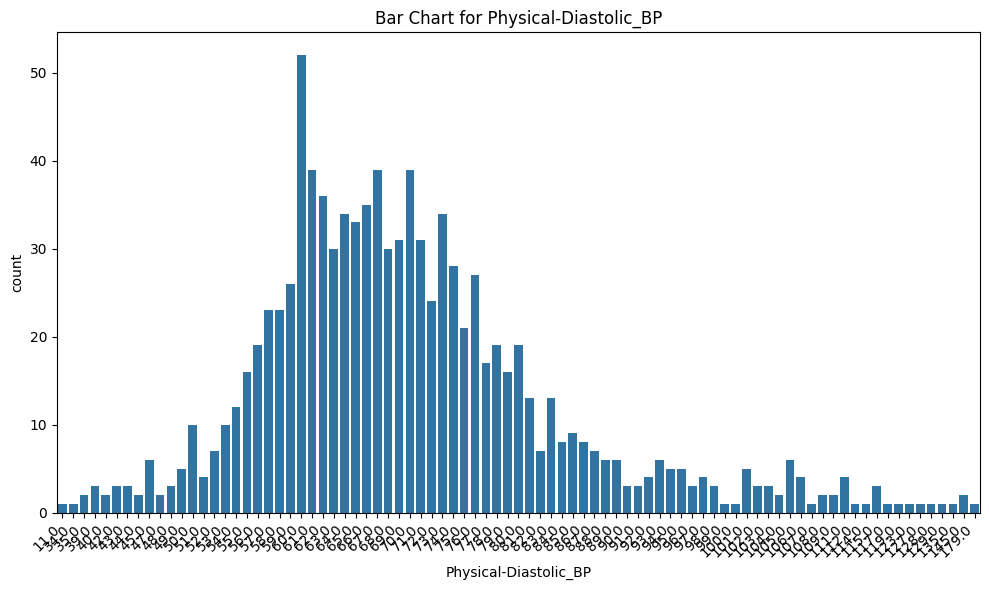

Frequency Counts for Physical-HeartRate:
Physical-HeartRate
99.0     36
78.0     36
77.0     33
86.0     31
81.0     31
80.0     29
73.0     28
75.0     28
83.0     28
72.0     27
82.0     26
84.0     25
74.0     25
79.0     25
69.0     25
85.0     24
76.0     24
89.0     23
94.0     22
92.0     22
88.0     22
70.0     21
90.0     21
71.0     21
68.0     17
97.0     17
87.0     17
93.0     16
95.0     16
96.0     15
91.0     15
100.0    14
67.0     14
62.0     13
65.0     12
98.0     12
104.0    11
64.0     11
66.0     11
58.0     11
61.0     10
63.0      9
102.0     7
60.0      7
110.0     7
103.0     7
105.0     6
57.0      6
107.0     5
52.0      5
59.0      5
106.0     4
54.0      4
101.0     4
113.0     4
55.0      3
116.0     3
112.0     3
53.0      3
119.0     2
118.0     2
111.0     2
109.0     2
45.0      1
130.0     1
33.0      1
48.0      1
115.0     1
27.0      1
138.0     1
56.0      1
114.0     1
51.0      1
134.0     1
46.0      1
120.0     1
117.0     1
Name: count, dty

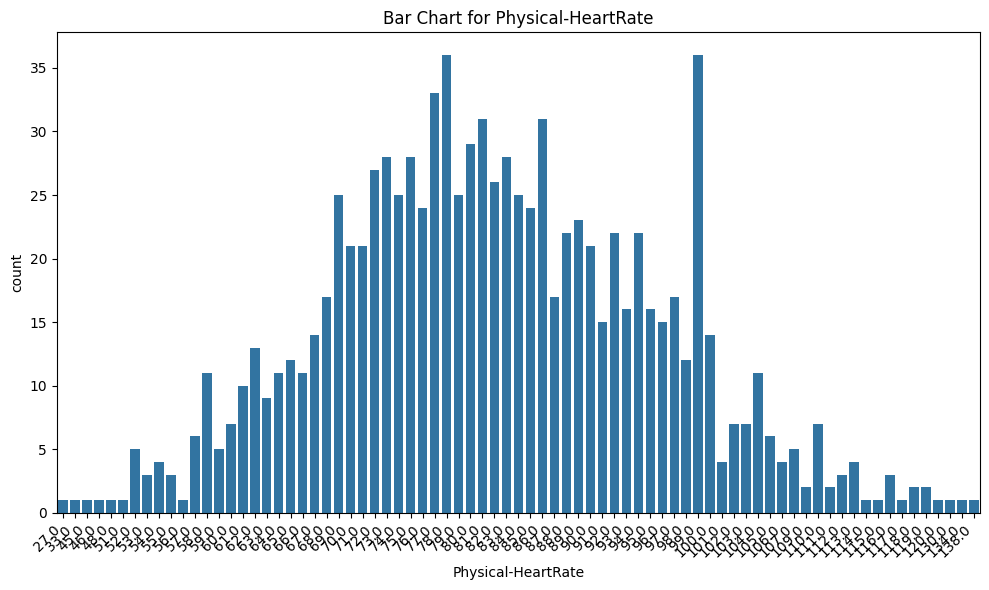

Frequency Counts for Physical-Systolic_BP:
Physical-Systolic_BP
110.0    41
111.0    36
115.0    34
112.0    34
107.0    33
114.0    31
108.0    30
109.0    26
117.0    25
106.0    25
113.0    23
104.0    23
102.0    23
105.0    23
120.0    22
118.0    22
125.0    21
116.0    20
121.0    19
103.0    19
119.0    19
124.0    18
129.0    17
127.0    17
122.0    17
98.0     15
101.0    15
139.0    15
133.0    14
130.0    14
126.0    13
123.0    13
128.0    13
136.0    13
100.0    13
96.0     12
131.0    11
99.0     10
92.0     10
132.0    10
149.0     9
94.0      9
95.0      8
93.0      7
97.0      7
134.0     7
145.0     6
138.0     5
142.0     5
135.0     5
91.0      5
144.0     5
137.0     5
158.0     4
140.0     4
152.0     4
150.0     4
146.0     4
157.0     3
151.0     3
161.0     3
156.0     3
88.0      3
162.0     3
165.0     3
174.0     3
87.0      3
154.0     2
147.0     2
175.0     2
155.0     2
143.0     2
164.0     2
176.0     2
89.0      2
168.0     2
181.0     1
77.0      1


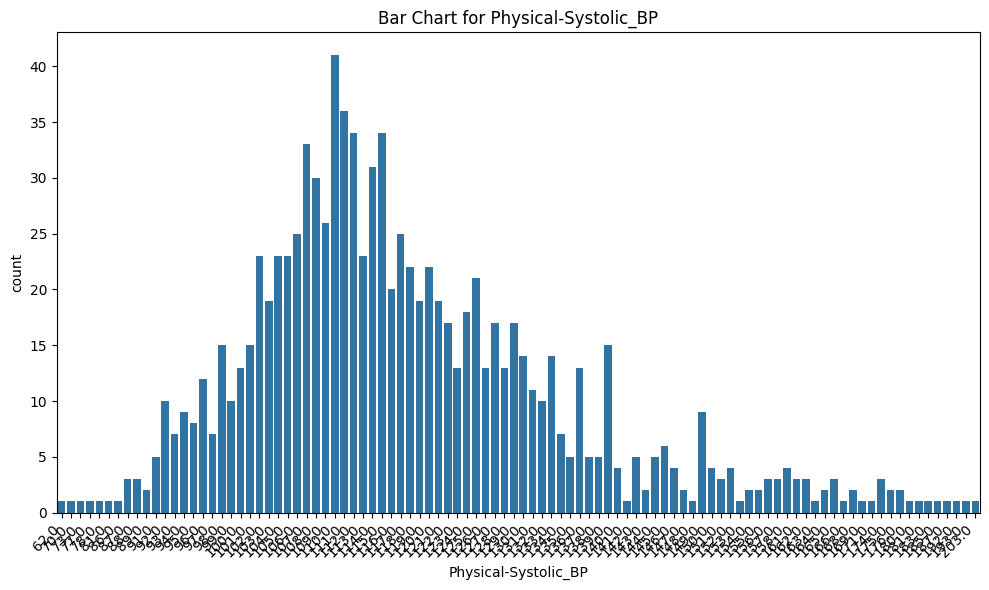

In [104]:
# Generate frequency counts and bar charts for the demographic and physical measures vars

# List of fields to analyze
fields = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season',
          'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight',
          'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate',
          'Physical-Systolic_BP']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()

#### Fitness Data

Frequency Counts for Fitness_Endurance-Season:
Fitness_Endurance-Season
Winter    160
Spring    152
Fall      113
Summer    106
Name: count, dtype: int64



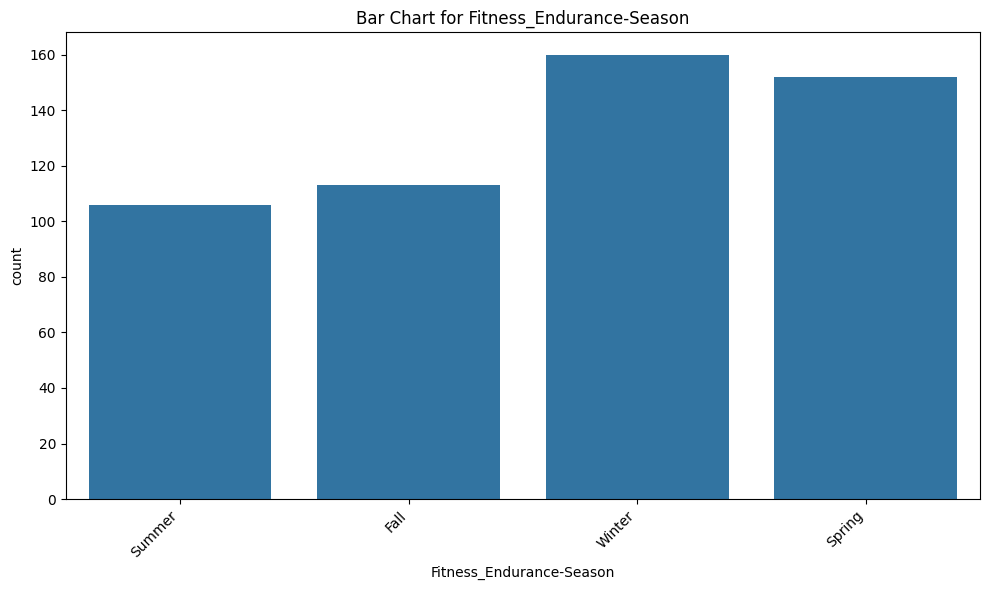

Frequency Counts for Fitness_Endurance-Max_Stage:
Fitness_Endurance-Max_Stage
5.0     85
6.0     72
4.0     52
7.0     29
3.0     27
2.0     18
8.0      6
1.0      4
12.0     2
9.0      2
0.0      1
26.0     1
Name: count, dtype: int64



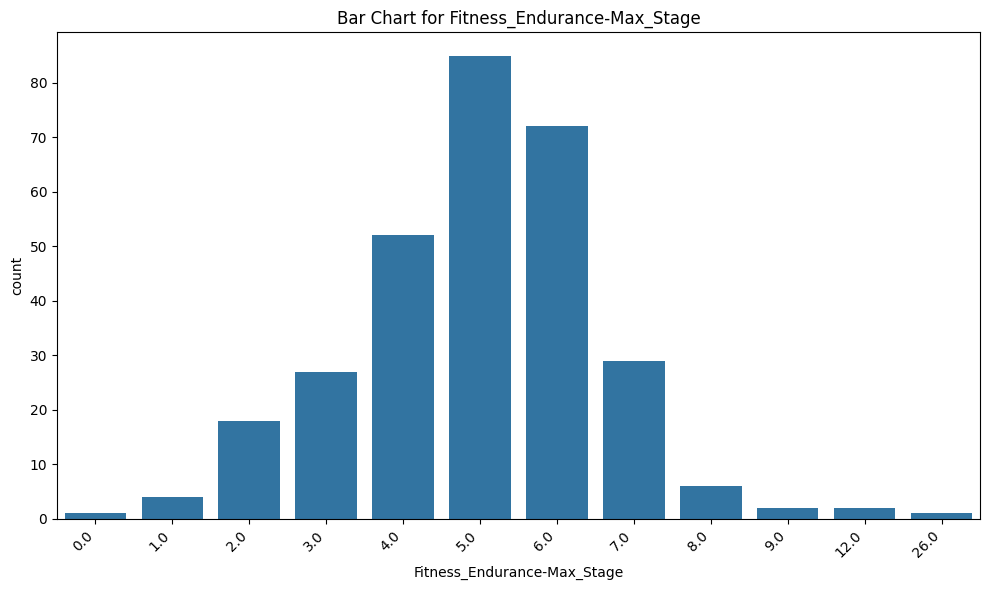

Frequency Counts for Fitness_Endurance-Time_Mins:
Fitness_Endurance-Time_Mins
7.0     57
9.0     53
6.0     28
8.0     27
10.0    22
5.0     21
11.0    17
3.0     15
4.0     15
12.0    11
1.0      9
2.0      8
13.0     7
0.0      3
20.0     2
15.0     2
14.0     1
Name: count, dtype: int64



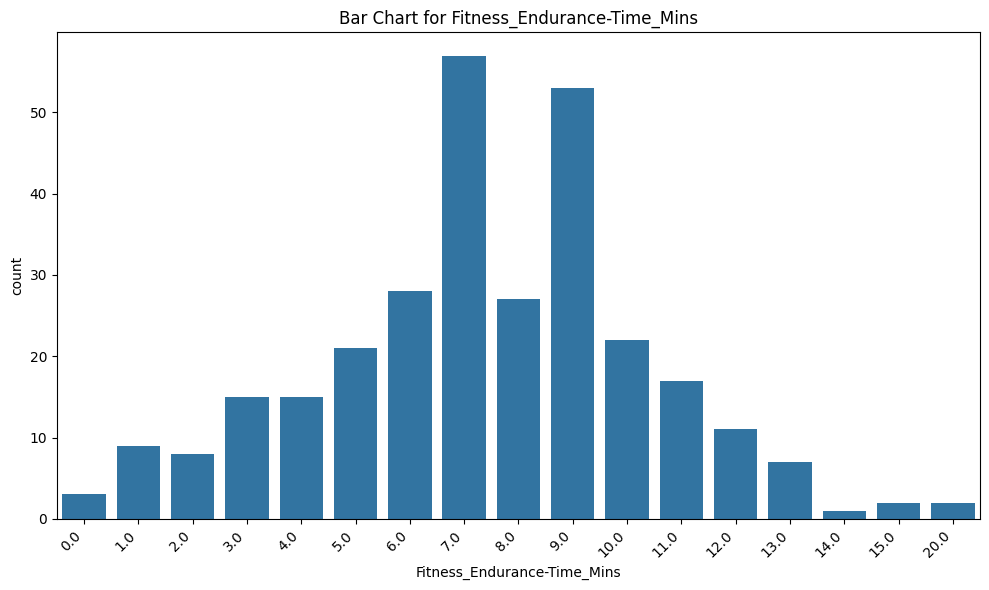

Frequency Counts for Fitness_Endurance-Time_Sec:
Fitness_Endurance-Time_Sec
0.0     24
30.0    12
15.0    12
20.0    11
40.0     9
12.0     9
37.0     8
9.0      8
4.0      8
19.0     7
23.0     7
38.0     7
34.0     7
53.0     7
50.0     7
1.0      6
21.0     6
39.0     6
29.0     6
16.0     5
26.0     5
10.0     5
6.0      5
24.0     5
22.0     5
45.0     5
55.0     5
51.0     4
17.0     4
25.0     4
8.0      4
43.0     4
44.0     4
32.0     4
28.0     4
5.0      4
46.0     4
36.0     4
52.0     3
35.0     3
42.0     3
48.0     3
58.0     3
49.0     3
59.0     3
2.0      3
41.0     3
56.0     3
47.0     2
18.0     2
57.0     2
7.0      2
31.0     2
11.0     2
33.0     2
13.0     1
14.0     1
27.0     1
Name: count, dtype: int64



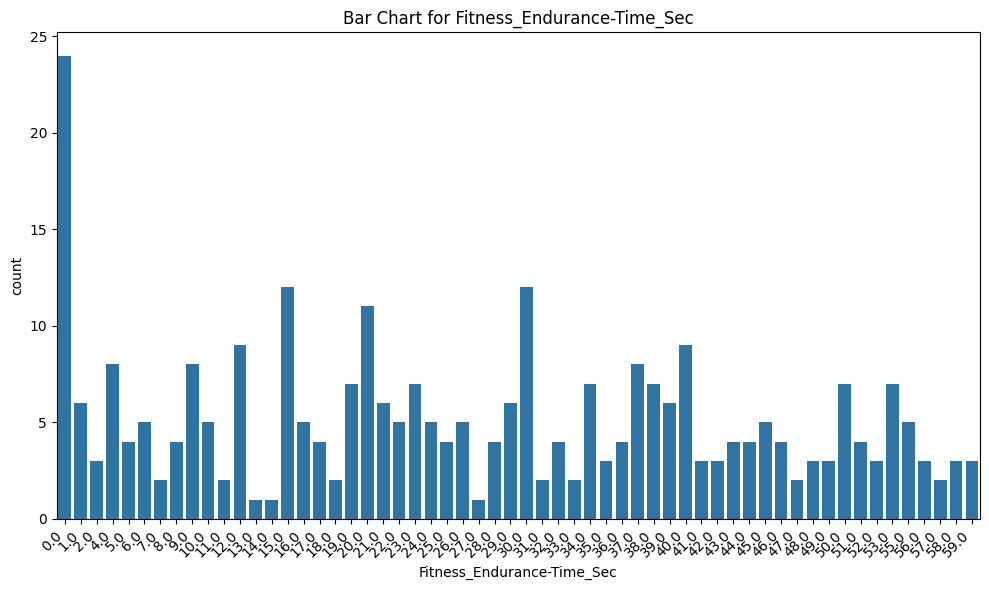

Frequency Counts for FGC-Season:
FGC-Season
Summer    249
Spring    241
Fall      238
Winter    237
Name: count, dtype: int64



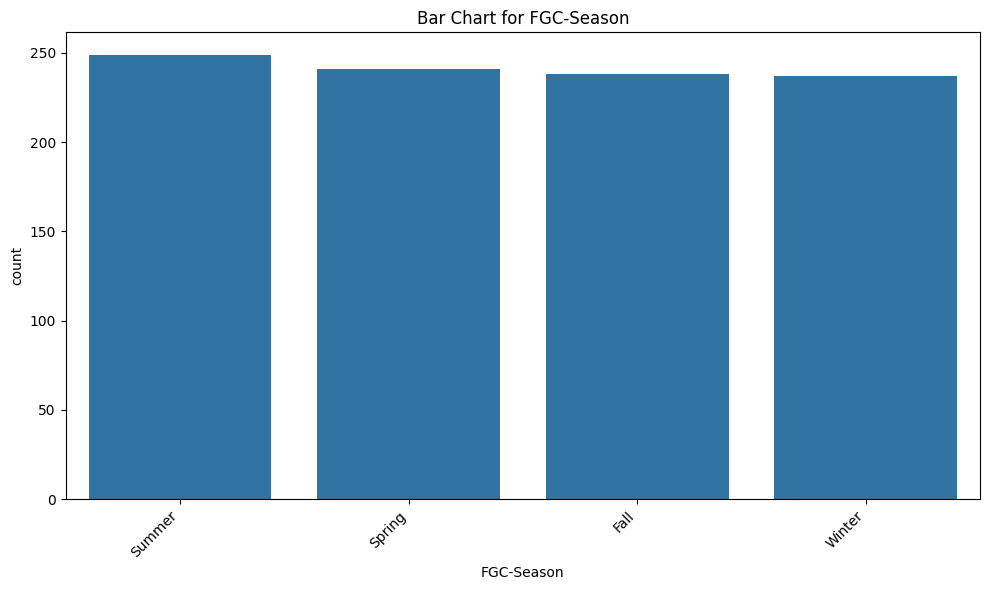

Frequency Counts for FGC-FGC_CU:
FGC-FGC_CU
0.0      93
10.0     66
6.0      36
5.0      35
7.0      35
20.0     35
8.0      34
11.0     31
3.0      30
15.0     27
2.0      25
4.0      24
12.0     23
9.0      23
1.0      18
13.0     16
25.0     15
30.0     14
17.0     14
18.0     12
14.0     11
16.0     11
26.0      6
19.0      6
40.0      5
50.0      5
23.0      4
35.0      4
31.0      4
21.0      3
22.0      3
27.0      3
45.0      2
24.0      2
28.0      2
41.0      2
37.0      2
34.0      2
36.0      2
32.0      2
33.0      1
43.0      1
78.0      1
38.0      1
66.0      1
85.0      1
70.0      1
60.0      1
42.0      1
55.0      1
100.0     1
Name: count, dtype: int64



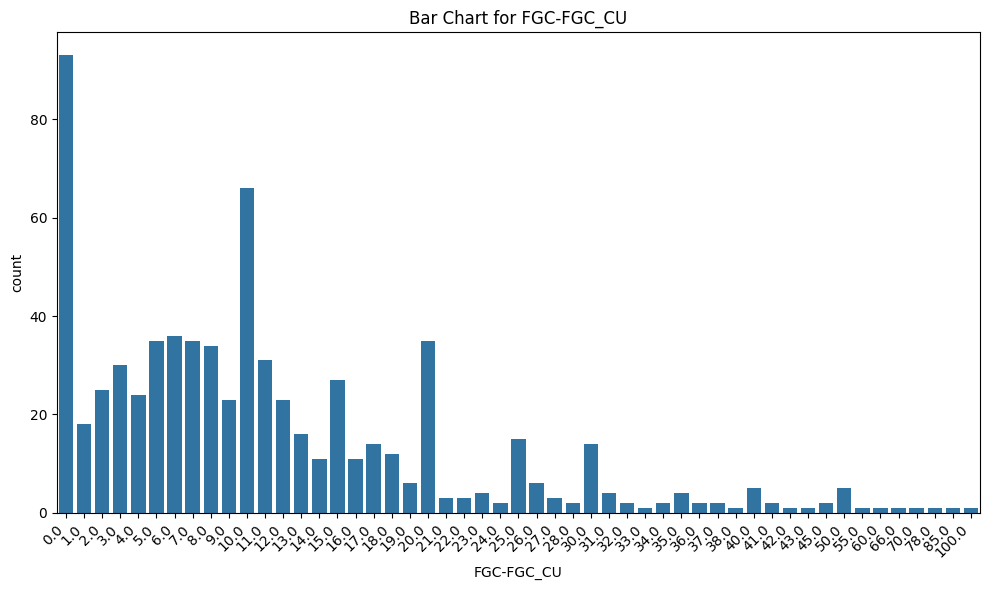

Frequency Counts for FGC-FGC_CU_Zone:
FGC-FGC_CU_Zone
1.0    360
0.0    325
Name: count, dtype: int64



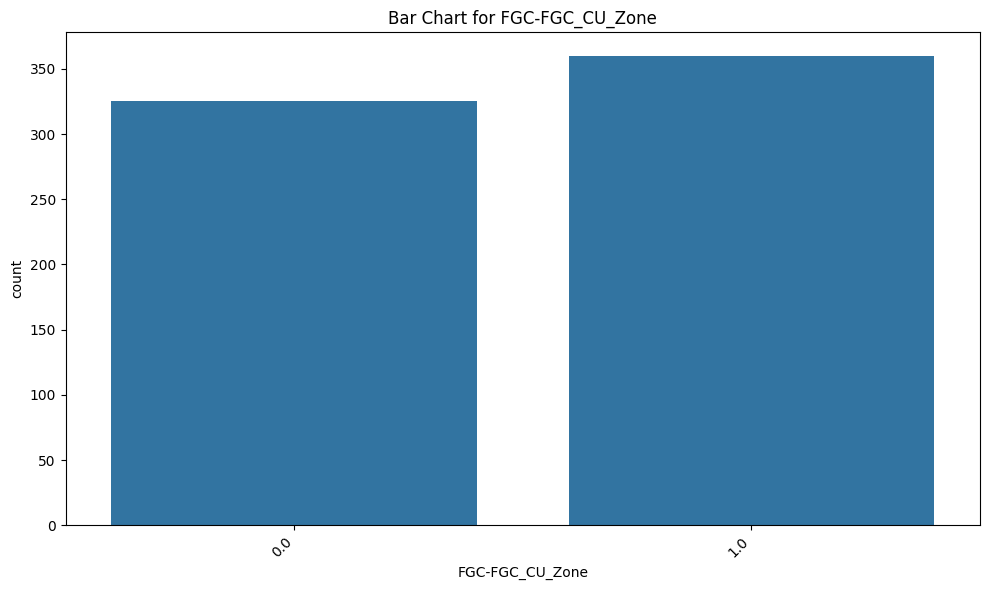

Frequency Counts for FGC-FGC_GSND:
FGC-FGC_GSND
15.5    7
16.5    5
16.1    5
18.2    5
15.3    4
16.8    4
19.0    4
27.7    4
20.3    4
30.3    4
15.2    4
30.0    3
13.7    3
23.7    3
22.9    3
12.2    3
18.7    3
14.9    3
13.6    3
43.2    3
23.6    3
13.2    3
16.6    3
20.7    3
17.2    3
24.5    3
18.0    3
23.5    3
18.6    3
22.0    3
12.6    3
19.3    3
16.3    2
27.8    2
17.0    2
29.6    2
21.5    2
13.9    2
15.4    2
18.9    2
29.1    2
16.0    2
17.4    2
25.5    2
18.5    2
30.1    2
23.2    2
18.4    2
23.9    2
23.4    2
26.8    2
18.3    2
20.6    2
17.7    2
14.4    2
11.7    2
9.2     2
24.7    2
21.6    2
14.8    2
19.8    2
22.1    2
25.8    2
18.1    2
15.7    2
45.0    2
14.7    2
31.6    2
15.0    2
17.1    2
17.9    2
21.7    2
26.3    2
10.3    2
35.5    2
12.8    2
17.6    2
22.3    2
20.0    1
22.2    1
19.1    1
11.5    1
17.8    1
28.9    1
20.1    1
37.4    1
12.0    1
14.3    1
16.7    1
12.9    1
20.9    1
12.7    1
35.8    1
50.2    1
14.1    1
31

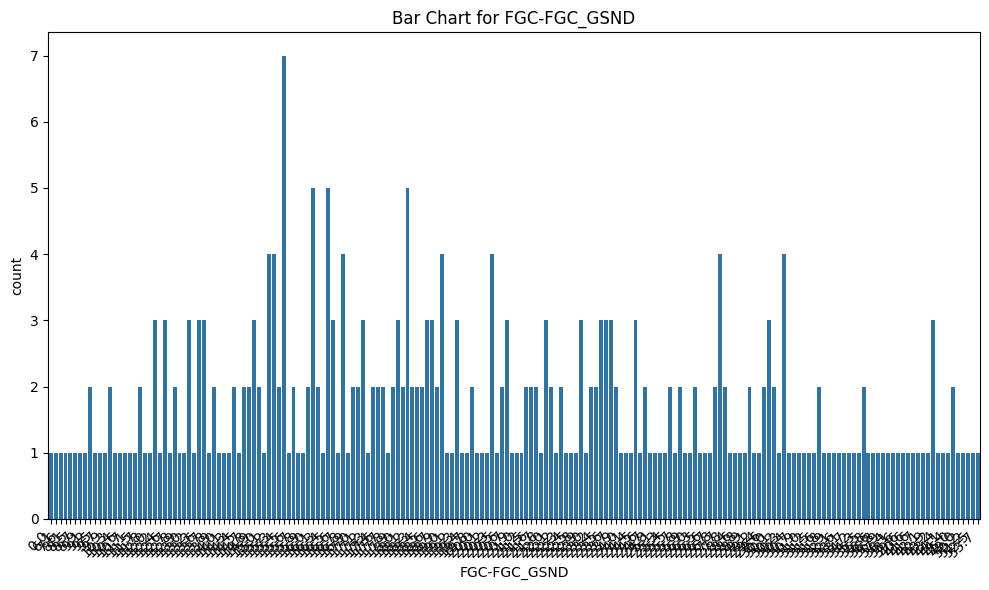

Frequency Counts for FGC-FGC_GSND_Zone:
FGC-FGC_GSND_Zone
2.0    184
1.0     94
3.0     34
Name: count, dtype: int64



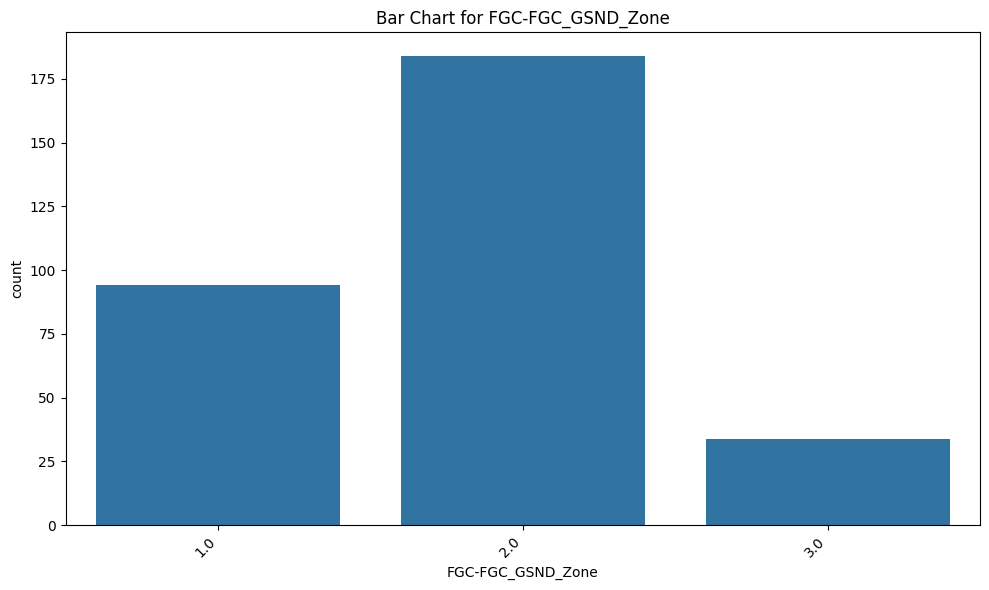

Frequency Counts for FGC-FGC_GSD:
FGC-FGC_GSD
17.20    6
22.30    5
11.90    5
29.30    5
16.50    5
18.20    4
19.70    4
9.10     4
33.00    4
21.20    4
21.80    3
28.30    3
16.20    3
14.60    3
20.10    3
21.10    3
18.00    3
18.40    3
17.80    3
15.90    3
14.90    3
22.90    3
20.00    3
20.50    3
26.50    3
21.30    3
28.50    3
17.70    3
14.30    2
40.80    2
16.70    2
30.10    2
26.00    2
12.30    2
17.40    2
26.70    2
10.50    2
19.90    2
23.20    2
18.30    2
20.60    2
25.80    2
27.80    2
16.80    2
25.20    2
36.80    2
22.00    2
13.70    2
10.90    2
26.40    2
17.30    2
26.80    2
34.70    2
17.90    2
18.90    2
15.70    2
18.60    2
15.50    2
30.50    2
9.70     2
14.50    2
14.10    2
16.60    2
17.60    2
38.60    2
19.10    2
10.60    2
27.60    2
19.00    2
14.70    2
18.70    2
19.30    2
12.60    2
38.00    2
25.30    2
26.10    2
23.00    1
14.40    1
12.50    1
13.79    1
24.50    1
49.60    1
35.20    1
9.20     1
27.10    1
13.40    1
22.50   

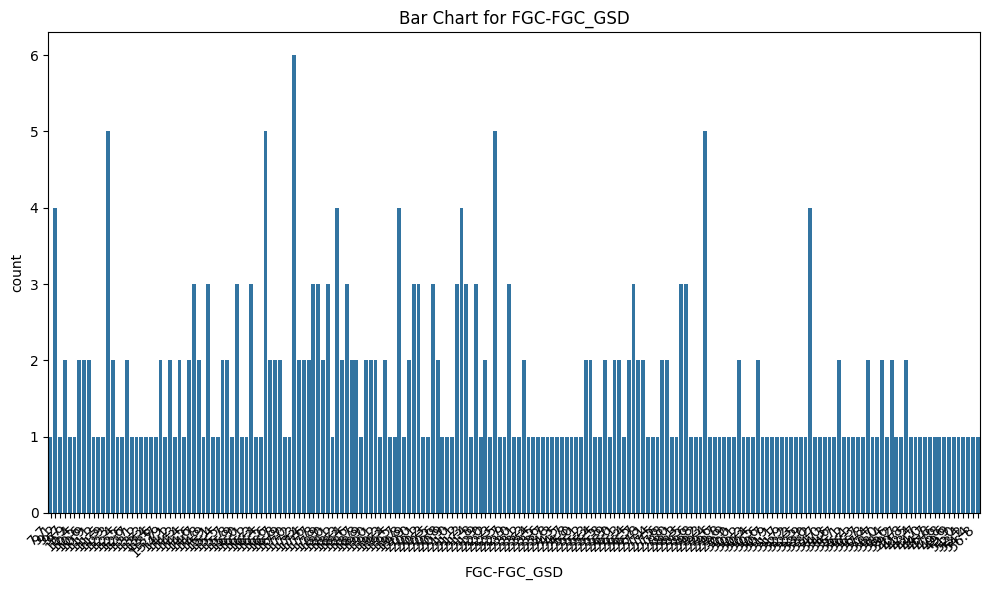

Frequency Counts for FGC-FGC_GSD_Zone:
FGC-FGC_GSD_Zone
2.0    194
1.0     76
3.0     42
Name: count, dtype: int64



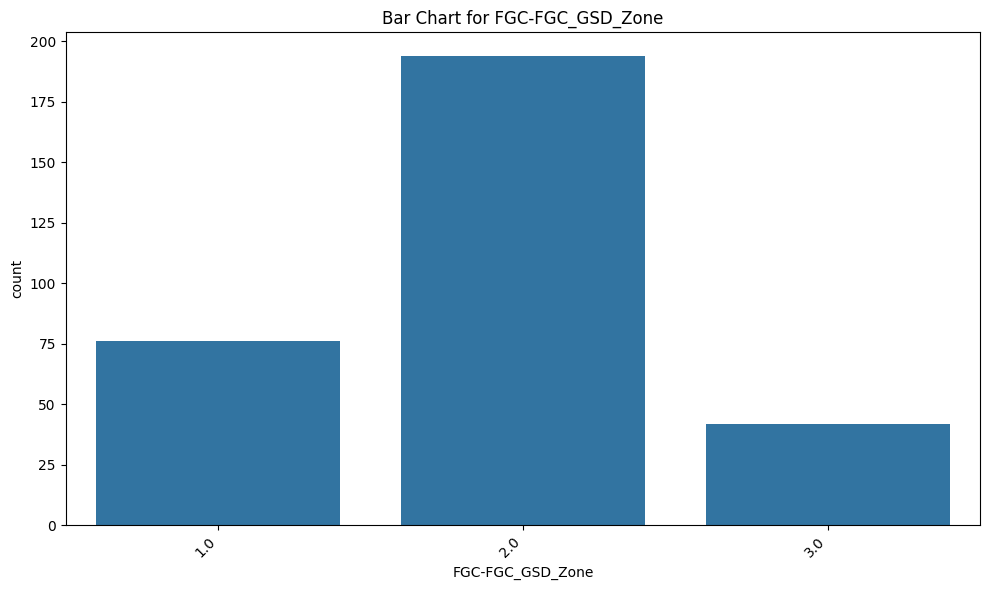

Frequency Counts for FGC-FGC_PU:
FGC-FGC_PU
0.0     216
2.0      50
1.0      47
10.0     44
4.0      42
3.0      40
5.0      39
6.0      31
7.0      24
9.0      19
15.0     19
8.0      18
11.0     17
20.0     14
12.0     12
13.0     11
30.0     10
14.0     10
25.0      5
17.0      4
19.0      4
16.0      3
18.0      3
22.0      3
24.0      2
47.0      1
26.0      1
21.0      1
29.0      1
36.0      1
39.0      1
32.0      1
28.0      1
35.0      1
50.0      1
Name: count, dtype: int64



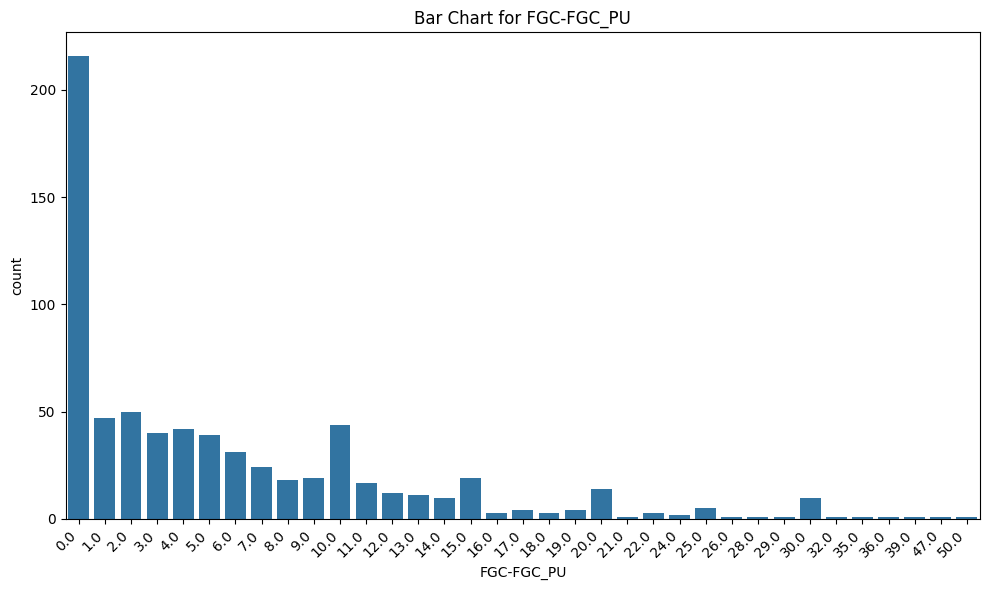

Frequency Counts for FGC-FGC_PU_Zone:
FGC-FGC_PU_Zone
0.0    447
1.0    237
Name: count, dtype: int64



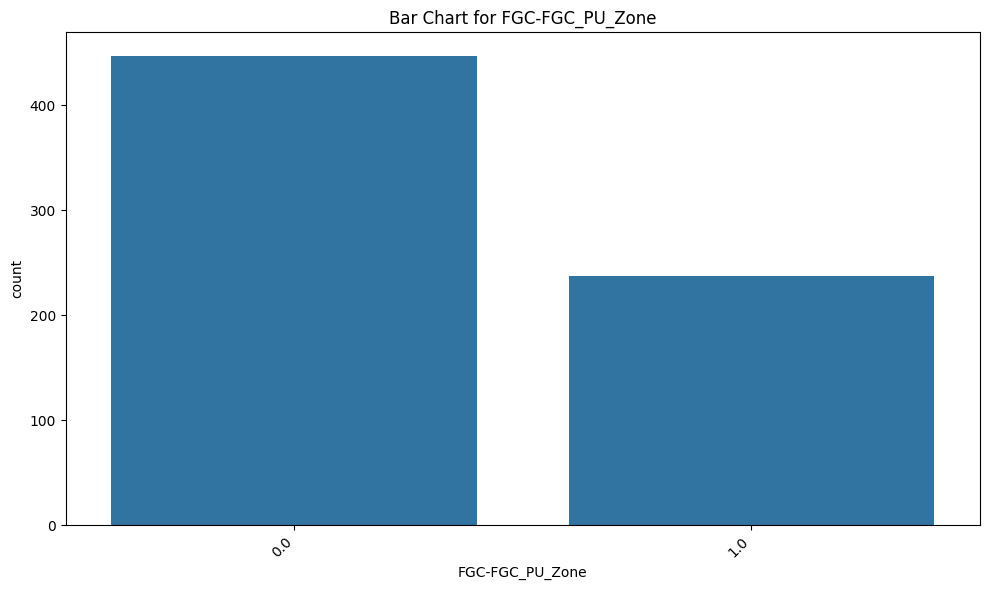

Frequency Counts for FGC-FGC_SRL:
FGC-FGC_SRL
10.00    71
11.00    70
8.00     58
9.00     56
7.00     54
12.00    50
6.00     43
13.00    31
5.00     28
9.50     24
4.00     21
8.50     21
0.00     19
7.50     19
10.50    17
5.50     16
14.00    15
11.50    11
12.50    10
6.50     10
4.50      7
13.50     6
16.00     5
15.00     5
14.50     3
17.00     3
3.50      3
18.00     3
6.25      2
2.00      2
7.25      2
13.25     1
5.70      1
7.80      1
19.00     1
15.60     1
3.00      1
14.20     1
8.25      1
15.50     1
6.75      1
Name: count, dtype: int64



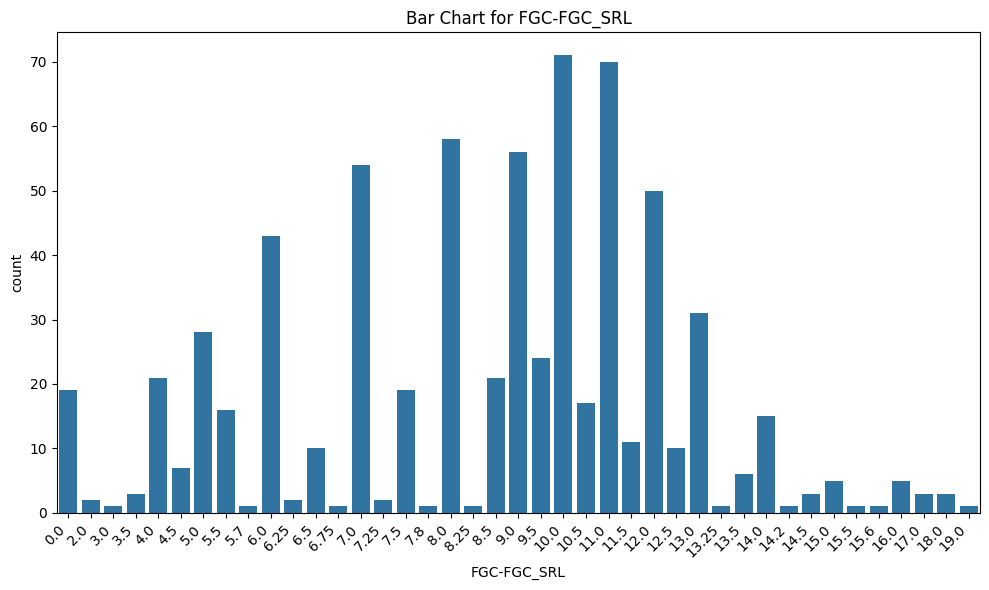

Frequency Counts for FGC-FGC_SRL_Zone:
FGC-FGC_SRL_Zone
1.0    446
0.0    236
Name: count, dtype: int64



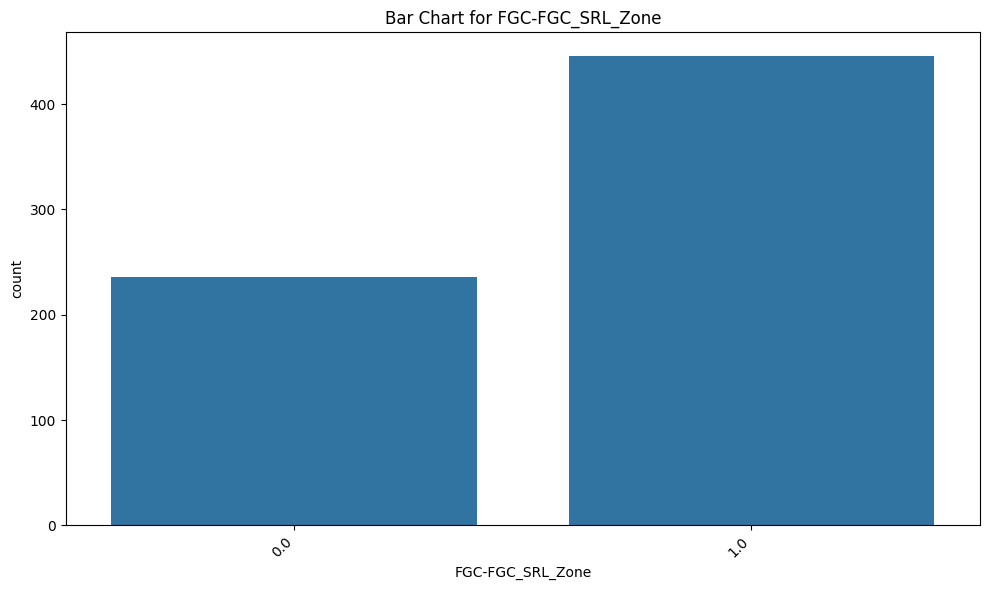

Frequency Counts for FGC-FGC_SRR:
FGC-FGC_SRR
12.00    70
10.00    66
11.00    60
7.00     55
8.00     53
9.00     53
6.00     40
13.00    36
5.00     33
7.50     25
8.50     21
11.50    20
0.00     20
4.00     19
9.50     19
14.00    16
6.50     12
12.50    11
15.00    11
10.50     9
5.50      9
4.50      6
19.00     3
13.50     3
17.00     3
14.50     2
3.50      2
16.00     2
8.75      2
7.90      1
10.20     1
7.75      1
6.20      1
9.20      1
14.25     1
16.50     1
4.75      1
2.00      1
6.40      1
4.25      1
7.20      1
7.25      1
18.00     1
10.25     1
Name: count, dtype: int64



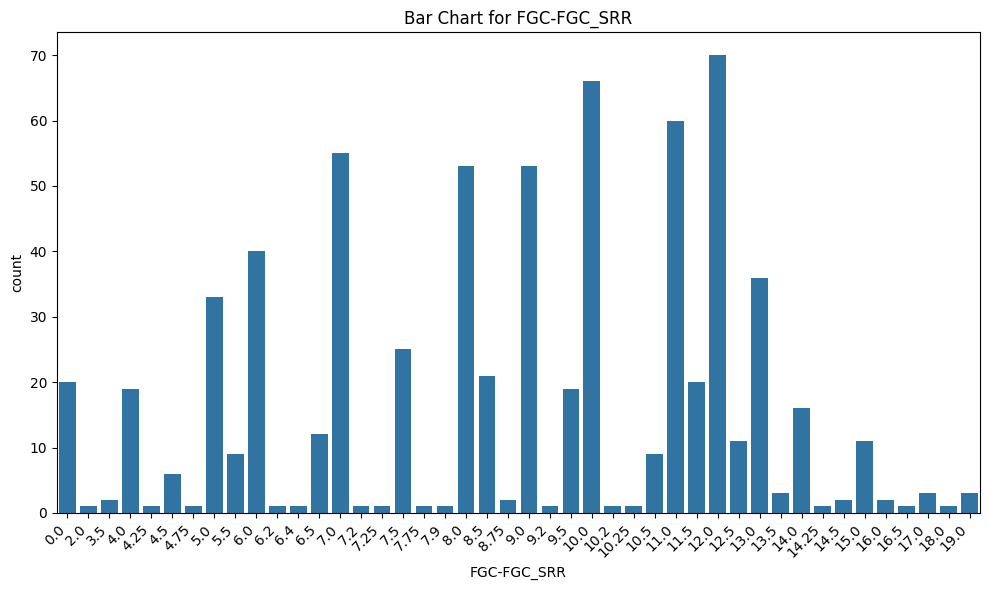

Frequency Counts for FGC-FGC_SRR_Zone:
FGC-FGC_SRR_Zone
1.0    448
0.0    235
Name: count, dtype: int64



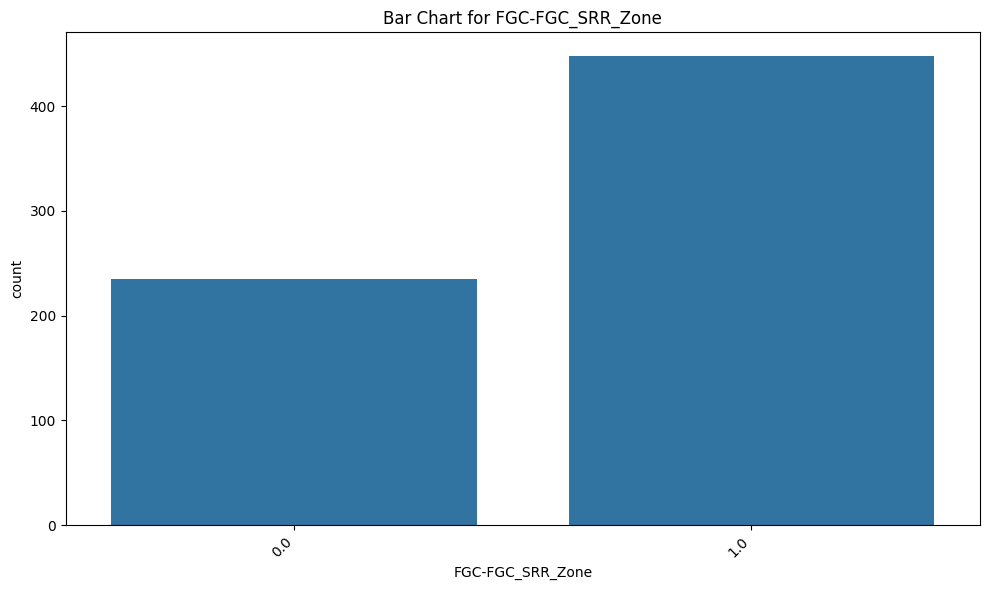

Frequency Counts for FGC-FGC_TL:
FGC-FGC_TL
12.0    120
10.0     83
8.0      81
9.0      75
11.0     61
7.0      55
6.0      40
5.0      27
13.0     22
4.0      19
3.0      16
14.0     15
6.5      13
8.5      11
9.5       8
2.0       8
15.0      6
10.5      6
7.5       6
4.5       6
3.5       4
5.5       3
11.5      3
16.0      2
17.0      2
12.5      1
13.5      1
1.0       1
19.0      1
2.5       1
18.0      1
0.0       1
Name: count, dtype: int64



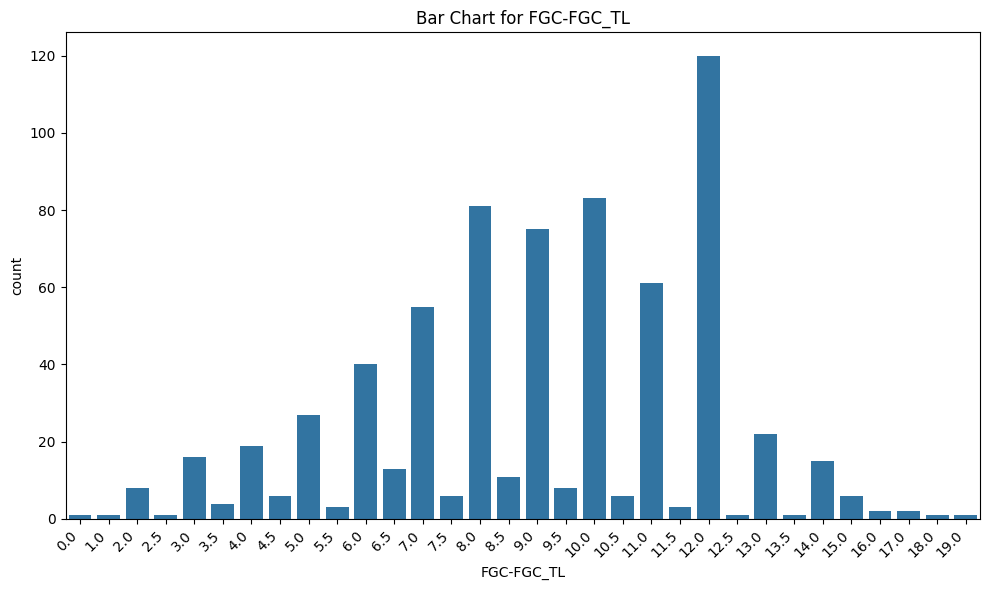

Frequency Counts for FGC-FGC_TL_Zone:
FGC-FGC_TL_Zone
1.0    528
0.0    158
Name: count, dtype: int64



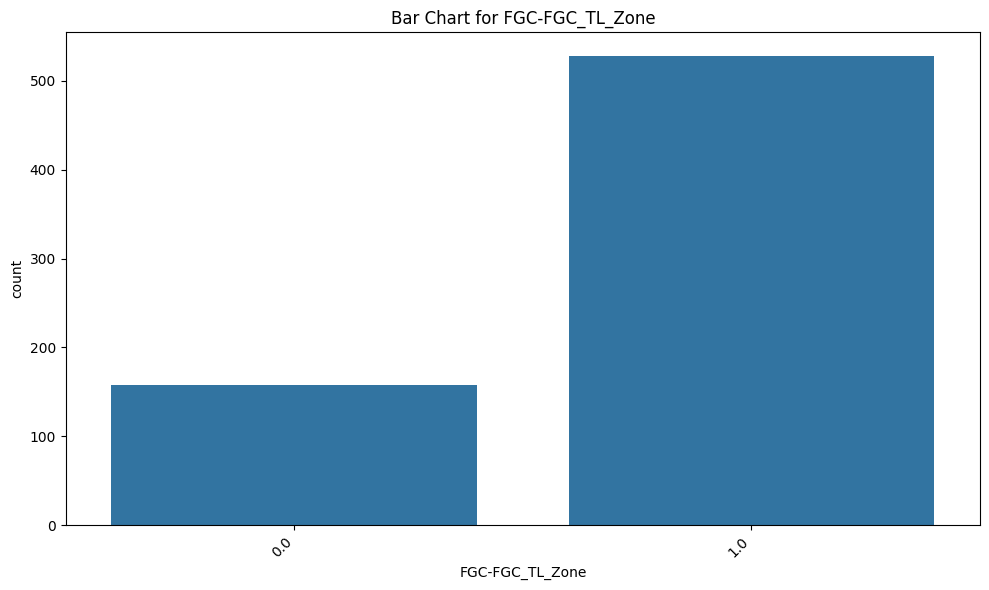

In [105]:
# Generate frequency counts and bar charts for fitness data

# List of fields to analyze
fields = ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU',
       'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()

#### Bioelectric Impedence Data


Frequency Counts for BIA-Season:
BIA-Season
Summer    274
Fall      183
Winter    157
Spring    123
Name: count, dtype: int64



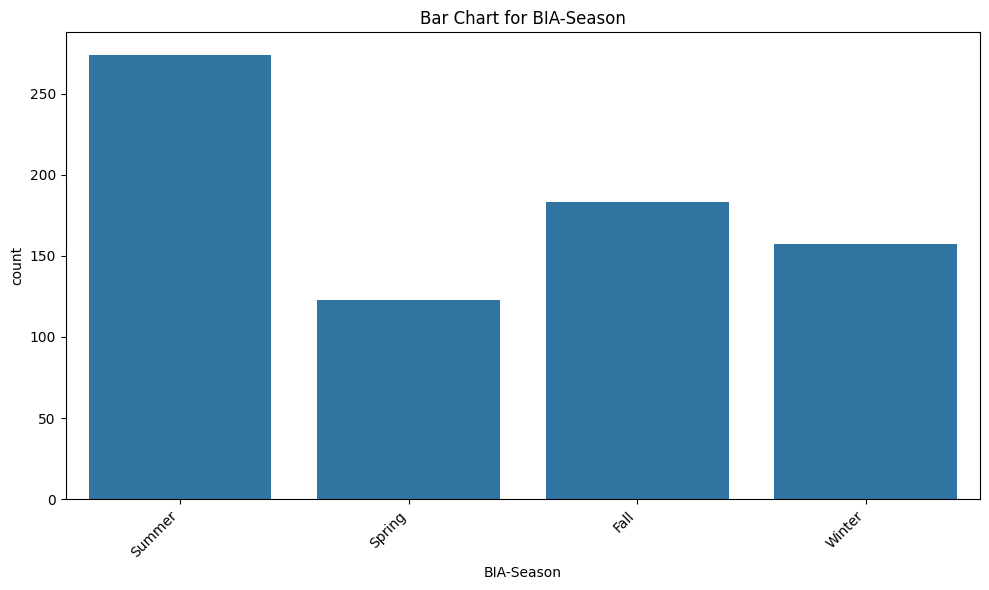

Frequency Counts for BIA-BIA_Activity_Level_num:
BIA-BIA_Activity_Level_num
3.0    287
2.0    230
1.0     97
4.0     96
5.0     27
Name: count, dtype: int64



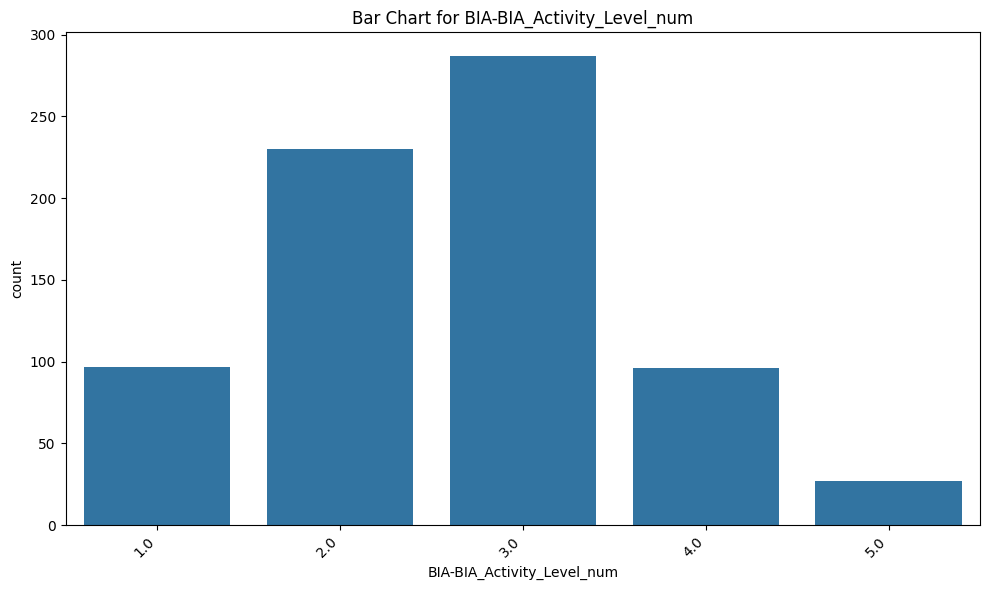

Frequency Counts for BIA-BIA_BMC:
BIA-BIA_BMC
 3.650990     2
 3.841910     1
 3.769720     1
 3.250380     1
 5.779440     1
 4.202880     1
 4.380240     1
 6.588600     1
 2.479420     1
 5.092800     1
 4.719340     1
 1.947760     1
 2.746430     1
 5.592540     1
 2.981270     1
 2.765940     1
 2.986270     1
 3.281360     1
 9.861510     1
 9.306100     1
 3.584060     1
 2.641880     1
 4.959000     1
 7.064850     1
 3.634780     1
 2.978920     1
 3.988900     1
 2.991900     1
 3.809090     1
 3.349710     1
 3.544350     1
 7.040220     1
 3.777550     1
 2.381960     1
 0.018947     1
 3.073820     1
-0.632482     1
 3.811610     1
 2.674060     1
 8.322940     1
 3.127550     1
 6.006430     1
 4.851970     1
 3.664250     1
 4.527180     1
 2.487530     1
 4.734160     1
 2.909860     1
 3.240760     1
 3.962990     1
 3.014420     1
 6.637010     1
 4.600650     1
 7.004510     1
 6.778920     1
 3.529520     1
 4.633560     1
 4.834590     1
 6.404900     1
 8.641270 

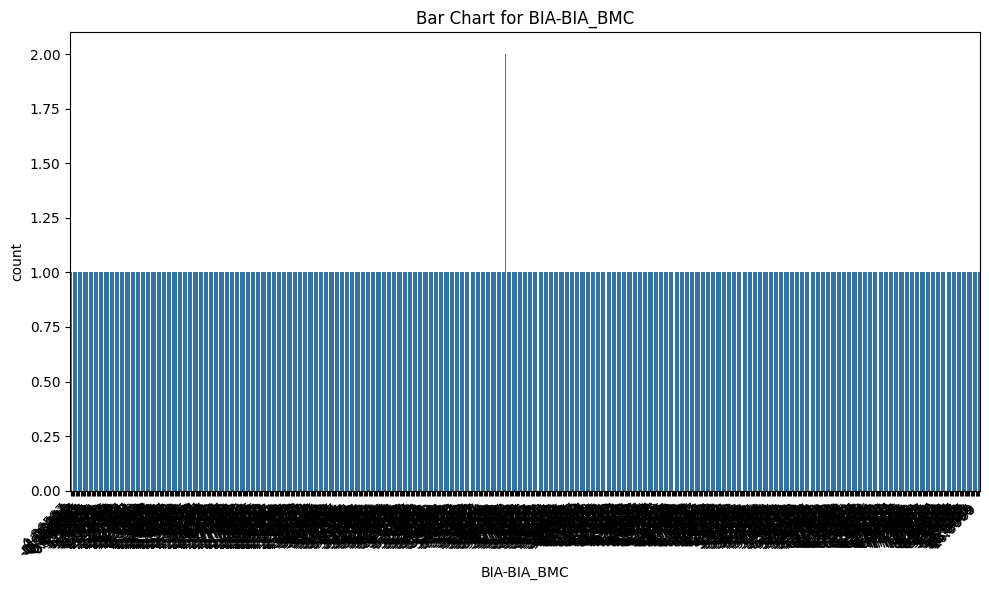

Frequency Counts for BIA-BIA_BMI:
BIA-BIA_BMI
16.1122    3
29.1215    2
15.6662    2
17.2660    2
18.0259    2
16.2695    2
15.4677    2
17.6050    2
16.2691    2
14.7077    2
17.1516    2
14.0371    2
17.3599    2
14.0042    2
14.7365    2
15.7204    2
16.8044    2
16.5729    2
17.5728    2
15.4862    2
16.6778    2
16.1105    2
14.8208    2
14.9927    1
17.3000    1
21.2060    1
14.2167    1
14.0906    1
19.4300    1
15.9755    1
27.5462    1
17.2796    1
15.2856    1
14.9255    1
19.0959    1
18.5712    1
19.5342    1
16.0864    1
25.4385    1
23.5052    1
19.9883    1
16.2409    1
32.5587    1
17.7114    1
14.9792    1
16.4385    1
15.6446    1
22.3513    1
19.6844    1
22.9700    1
23.3877    1
15.2693    1
19.1890    1
21.8541    1
18.5463    1
16.9456    1
24.9238    1
34.0591    1
16.7025    1
18.0833    1
16.9071    1
13.9761    1
15.8422    1
18.1774    1
20.4862    1
15.5341    1
16.9492    1
16.6428    1
16.5519    1
24.3290    1
15.6722    1
16.9311    1
14.0021    1
19.47

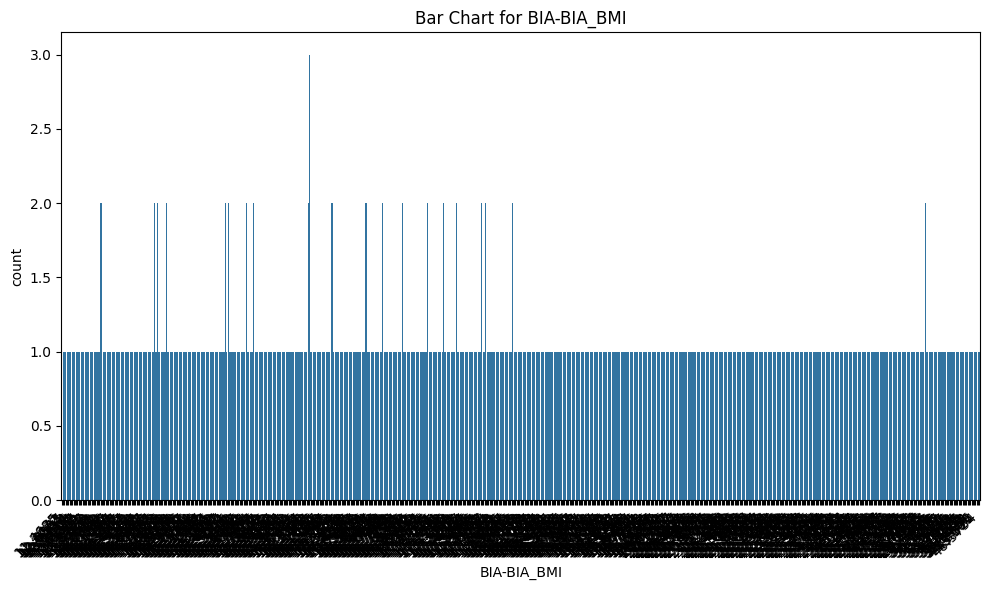

Frequency Counts for BIA-BIA_BMR:
BIA-BIA_BMR
1154.360    2
1196.160    2
1056.540    2
1049.440    2
1045.100    2
1131.430    1
1079.080    1
970.857     1
1297.390    1
1214.430    1
1128.310    1
1370.800    1
1398.290    1
1192.190    1
985.795     1
951.908     1
1036.160    1
1067.550    1
2057.850    1
2168.440    1
1133.120    1
918.730     1
903.300     1
1321.610    1
1216.780    1
998.311     1
1014.770    1
1063.310    1
1112.850    1
908.243     1
1117.490    1
958.792     1
1252.690    1
1011.520    1
1685.130    1
1142.990    1
989.727     1
1863.730    1
1507.010    1
1279.060    1
939.078     1
1314.510    1
1133.990    1
1120.970    1
1127.060    1
1559.140    1
1353.740    1
924.224     1
1451.210    1
1061.860    1
979.944     1
1175.780    1
1113.610    1
1750.490    1
1686.240    1
1270.180    1
1293.210    1
1473.010    1
877.269     1
1645.010    1
1137.920    1
950.848     1
1158.830    1
1751.770    1
1301.840    1
925.027     1
1304.010    1
910.228     1
10

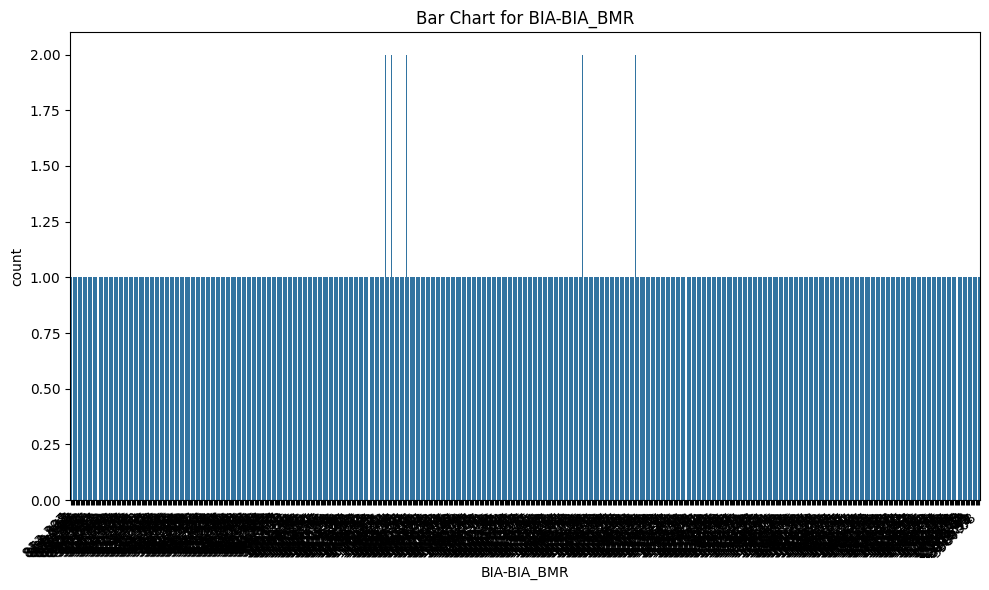

Frequency Counts for BIA-BIA_DEE:
BIA-BIA_DEE
2033.47    2
1923.44    1
2330.36    1
2555.24    1
1907.51    1
2114.57    1
1402.80    1
1456.29    1
2205.56    1
2550.30    1
1805.30    1
2377.10    1
1591.22    1
1675.85    1
1523.05    1
1657.86    1
1708.08    1
3498.35    1
2818.97    1
1473.06    1
1561.84    1
1174.29    1
1725.11    1
2494.62    1
1465.18    1
1793.56    1
2176.82    1
1830.19    1
1382.30    1
1891.85    1
1907.31    1
2346.72    1
1246.43    1
2004.30    1
2124.19    1
2696.21    1
2743.19    1
1484.59    1
3168.33    1
1776.68    1
2411.22    1
2174.40    1
1220.80    1
2234.67    1
1474.19    1
2165.98    1
1697.13    1
1201.49    1
1698.98    1
1665.90    1
1881.24    1
1781.77    1
2975.84    1
2697.98    1
1784.05    1
1651.24    1
2715.75    1
2504.12    1
1403.63    1
3454.51    1
2162.06    1
1521.36    1
1970.01    1
2802.84    1
2733.86    1
1480.04    1
1956.01    1
1183.30    1
1548.64    1
1705.07    1
1797.27    1
1696.67    1
1601.68    1
1759.

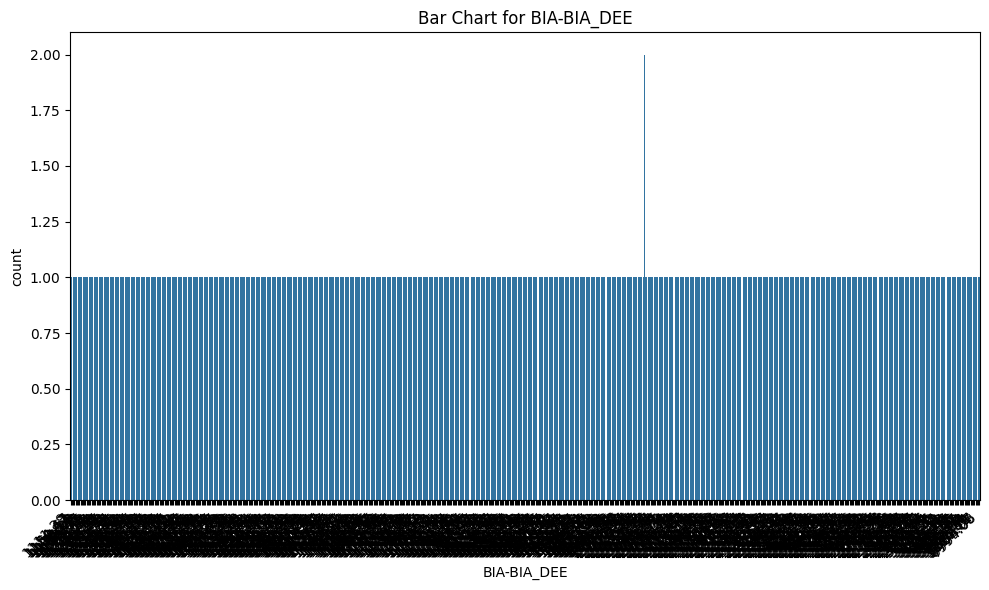

Frequency Counts for BIA-BIA_ECW:
BIA-BIA_ECW
15.59250     1
25.09880     1
9.67772      1
18.60570     1
22.37410     1
24.31710     1
16.82060     1
11.53590     1
21.83280     1
17.16910     1
14.59970     1
26.41270     1
24.34940     1
9.14094      1
9.19472      1
15.60510     1
10.67800     1
50.12860     1
56.02360     1
19.90750     1
6.35376      1
6.94675      1
30.45900     1
16.36360     1
14.30360     1
21.47260     1
18.09350     1
34.75020     1
18.87560     1
11.93120     1
10.77740     1
6.89881      1
14.48040     1
11.17980     1
25.09390     1
8.16351      1
35.19980     1
15.43290     1
13.91700     1
44.47280     1
10.44120     1
29.69080     1
21.35840     1
8.04164      1
23.19700     1
30.39820     1
6.89337      1
9.93839      1
12.91770     1
8.74677      1
20.38450     1
20.39870     1
39.44610     1
45.19950     1
12.58450     1
25.53080     1
22.28470     1
29.20920     1
4.72534      1
36.25920     1
20.44560     1
12.05700     1
16.07660     1
40.77210 

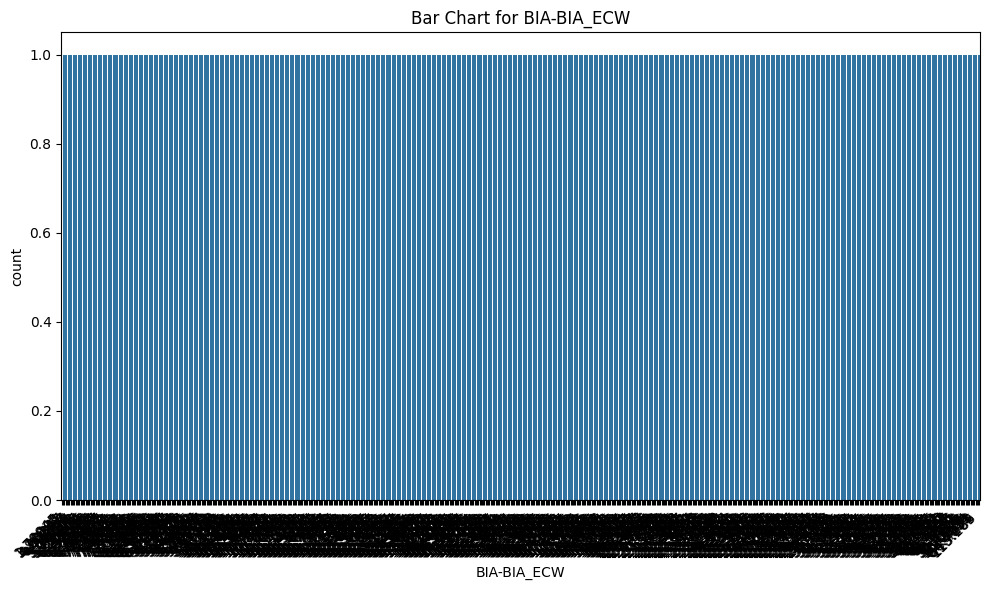

Frequency Counts for BIA-BIA_FFM:
BIA-BIA_FFM
62.7757     1
88.2715     1
50.3494     1
71.8661     1
69.2470     1
83.0316     1
57.1988     1
45.6721     1
80.4520     1
71.6158     1
62.4429     1
91.1996     1
86.8116     1
47.2631     1
43.6537     1
52.6279     1
55.9711     1
161.4510    1
173.2300    1
62.9553     1
40.1199     1
38.4763     1
108.3320    1
62.3097     1
61.6613     1
63.0479     1
70.5270     1
96.8363     1
64.1001     1
55.5193     1
60.7966     1
39.0028     1
61.2899     1
44.3870     1
75.6910     1
50.0033     1
121.7510    1
64.0070     1
47.6819     1
140.7740    1
53.5802     1
102.7800    1
78.4993     1
42.2871     1
82.2761     1
86.4540     1
48.5962     1
40.7049     1
55.3650     1
46.6399     1
67.4988     1
60.8769     1
128.7140    1
121.8700    1
54.0422     1
77.5543     1
80.0071     1
99.1579     1
35.7036     1
117.4780    1
63.4669     1
43.5408     1
65.6937     1
128.8500    1
80.9261     1
40.7905     1
81.1571     1
39.2142     1
45

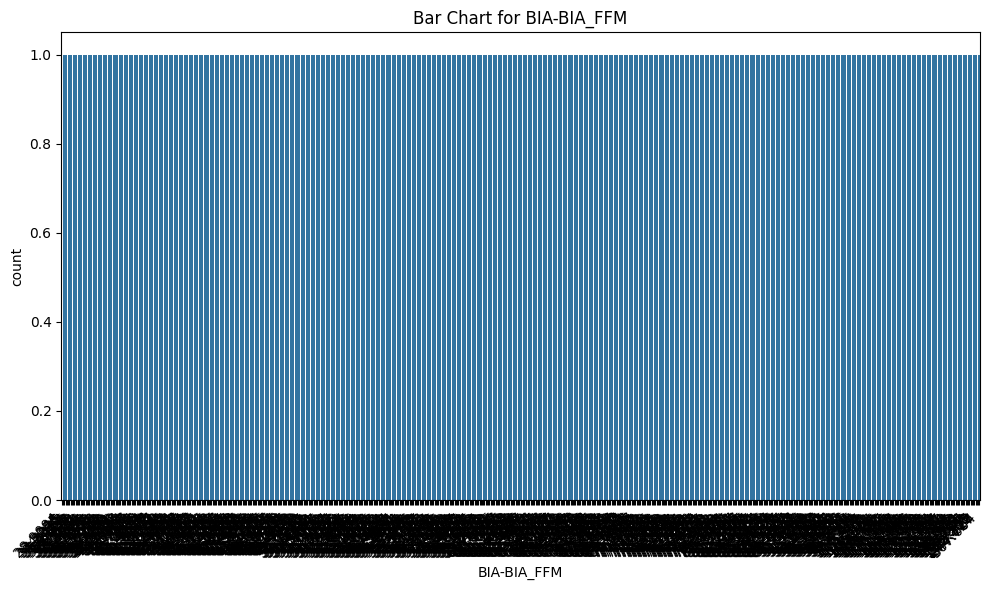

Frequency Counts for BIA-BIA_FFMI:
BIA-BIA_FFMI
13.7284    2
14.3936    2
13.7409    2
13.3464    2
13.5013    2
14.6169    2
13.3655    2
13.7496    2
13.0301    2
16.5871    2
14.1222    2
14.2514    1
13.5239    1
17.3536    1
13.5393    1
13.3740    1
14.0740    1
12.4872    1
15.0556    1
14.6891    1
14.9456    1
13.2918    1
13.6031    1
13.8165    1
13.4952    1
18.6576    1
14.5152    1
16.2014    1
12.6022    1
18.5951    1
16.6219    1
12.6237    1
13.8962    1
13.3901    1
13.5417    1
13.4049    1
14.3017    1
12.9517    1
18.5122    1
14.3501    1
13.6819    1
17.4789    1
13.9316    1
16.5891    1
14.3577    1
14.0506    1
16.6178    1
17.0425    1
14.3315    1
20.2779    1
12.7693    1
14.1143    1
14.2491    1
12.7506    1
13.9591    1
13.3491    1
13.2818    1
12.6072    1
12.7538    1
14.9537    1
18.4685    1
16.9974    1
13.7381    1
14.8724    1
14.5375    1
12.9661    1
17.3484    1
15.3025    1
13.8581    1
13.2685    1
22.8248    1
15.0432    1
14.7391    1
14.

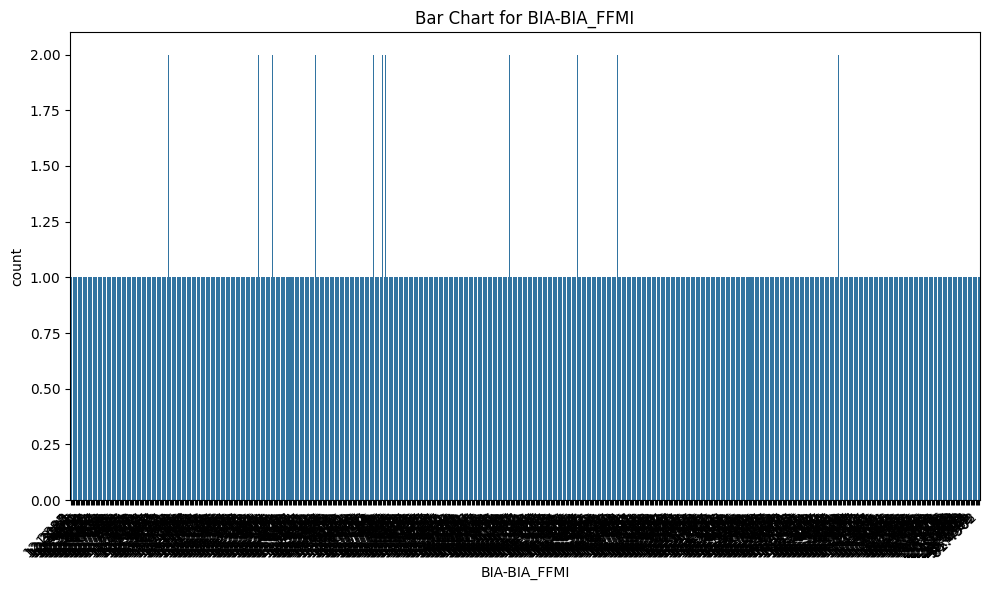

Frequency Counts for BIA-BIA_FMI:
BIA-BIA_FMI
 4.220330     1
 3.882060     1
 1.614550     1
 4.914860     1
 2.451580     1
 10.192600    1
 3.740250     1
 1.911560     1
 3.108490     1
 2.438340     1
 4.040310     1
 4.588640     1
 2.805400     1
 2.794570     1
 3.099400     1
 3.090560     1
 4.588050     1
 0.109639     1
 9.314270     1
 4.897480     1
 1.234970     1
 2.612230     1
 6.843320     1
 7.303870     1
 5.656850     1
 17.016600    1
 7.190610     1
 11.528600    1
 3.091900     1
 4.575560     1
 4.846130     1
 3.262680     1
 3.970520     1
 1.574340     1
 2.136820     1
 2.692910     1
 3.839040     1
 5.334290     1
 2.558950     1
 5.491160     1
 5.257420     1
 5.265020     1
 4.188590     1
 2.894990     1
 8.306030     1
 10.935400    1
 2.974440     1
 2.069940     1
 2.323090     1
 1.394830     1
 3.798090     1
 5.532510     1
 8.765000     1
 12.096400    1
 1.677590     1
 5.216060     1
 4.831770     1
 2.762440     1
 1.124480     1
 3.857580 

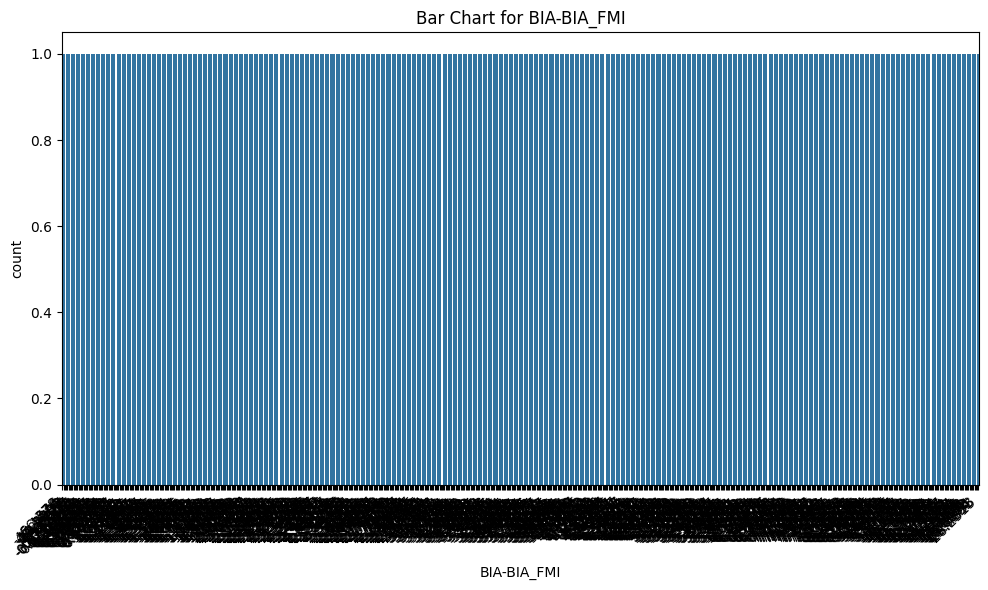

Frequency Counts for BIA-BIA_Fat:
BIA-BIA_Fat
 18.824300     1
 23.328500     1
 6.450590      1
 24.333900     1
 12.553000     1
 48.768400     1
 15.801200     1
 6.527940      1
 17.548000     1
 13.984200     1
 16.757100     1
 28.000400     1
 16.988400     1
 9.936920      1
 9.946310      1
 11.772100     1
 19.028900     1
 0.948752      1
 79.570100     1
 21.844700     1
 3.880150      1
 7.523730      1
 39.868000     1
 28.090300     1
 24.338700     1
 62.952100     1
 32.073000     1
 67.163700     1
 15.699900     1
 18.280700     1
 22.003400     1
 9.397170      1
 17.710100     1
 5.213020      1
 11.309000     1
 10.396700     1
 25.248600     1
 23.793000     1
 8.918050      1
 44.225700     1
 20.219800     1
 32.620100     1
 22.900700     1
 8.712850      1
 41.123900     1
 61.146000     1
 11.003800     1
 6.095060      1
 9.634990      1
 5.160120      1
 20.101200     1
 22.523100     1
 61.086500     1
 86.730400     1
 6.957780      1
 29.445700     1
 2

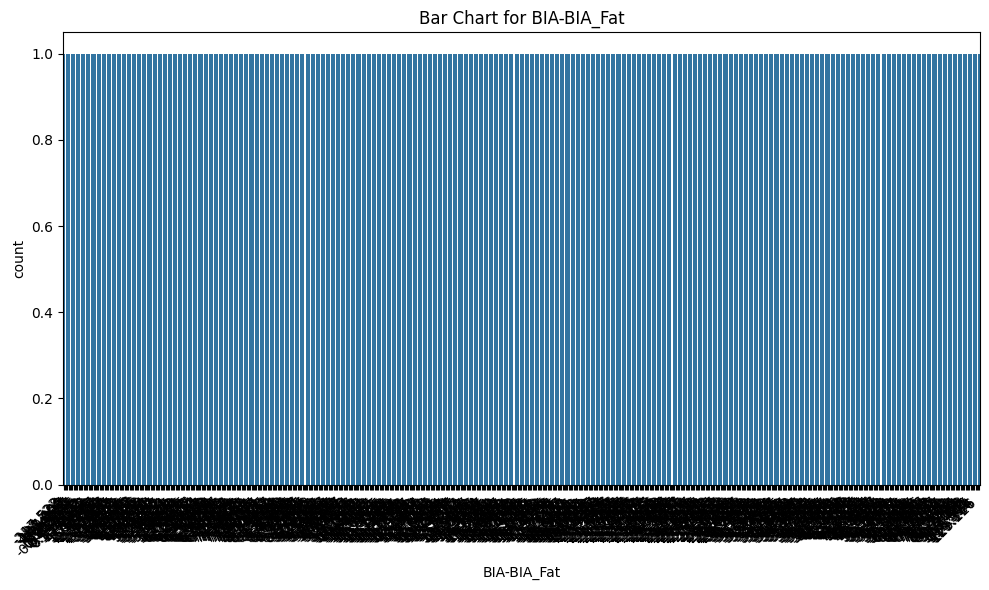

Frequency Counts for BIA-BIA_Frame_num:
BIA-BIA_Frame_num
2.0    350
1.0    285
3.0    102
Name: count, dtype: int64



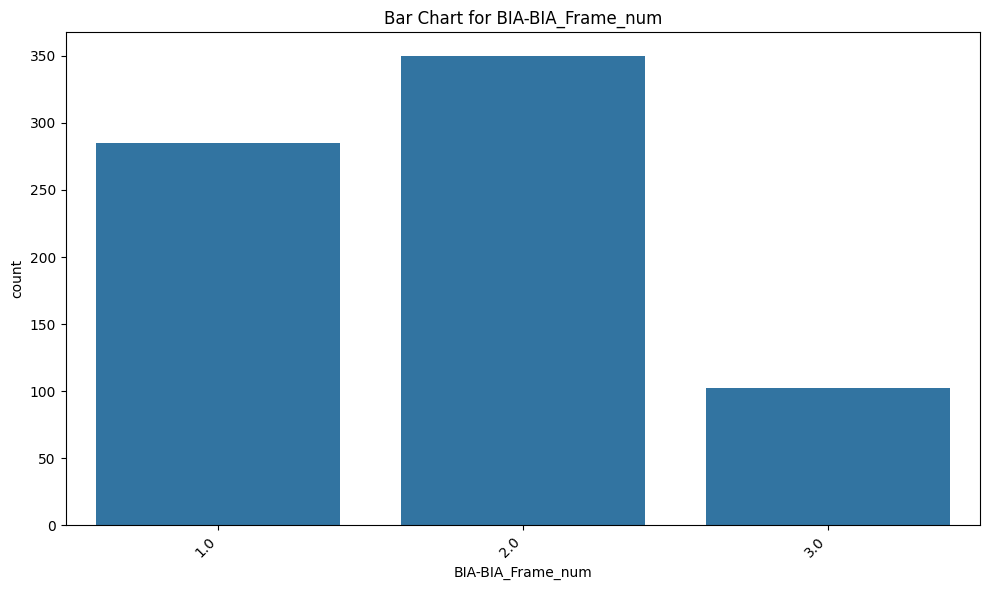

Frequency Counts for BIA-BIA_ICW:
BIA-BIA_ICW
30.4041     1
39.5525     1
25.3640     1
33.9849     1
29.1548     1
37.5654     1
25.5753     1
21.3367     1
37.2798     1
31.9712     1
33.4215     1
40.2169     1
39.3698     1
25.2061     1
23.8008     1
24.8720     1
26.6629     1
69.1498     1
69.9321     1
27.5574     1
22.9731     1
22.2232     1
51.0673     1
31.6621     1
30.1342     1
27.1562     1
34.6444     1
37.1728     1
25.6016     1
28.0667     1
29.0163     1
21.9627     1
29.7758     1
20.4583     1
32.2204     1
25.4603     1
56.1538     1
31.0472     1
22.7626     1
58.3325     1
26.7206     1
46.6454     1
35.9116     1
25.9668     1
38.0521     1
33.1096     1
25.0089     1
20.0914     1
27.9421     1
23.8035     1
26.7165     1
27.2056     1
55.0141     1
43.3868     1
27.0950     1
30.8386     1
36.5475     1
43.1726     1
19.6498     1
51.2487     1
28.5712     1
21.6668     1
31.8627     1
56.7829     1
38.1011     1
22.6682     1
31.9733     1
22.6224     1
26

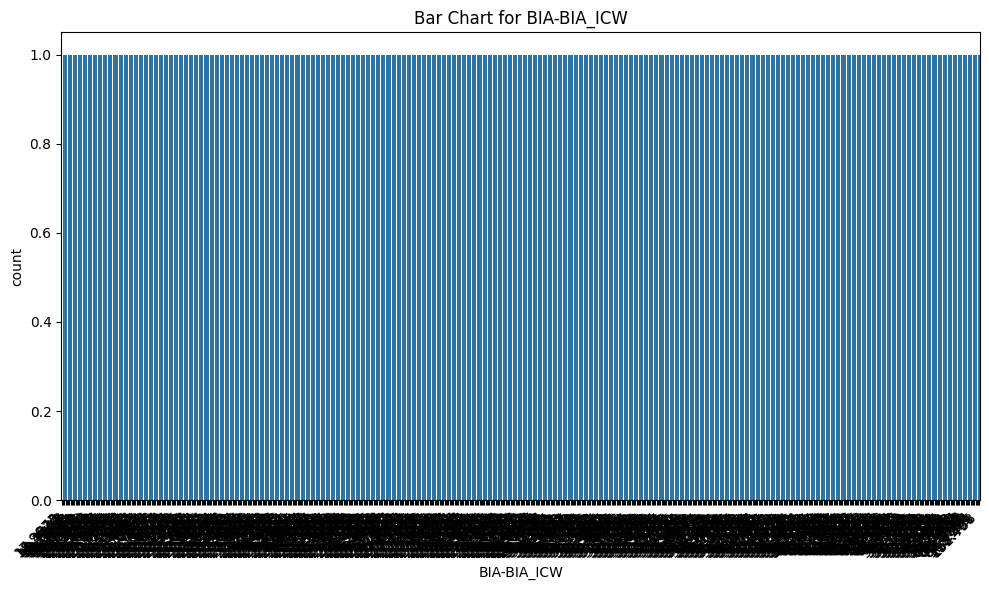

Frequency Counts for BIA-BIA_LDM:
BIA-BIA_LDM
19.70270    2
11.01950    2
16.77900    1
12.91610    1
21.14900    1
14.80280    1
12.79940    1
21.33950    1
22.47540    1
14.42170    1
23.62020    1
24.57010    1
12.15080    1
10.65820    1
19.27540    1
18.63020    1
42.17290    1
47.27420    1
15.49040    1
10.79300    1
9.30636     1
22.94620    1
17.71820    1
15.30770    1
10.67520    1
17.52690    1
19.62290    1
15.52140    1
21.00290    1
10.14130    1
17.03370    1
12.74890    1
18.37660    1
16.37950    1
30.39780    1
11.00240    1
26.80570    1
37.96900    1
16.41840    1
26.44370    1
21.22940    1
8.27870     1
21.02690    1
14.41900    1
17.22360    1
14.28400    1
16.69400    1
15.22110    1
17.78920    1
10.61550    1
20.39780    1
13.27270    1
34.25330    1
33.28330    1
14.36270    1
21.18490    1
21.17490    1
26.77610    1
11.32840    1
29.96990    1
14.45010    1
9.81709     1
17.75440    1
31.29520    1
19.66020    1
11.54480    1
19.97640    1
9.40808     1
14

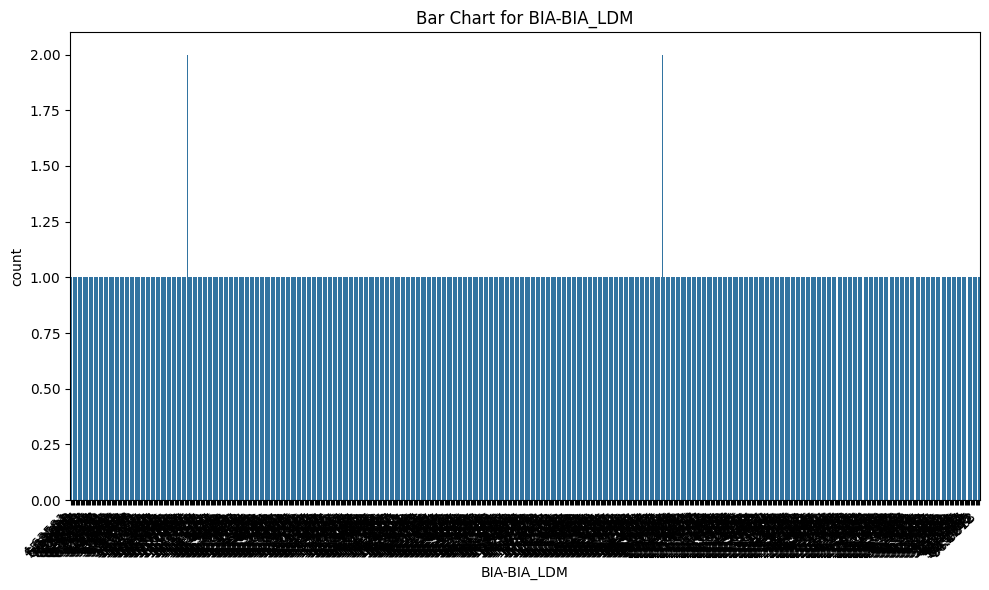

Frequency Counts for BIA-BIA_LST:
BIA-BIA_LST
58.9338     1
86.3237     1
47.0990     1
66.0866     1
65.0442     1
78.6513     1
50.6102     1
43.1926     1
75.3592     1
66.8964     1
58.6732     1
85.6071     1
81.2608     1
44.2818     1
40.8877     1
49.6416     1
52.6898     1
151.5900    1
163.9240    1
59.3712     1
37.4780     1
35.9887     1
103.3730    1
55.2448     1
58.0265     1
60.0689     1
66.5381     1
93.8444     1
60.2910     1
52.1696     1
57.2523     1
31.9626     1
57.5124     1
42.0050     1
75.6720     1
46.9295     1
122.3840    1
60.1954     1
45.0079     1
132.4510    1
50.4527     1
96.7735     1
73.6474     1
38.6229     1
77.7489     1
81.7199     1
45.6863     1
38.5612     1
51.8122     1
43.6255     1
60.8618     1
56.2763     1
121.7090    1
115.0910    1
50.5127     1
72.9208     1
75.1725     1
92.7530     1
27.0624     1
110.5670    1
60.0603     1
41.1591     1
61.4091     1
122.6990    1
75.8443     1
38.1753     1
77.1309     1
36.6696     1
41

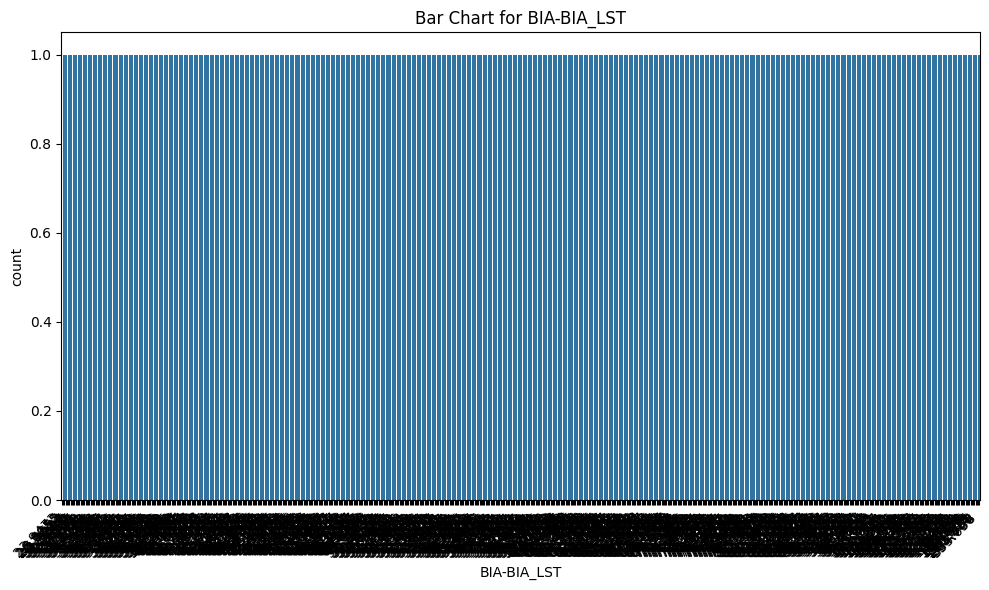

Frequency Counts for BIA-BIA_SMM:
BIA-BIA_SMM
26.4798     1
39.4713     1
22.3233     1
32.5442     1
29.8789     1
31.5330     1
26.2665     1
19.1349     1
38.2516     1
30.8516     1
38.4363     1
39.0066     1
40.7209     1
21.7347     1
16.6334     1
24.2108     1
24.5205     1
94.9387     1
80.7192     1
28.4069     1
19.8577     1
15.4432     1
68.1881     1
27.2900     1
27.7789     1
27.3041     1
34.7419     1
43.9592     1
25.1649     1
25.7503     1
35.1169     1
14.8522     1
26.7734     1
16.6164     1
35.5676     1
26.5768     1
77.1449     1
28.6640     1
19.2286     1
65.5393     1
24.4443     1
54.1751     1
34.2069     1
24.9788     1
35.7536     1
36.1893     1
28.7976     1
16.5294     1
23.8034     1
18.8143     1
27.0870     1
25.3593     1
62.1484     1
52.8042     1
22.0614     1
33.3375     1
34.1779     1
44.6593     1
12.5903     1
57.4125     1
31.6521     1
18.0594     1
31.4218     1
64.7094     1
38.1995     1
18.3895     1
34.0750     1
16.2754     1
25

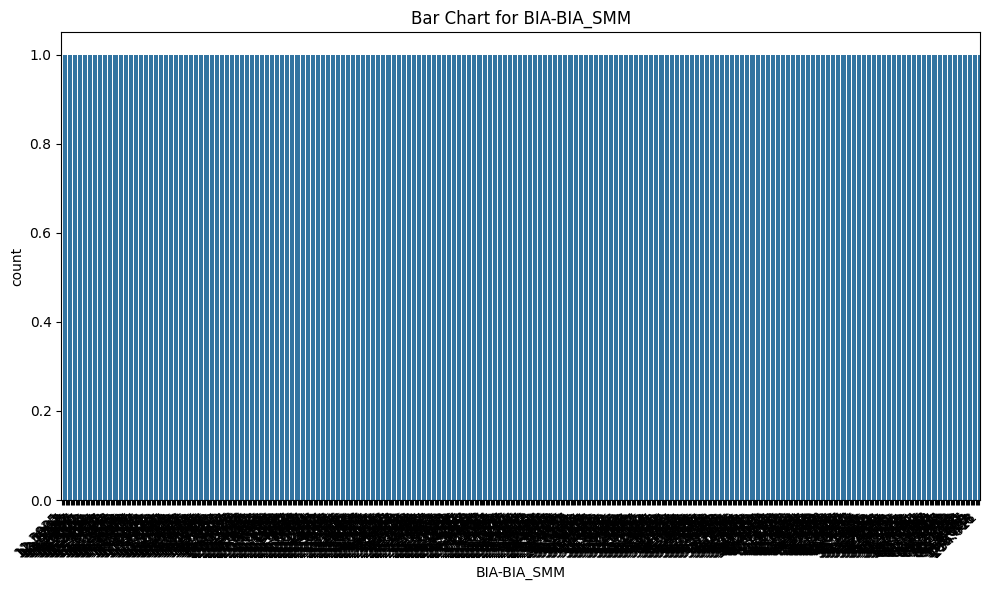

Frequency Counts for BIA-BIA_TBW:
BIA-BIA_TBW
45.9966     1
64.6513     1
35.0417     1
52.5906     1
51.5288     1
61.8825     1
42.3959     1
32.8726     1
59.1125     1
49.1403     1
48.0212     1
66.6295     1
63.7192     1
34.3470     1
32.9955     1
40.4771     1
37.3409     1
119.2780    1
125.9560    1
47.4649     1
29.3268     1
29.1699     1
81.5263     1
48.0256     1
44.4377     1
48.6288     1
52.7378     1
71.9229     1
44.4771     1
39.9979     1
39.7937     1
28.8615     1
44.2562     1
31.6381     1
57.3144     1
33.6238     1
91.3536     1
46.4801     1
36.6796     1
102.8050    1
37.1618     1
76.3362     1
57.2700     1
34.0084     1
61.2491     1
63.5078     1
31.9022     1
30.0298     1
40.8597     1
32.5503     1
47.1010     1
47.6042     1
94.4602     1
88.5864     1
39.6795     1
56.3694     1
58.8322     1
72.3818     1
24.3752     1
87.5079     1
49.0168     1
33.7237     1
47.9393     1
97.5550     1
61.2659     1
29.2457     1
61.1806     1
29.8061     1
34

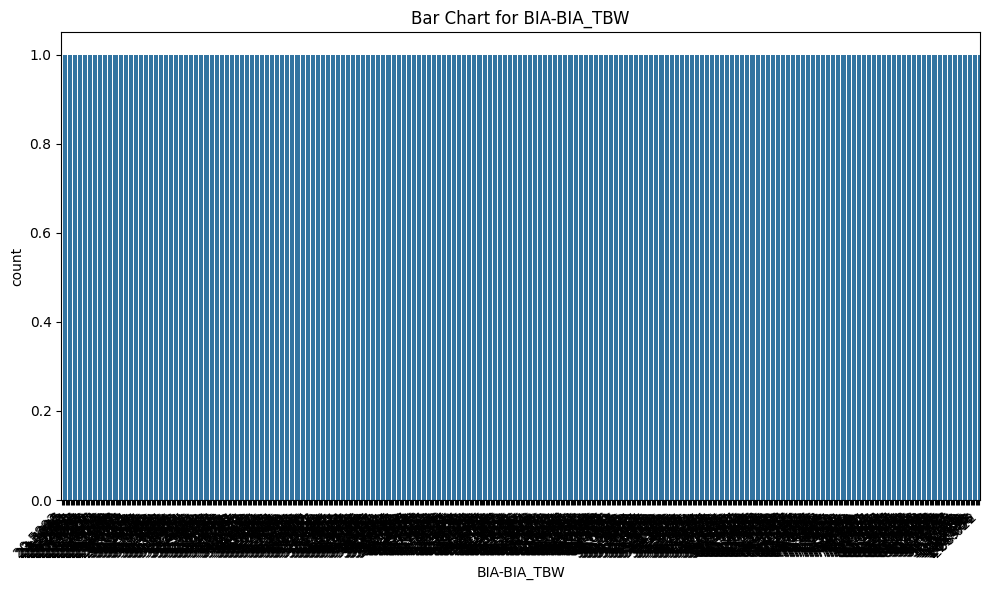

In [106]:
# Generate frequency counts and bar charts for bioelectric impedence data

# List of fields to analyze
fields = ['BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat',
       'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()

#### Physical Activity Data

Frequency Counts for PAQ_A-Season:
PAQ_A-Season
Winter    40
Spring    36
Summer    34
Fall      27
Name: count, dtype: int64



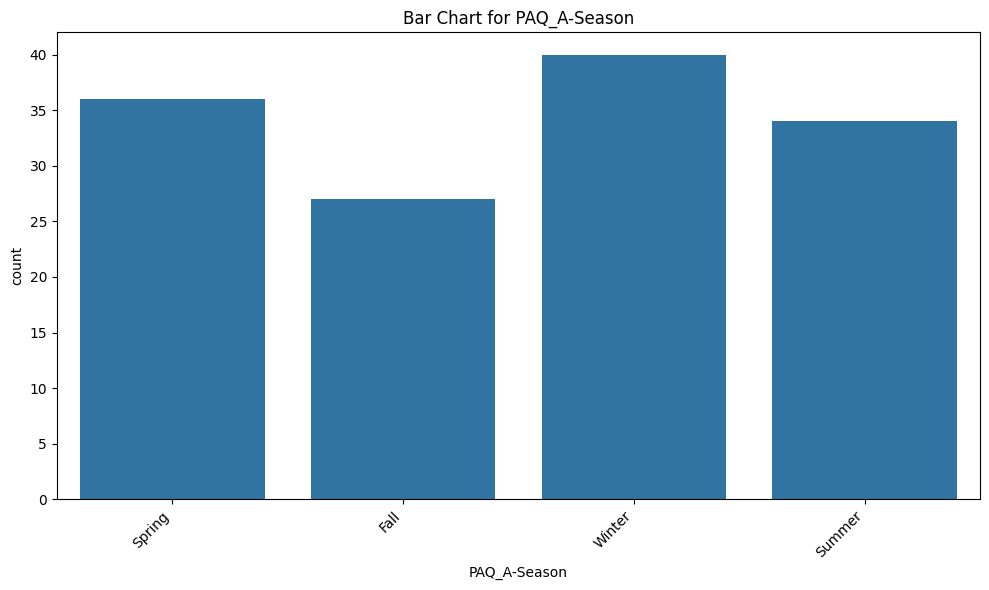

Frequency Counts for PAQ_A-PAQ_A_Total:
PAQ_A-PAQ_A_Total
1.490    3
0.990    3
2.600    3
1.770    3
1.700    2
1.560    2
2.130    2
1.200    2
1.140    2
1.380    2
1.500    2
2.010    2
1.830    2
3.470    2
2.910    2
2.320    2
1.110    2
1.630    2
2.270    2
2.780    2
1.030    1
1.570    1
2.630    1
2.720    1
3.600    1
2.880    1
1.580    1
2.560    1
4.309    1
2.700    1
2.330    1
1.410    1
3.310    1
2.140    1
2.080    1
3.050    1
3.460    1
2.171    1
2.310    1
1.080    1
3.060    1
2.460    1
3.140    1
1.960    1
1.120    1
4.110    1
2.480    1
1.450    1
2.550    1
2.170    1
1.250    1
2.190    1
2.660    1
1.860    1
1.440    1
3.379    1
1.551    1
1.810    1
1.970    1
1.000    1
3.000    1
2.070    1
2.820    1
1.310    1
2.250    1
2.670    1
4.540    1
1.160    1
2.280    1
1.520    1
1.900    1
2.620    1
4.420    1
3.020    1
1.670    1
1.710    1
4.000    1
3.510    1
1.850    1
2.100    1
0.660    1
2.160    1
3.380    1
2.040    1
1.620    1
1.730  

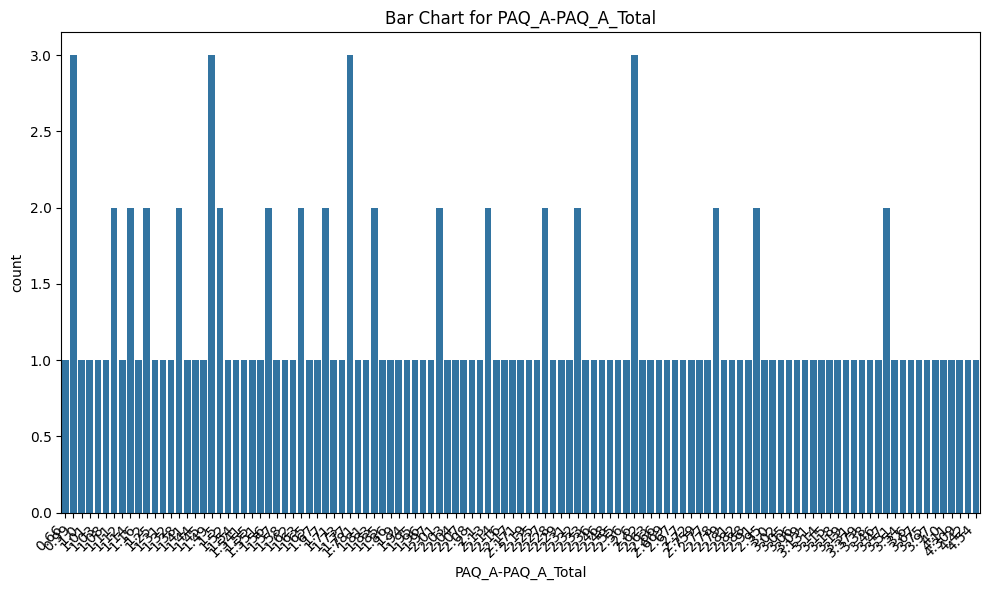

Frequency Counts for PAQ_C-Season:
PAQ_C-Season
Winter    156
Spring    139
Summer    123
Fall      119
Name: count, dtype: int64



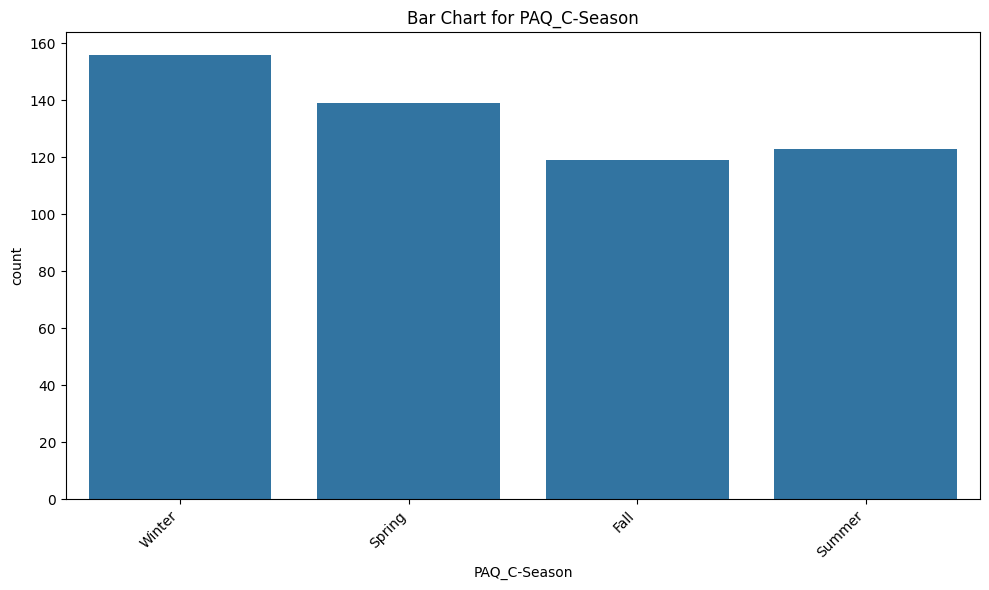

Frequency Counts for PAQ_C-PAQ_C_Total:
PAQ_C-PAQ_C_Total
2.120    7
2.080    7
2.460    5
2.280    5
2.910    5
3.010    5
2.830    5
2.330    5
3.200    5
2.390    5
1.680    5
2.510    5
2.350    5
2.320    5
2.760    4
3.890    4
3.090    4
2.430    4
1.590    4
2.210    4
2.270    4
2.670    4
2.950    4
1.860    4
2.720    4
3.150    4
2.140    4
0.990    4
2.050    4
2.060    4
3.240    4
1.890    4
2.880    4
1.430    4
2.520    4
2.790    3
3.410    3
1.400    3
2.250    3
2.970    3
3.160    3
2.480    3
2.590    3
3.390    3
3.300    3
1.820    3
2.750    3
2.340    3
2.650    3
1.830    3
2.500    3
1.790    3
3.270    3
1.880    3
3.280    3
2.240    3
2.640    3
1.720    3
2.560    3
2.610    3
3.070    3
1.610    3
3.110    3
3.020    3
1.940    3
1.810    3
1.450    3
2.290    3
2.860    3
2.380    3
3.190    3
2.420    3
1.690    3
3.040    2
1.560    2
2.130    2
1.510    2
2.920    2
2.840    2
1.870    2
2.490    2
2.680    2
2.370    2
3.340    2
3.170    2
2.820  

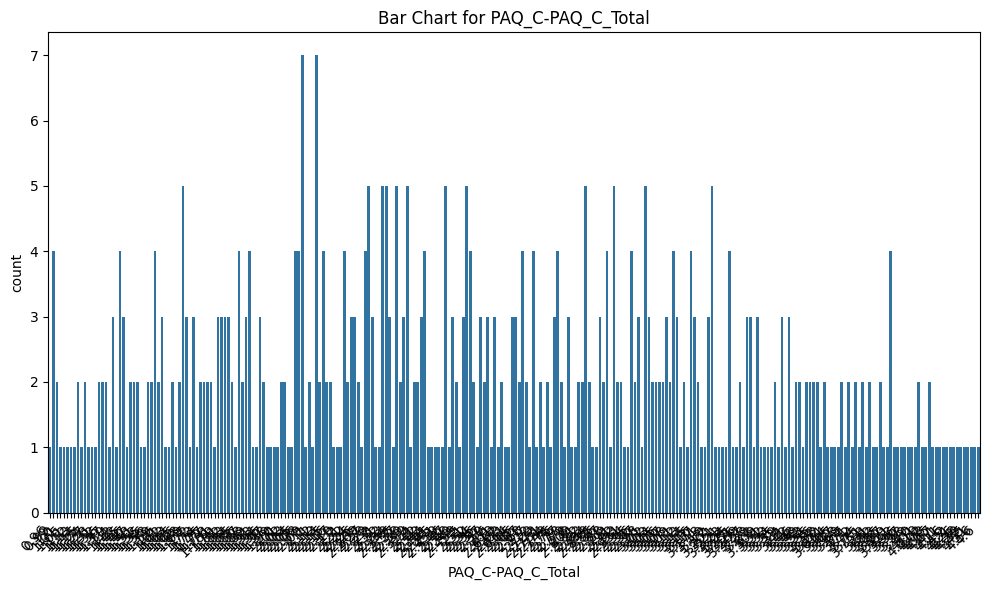

In [107]:
# Generate frequency counts and bar charts for physical activity

# List of fields to analyze
fields = ['PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C_Total']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()


#### Sleep Disturbance Data


Frequency Counts for SDS-Season:
SDS-Season
Winter    261
Spring    218
Summer    210
Fall      207
Name: count, dtype: int64



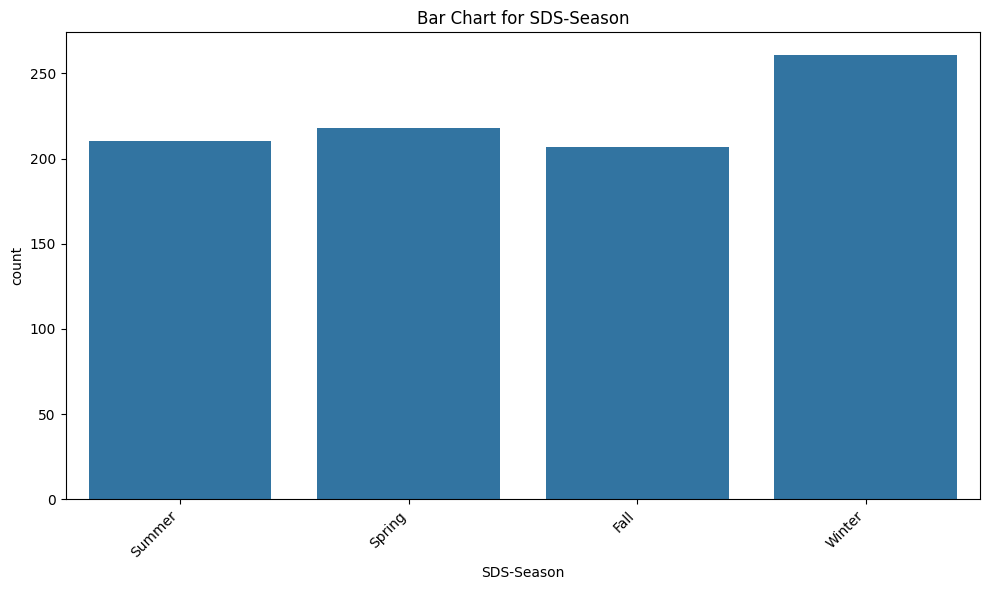

Frequency Counts for SDS-SDS_Total_Raw:
SDS-SDS_Total_Raw
34.0    47
37.0    46
35.0    43
33.0    42
40.0    38
31.0    38
32.0    36
30.0    36
39.0    35
41.0    34
38.0    32
36.0    32
42.0    31
28.0    30
44.0    29
43.0    28
45.0    27
29.0    26
51.0    23
46.0    22
50.0    20
27.0    17
52.0    16
47.0    16
48.0    13
53.0    12
49.0    11
54.0    10
56.0    10
26.0    10
65.0     9
55.0     9
59.0     8
57.0     8
61.0     7
58.0     7
60.0     5
62.0     4
70.0     3
25.0     2
63.0     2
73.0     2
74.0     2
66.0     2
67.0     2
75.0     2
64.0     2
80.0     2
76.0     2
68.0     1
79.0     1
69.0     1
77.0     1
71.0     1
82.0     1
Name: count, dtype: int64



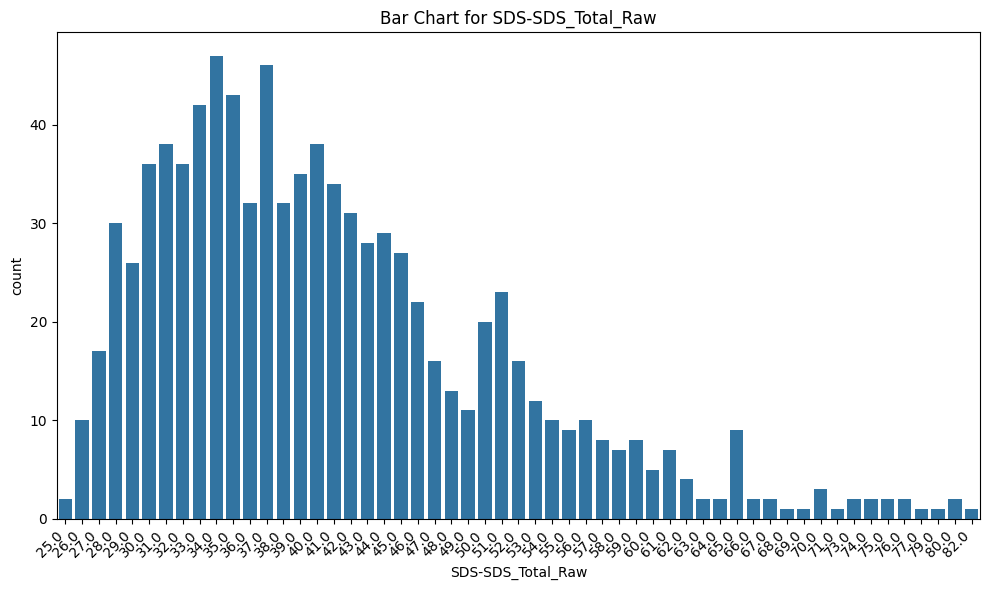

Frequency Counts for SDS-SDS_Total_T:
SDS-SDS_Total_T
49.0     47
53.0     46
50.0     43
47.0     42
45.0     38
56.0     38
43.0     36
46.0     36
55.0     35
58.0     34
54.0     32
51.0     32
59.0     31
41.0     30
62.0     29
60.0     28
63.0     27
42.0     26
71.0     23
64.0     22
69.0     20
40.0     17
66.0     16
72.0     16
67.0     13
38.0     12
73.0     12
68.0     11
100.0    11
77.0     10
75.0     10
76.0      9
89.0      9
81.0      8
79.0      8
84.0      7
80.0      7
82.0      5
85.0      4
95.0      3
88.0      2
99.0      2
86.0      2
90.0      2
91.0      2
97.0      1
94.0      1
93.0      1
Name: count, dtype: int64



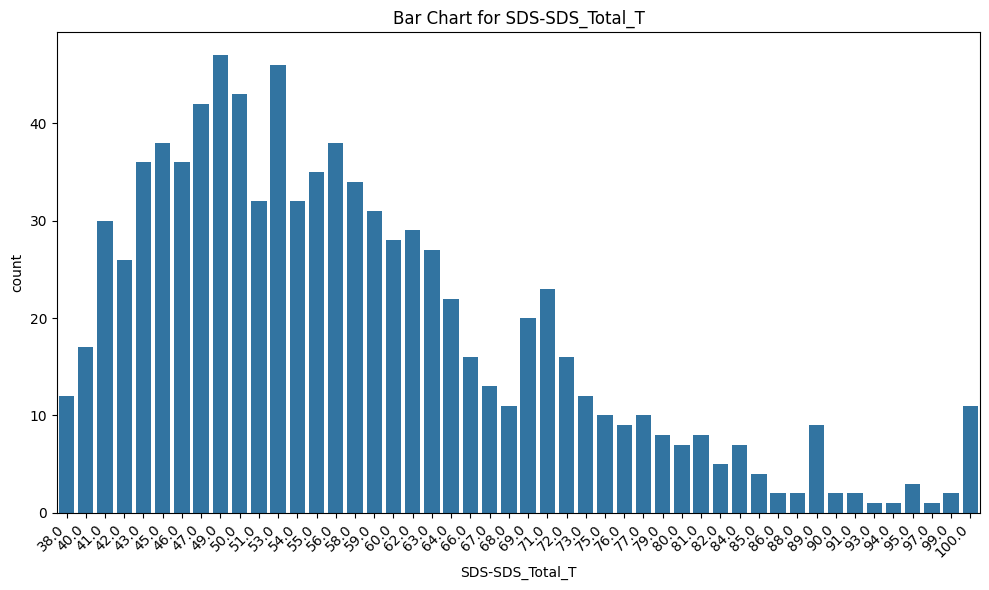

In [108]:
# Generate frequency counts and bar charts for sleep disturbance data

# List of fields to analyze
fields = ['SDS-Season', 'SDS-SDS_Total_Raw', 'SDS-SDS_Total_T']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()

#### Internet Use Data


Frequency Counts for PreInt_EduHx-Season:
PreInt_EduHx-Season
Fall      272
Spring    258
Summer    249
Winter    215
Name: count, dtype: int64



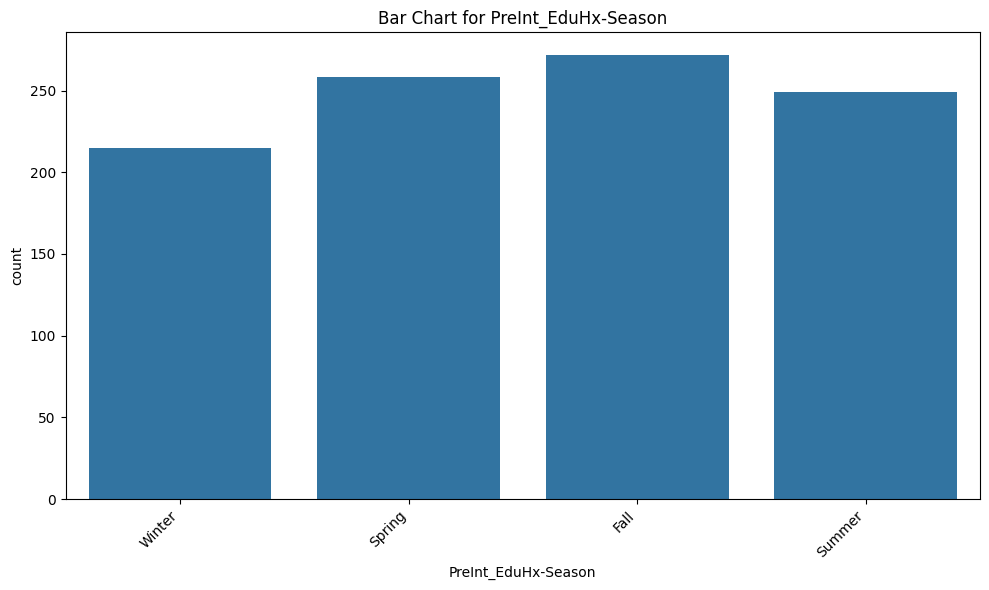

Frequency Counts for PreInt_EduHx-computerinternet_hoursday:
PreInt_EduHx-computerinternet_hoursday
0.0    476
2.0    290
1.0    117
3.0    102
Name: count, dtype: int64



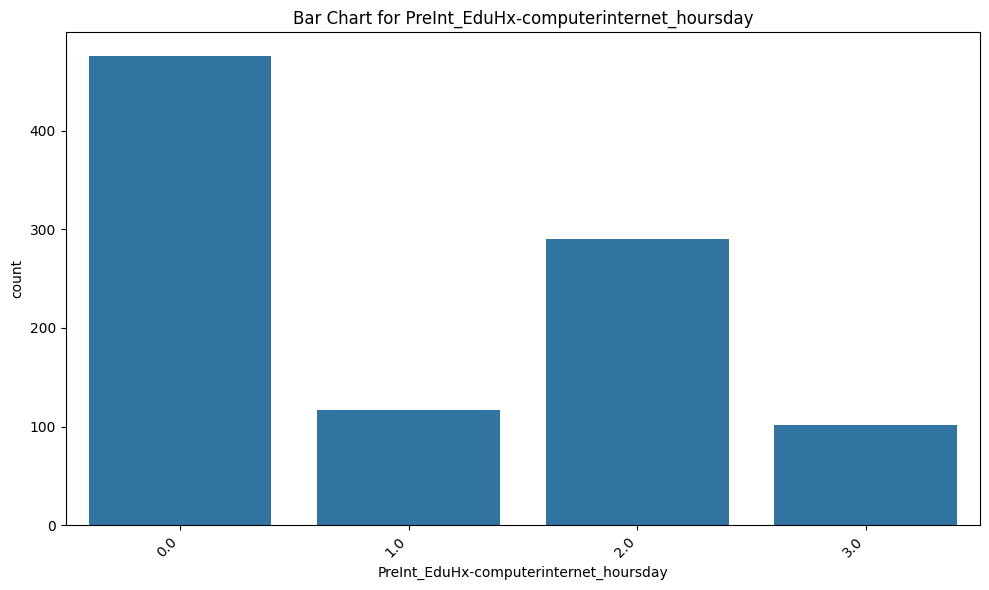

In [109]:
# Generate frequency counts and bar charts for internet use  data

# List of fields to analyze
fields = ['PreInt_EduHx-Season', 'PreInt_EduHx-computerinternet_hoursday']

# Generate frequency counts and bar charts for each field
for field in fields:
  print(f"Frequency Counts for {field}:\n{train_df[field].value_counts()}\n")

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed
  sns.countplot(data=train_df, x=field)
  plt.title(f"Bar Chart for {field}")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
  plt.tight_layout()
  plt.show()

### Drop Demographic Features (996, 29)

Continue to reduce features in the demographic dataset, based on demographic data subset analysis above.


In [110]:
# Continue to reduce features in the demographic dataset,
# based on demographic data subset analysis above.
#combined_df_temp = combined_df.drop(columns=['Physical-Height', 'Physical-Weight','Physical-Waist_Circumference','Fitness_Endurance-Max_Stage',
train_df = train_df.drop(columns=['Physical-Height', 'Physical-Weight','Physical-Waist_Circumference','Fitness_Endurance-Max_Stage',
                                                            'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                                                            'FGC-FGC_CU','FGC-FGC_GSND','FGC-FGC_GSD','FGC-FGC_PU',
                                                            'FGC-FGC_SRL', 'FGC-FGC_SRR','FGC-FGC_TL', 'BIA-BIA_FFM',
                                                            'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                                                            'PAQ_A-PAQ_A_Total', 'Basic_Demos-Enroll_Season', 'PAQ_C-PAQ_C_Total',
                                                            'SDS-SDS_Total_Raw','PAQ_A-Season','Fitness_Endurance-Season',
                                                            'PAQ_C-Season', 'BIA-Season','SDS-Season', 'CGAS-Season','FGC-Season',
                                                            'Physical-Season', 'PreInt_EduHx-Season', 'FGC-FGC_GSND_Zone' , 'FGC-FGC_GSD_Zone'])

# Check work
print("train_df shape after dropping demo columns:", train_df.shape)
train_df.columns
# good shape (996, 29)

train_df shape after dropping demo columns: (996, 29)


Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
       'sii'],
      dtype='object')

### Missing Values

Refresh train_df, examine missing values before recoding variables. Fill missing values with zero before recoding to integers.

In [111]:
# Refresh train_df, examine missing values, sorted descending
missing_values = train_df.isnull().sum().sort_values(ascending=False)#
# Print only where missing values > 0
print(missing_values[missing_values > 0])

# many missing values but better than before features were dropped

FGC-FGC_SRL_Zone                          314
FGC-FGC_SRR_Zone                          313
FGC-FGC_PU_Zone                           312
FGC-FGC_CU_Zone                           311
FGC-FGC_TL_Zone                           310
BIA-BIA_BMI                               259
BIA-BIA_LST                               259
BIA-BIA_LDM                               259
BIA-BIA_ICW                               259
BIA-BIA_FMI                               259
BIA-BIA_FFMI                              259
BIA-BIA_ECW                               259
BIA-BIA_DEE                               259
BIA-BIA_BMR                               259
BIA-BIA_BMC                               259
BIA-BIA_Activity_Level_num                259
BIA-BIA_TBW                               259
BIA-BIA_SMM                               259
SDS-SDS_Total_T                           100
CGAS-CGAS_Score                            42
Physical-Systolic_BP                       17
Physical-HeartRate                

In [112]:
# Fill remaining combined_df_temp variables with zero if null

train_df.fillna(0, inplace=True)
# Check work
missing_values = train_df.isnull().sum().sort_values(ascending=False)#
print(missing_values[missing_values > 0])

# no missing values


Series([], dtype: int64)


### Recode Physical Measures and Bioelectric Impedence Data

Physical_BMI, BIA-BIA_BMR, BIA-BIA_DEE, BIA-BIA_ECW, BIA-BIA_FFMI, BIA-BIA_ICW,
  'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM','BIA-BIA_TBW'

Recode (round to integer) physical measures (BMI) and bioelectric impedence data.

Background:
  * Underweight: BMI < 18.5
  * Normal weight: BMI 18.5–24.9
  * Overweight: BMI 25–29.9
  * Obesity: BMI ≥ 30
    * Class I (Moderate obesity): 30–34.9
    * Class II (Severe obesity): 35–39.9
    * Class III (Very severe or morbid obesity): BMI ≥ 40

In [113]:
# Recode (round to integer) physical measures (BMI)

train_df['Physical-BMI'] = train_df['Physical-BMI'].round().astype(int)
# Check work, value counts sorted ascending
train_df['Physical-BMI'].value_counts().sort_index()

Physical-BMI
0      12
9       1
11      1
12      1
13     13
14     65
15    117
16    133
17    116
18    104
19     76
20     67
21     43
22     49
23     32
24     34
25     25
26     23
27     16
28     11
29     10
30      9
31      5
32      5
33      6
34      6
35      3
36      1
37      3
38      1
39      2
40      2
42      1
43      1
45      2
Name: count, dtype: int64

In [114]:
# Recode (round to integer) bioelectric impedence data

fields = ['BIA-BIA_BMR','BIA-BIA_DEE','BIA-BIA_ECW','BIA-BIA_FFMI','BIA-BIA_ICW',
          'BIA-BIA_LDM','BIA-BIA_LST','BIA-BIA_SMM','BIA-BIA_TBW']
for field in fields:
# combined_df_temp[field] = combined_df_temp[field].round().astype(int)
 train_df[field] = train_df[field].round().astype(int)


### Recode Target Variable 'sii'

Recode target variable 'sii' such that anything >= 1.0 = 1.0.

In [115]:
# Check 'sii' values, recode >= 1.0 to 1.0
# Value counts for sii
print('sii before recoding \n', train_df['sii'].value_counts())

train_df['sii'] = train_df['sii'].apply(lambda x: 1.0 if x >= 1.0 else x)
print('\nsii after recoding \n',train_df['sii'].value_counts())#

sii before recoding 
 sii
0.0    583
1.0    266
2.0    137
3.0     10
Name: count, dtype: int64

sii after recoding 
 sii
0.0    583
1.0    413
Name: count, dtype: int64


In [116]:
# Refresh train_df
train_df.info()
# (996, 29)

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 3 to 3958
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      996 non-null    object 
 1   Basic_Demos-Age                         996 non-null    int64  
 2   Basic_Demos-Sex                         996 non-null    int64  
 3   CGAS-CGAS_Score                         996 non-null    float64
 4   Physical-BMI                            996 non-null    int64  
 5   Physical-Diastolic_BP                   996 non-null    float64
 6   Physical-HeartRate                      996 non-null    float64
 7   Physical-Systolic_BP                    996 non-null    float64
 8   FGC-FGC_CU_Zone                         996 non-null    float64
 9   FGC-FGC_PU_Zone                         996 non-null    float64
 10  FGC-FGC_SRL_Zone                        996 non-null    float64
 1

# EDA: Accelerometer Data

💚 Approach

1. Examine and visualize a sample series_train.parquet file.
2. We have a number of accelerometer feature datasets to potentially join with demographic data and model:
          a. MinFC_Results: These were generated for ALL time steps, but a small subset of features.
          b. SomeFC_Results: Contains SOME (a subset) of the efficient FC parameters on the downsampled data
          c. EfficientFC_Results: 995/996 files using a two min timeout and downsampling.


💚 Observations and Background
1. Step is simply increasing with each accelerator data gathering; not valuable?
2. Background on x,y,z, and ENMO:

ENMO is not redundant because it summarizes the information from X, Y, and Z accelerations in a way that makes it easier to track physical activity. The raw X, Y, and Z values give detailed information about the specific directions of movement, while ENMO (Euclidean Norm Minus One) provides a single scalar value that reflects the intensity of movement regardless of direction. ENMO is a derived metric used to quantify physical activity intensity from accelerometer data, specifically by capturing movement's magnitude while subtracting a baseline. ENMO is calculated by summing the squared acceleration of each of the three accelerometer axes at each time point (i.e. Euclidean Norm) and then subtracting the gravitational component.

Thus, ENMO is not practically redundant with the x,y,z values as it reflects intensity of motion.

3. 'anglez' reflects the angle of the arm relative to the horizontal plane, so may be important when alayzing activity
4. If an observation has non-wear flag = 1 (yes) for several periods, we should reconsider keeping that observation.
5. 'light' is ambient light, which may inform us about whether the activity is indoors or outdoors?
6. 'battery_voltage' looks to decrease over time; probably not a predictor we're interested in.
7. 'time_of_day' is the time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.

%H: Hour (00-23), 2 digits for the hour.
%M: Minute (00-59), 2 digits for the minute.
%S: Second (00-59), 2 digits for the second.
.%9f: Fractional seconds (nanoseconds, up to 9 digits after the decimal point).

8. 'day_of_week' and 'quarter' may show activity trends.
9. 'relative_date_PCIAT' indicates the number of days (integer) since the PCIAT test was administered; not valuable?

💚 Decision
1. Drop 'step', 'battery_voltage' and 'relative_date_PCIAT' features before modeling.

## Read Accelerometer Parquet Files



### Examine Distribution of Rows Across All Files

This timed out 11/21 after 20 min, has run before. Did rerun.
Commented out after running successfully during development.
Net net, each parquet id files has hundreds of thousands of observations, as you would expect given the acclerometer data gathering timeframe.

In [117]:
# # Define the directory where your parquet files are located
# parquet_dir = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet'

# # Initialize a list to store the number of rows in each parquet file
# row_counts = []

# # Iterate through the parquet files in the directory
# for root, _, files in os.walk(parquet_dir):
#     for file in files:
#         if file.endswith('.parquet'):
#             parquet_file_path = os.path.join(root, file)
#             try:
#                 # Load parquet data
#                 data = pq.read_table(parquet_file_path).to_pandas()
#                 # Add the number of rows to the list
#                 row_counts.append(len(data))
#             except Exception as e:
#                 print(f"Error processing {parquet_file_path}: {e}")

# # Create a boxplot of the row counts
# plt.figure(figsize=(10, 6))
# plt.boxplot(row_counts)
# plt.title('Distribution of Rows Across Parquet Files')
# plt.ylabel('Number of Rows')
# plt.show()

### Examine Sample Parquet File

In [118]:
# Refresh: examine a sample train parquet file
# id=00115b9f
parquet_file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=00115b9f/part-0.parquet'

try:
  # Load parquet data
  data = pq.read_table(parquet_file_path).to_pandas()

  # Display the head of the DataFrame
  print("Head of the DataFrame:")
  print(data.head())

  # Display the info of the DataFrame
  print("\nInfo of the DataFrame:")
  print(data.info())

except Exception as e:
  print(f"Error processing {parquet_file_path}: {e}")

# 'step' is dtype = uint32, meaning an unsigned integer that can only represent
# positive numbers and zero; 32 bit

Head of the DataFrame:
   step         X         Y         Z      enmo     anglez  non-wear_flag      light  \
0     0  0.021536  0.022214 -1.022370  0.022853 -88.280762            0.0  53.000000   
1     1  0.022005  0.022187 -1.019740  0.020231 -88.241707            0.0  51.666668   
2     2  0.022240  0.022005 -1.019401  0.019893 -88.170067            0.0  50.333332   
3     3  0.021589  0.022578 -1.018177  0.018667 -88.250031            0.0  50.500000   
4     4  0.022005  0.023763 -1.014323  0.016848 -88.130775            0.0  33.166668   

   battery_voltage     time_of_day  weekday  quarter  relative_date_PCIAT        id  
0      4188.000000  56940000000000        4        3                 41.0  00115b9f  
1      4188.166504  56945000000000        4        3                 41.0  00115b9f  
2      4188.333496  56950000000000        4        3                 41.0  00115b9f  
3      4188.500000  56955000000000        4        3                 41.0  00115b9f  
4      4181.000000

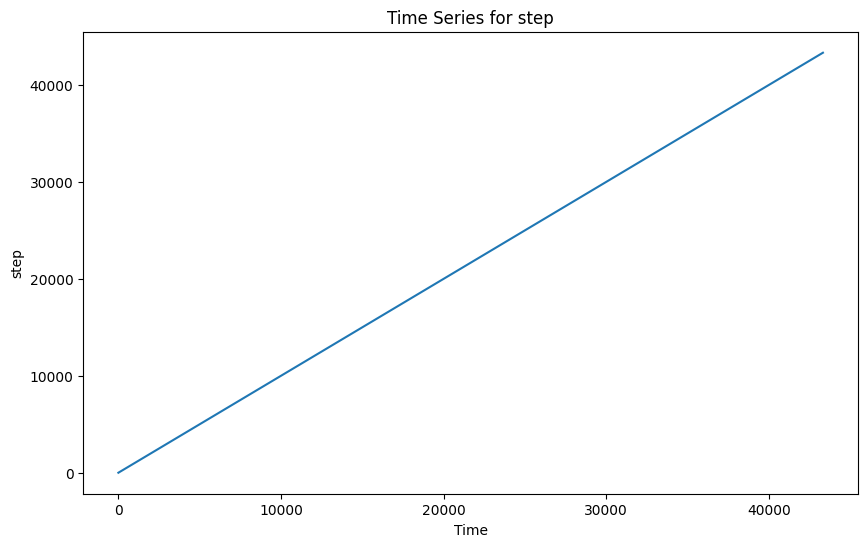

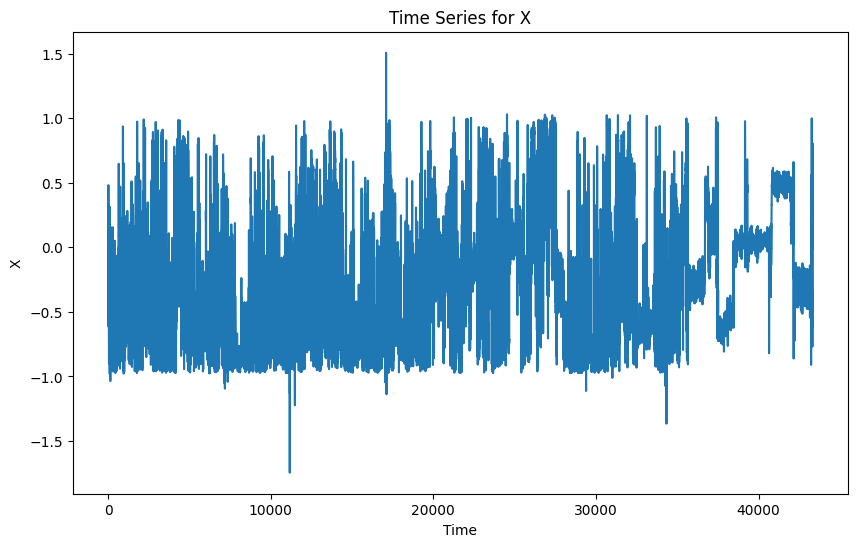

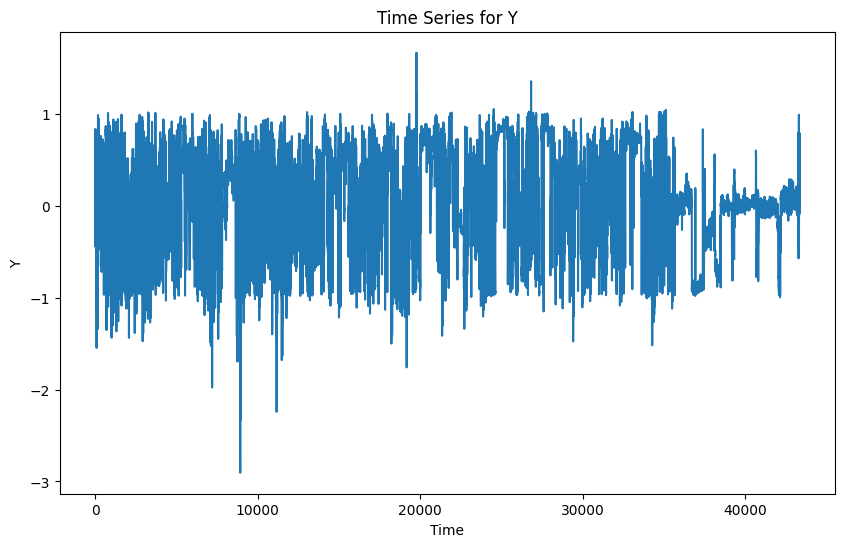

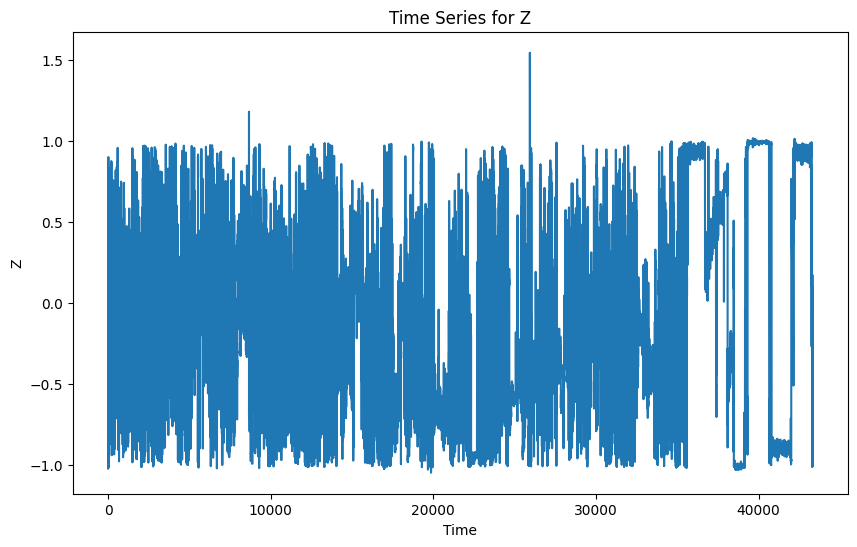

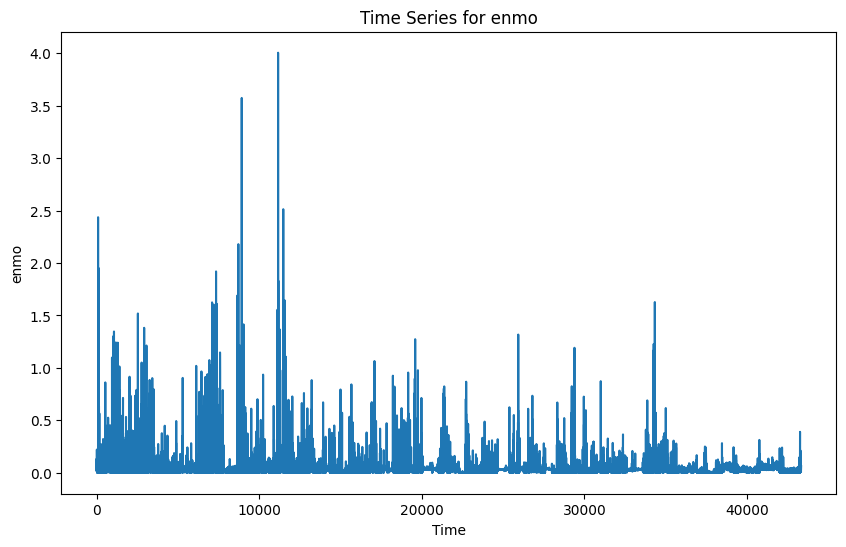

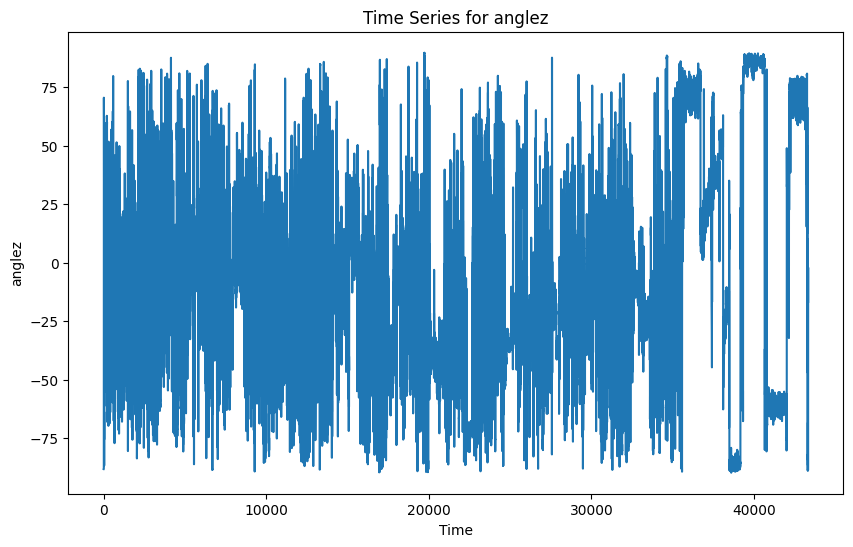

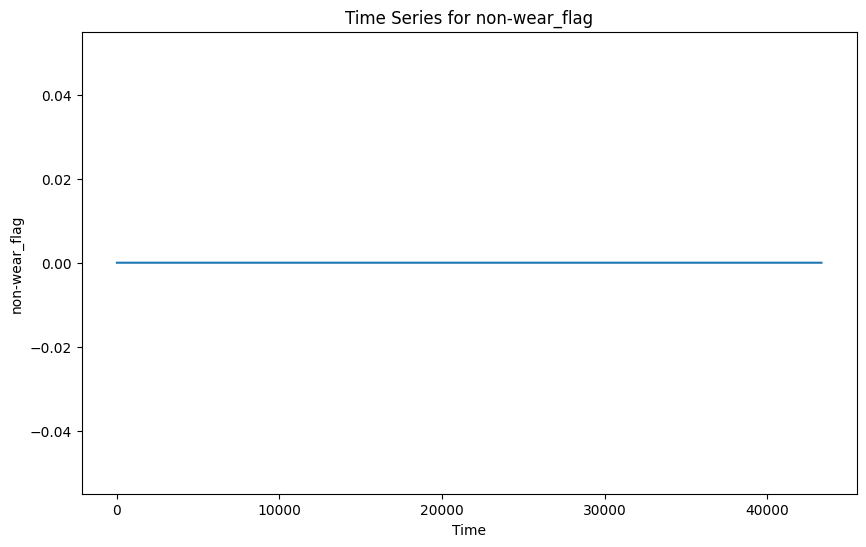

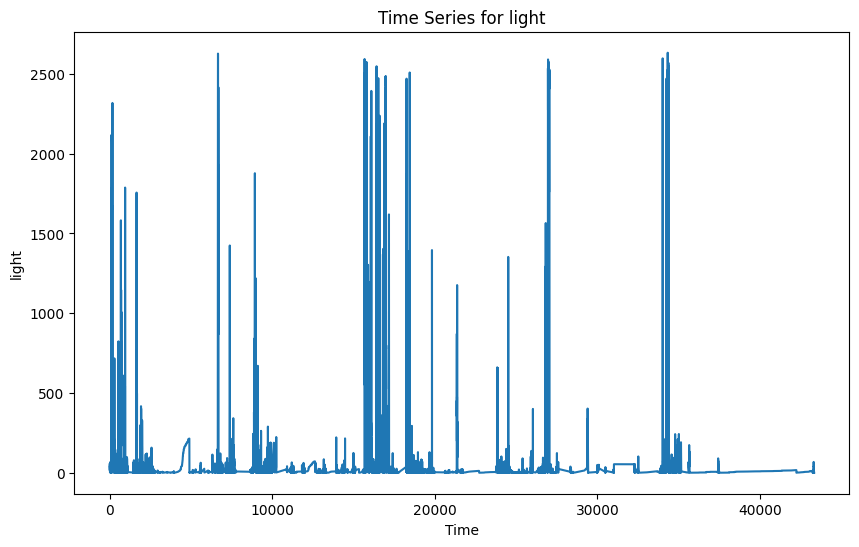

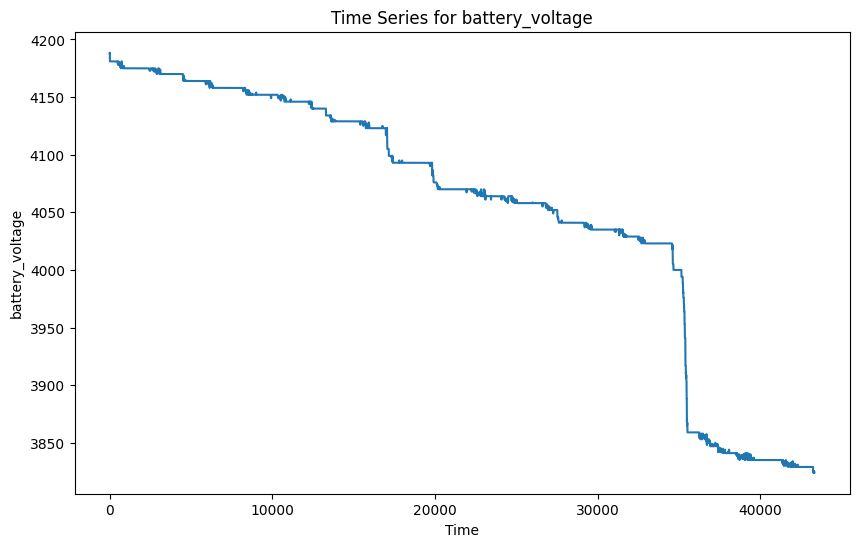

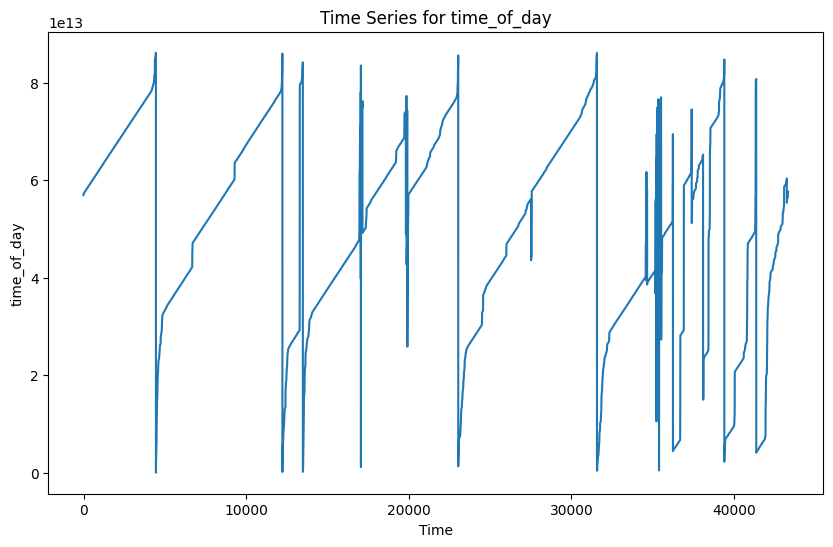

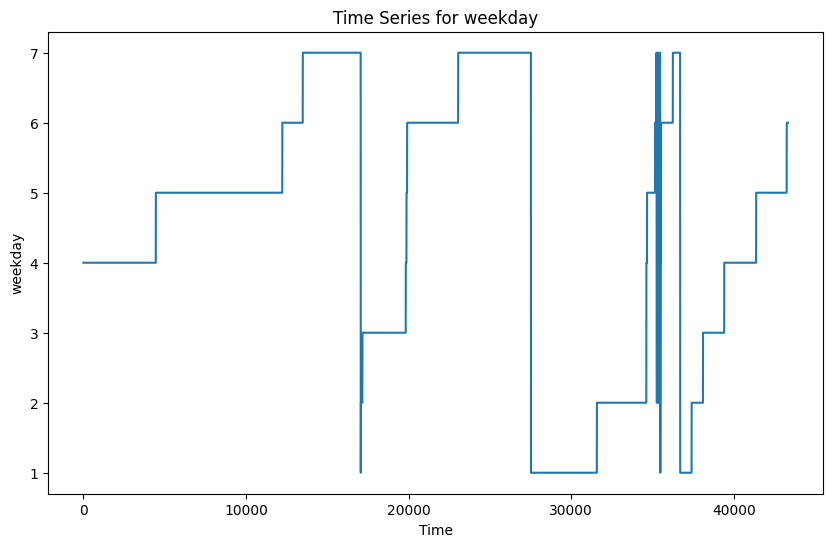

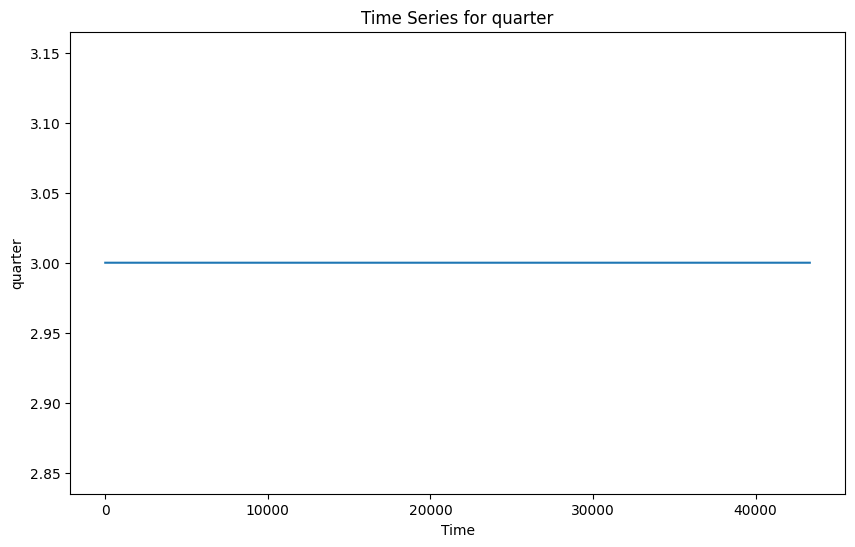

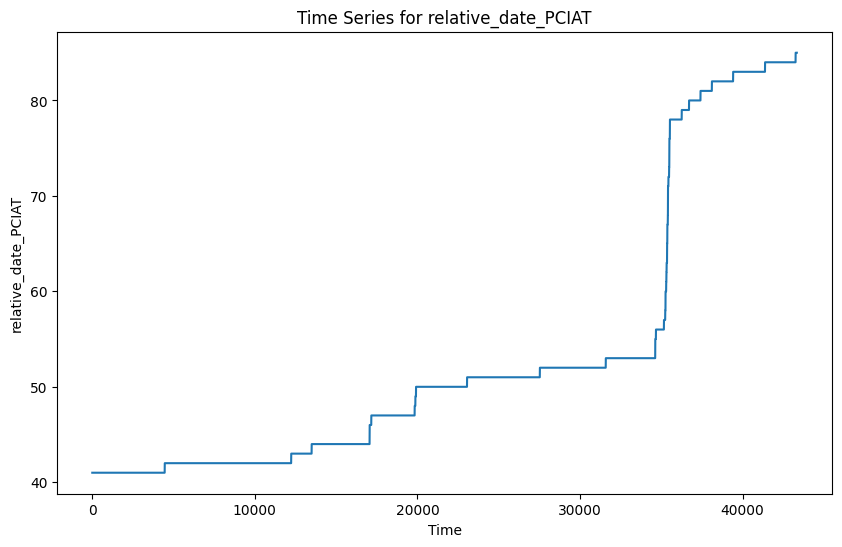

In [119]:
# Visualize sample time series data for 'id' = 00115b9f
# We would not want to do this for all 900+ parquet files

parquet_file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=00115b9f/part-0.parquet'

# The code is wrapped in a try-except block to catch any errors that might occur
# during file reading or processing. If an error happens, the code moves
# to the except block to handle it gracefully.
try:
  # Load parquet data to pandas df
  data = pq.read_table(parquet_file_path).to_pandas()

  # Iterate through columns and plot time series if they are numerical
  for column in data.columns:
# check if the column's data type is numerical
# only numerical data can be plotted as a time series
    if pd.api.types.is_numeric_dtype(data[column]):
      plt.figure(figsize=(10, 6))
# Plots the column values, treating each row as a time step
      plt.plot(data[column])
      plt.title(f"Time Series for {column}")
      plt.xlabel("Time")
      plt.ylabel(column)
      plt.show()

except Exception as e:
  print(f"Error processing {parquet_file_path}: {e}")


## Housekeeping Routines: Documentation, Future Use

Notebook location for documenting TSFresh and other routines that may be useful later.

### Using TSFresh To Extract Features For One 'id' (MinimalFCParameters)

Code kept for documentation and potential use later. Test reading a sample train parquet file and calling TSFresh for feature engineering before attempting to process all 'id's.

TSFresh generated (MinimalFCParameters):

Columns: 121 entries, X__sum_values to original_id

In [120]:
# TSFresh to extract features for one 'id'
series_train_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=00115b9f/part-0.parquet'

# Read the parquet file using pyarrow
table = pq.read_table(series_train_path)
df = table.to_pandas()

# Convert 'id' column to numeric using LabelEncoder (if you have multiple time series)
# encoder = LabelEncoder()
# df['id'] = encoder.fit_transform(df['id'])

# Ensure 'step' is sorted correctly (assuming it's the time step)
df = df.sort_values(by=['id', 'step'])

# Identify and convert non-numeric columns to numeric (exclude 'id', 'step', 'time_of_day')
for column in df.columns:
#  exclude columns as below PLUS 'battery_voltage' and 'relative_date_PCIAT'
#    if column not in ['step', 'time_of_day', 'id']:
    if column not in ['step', 'time_of_day', 'id', 'battery_voltage','relative_date_PCIAT']:
        try:
            df[column] = pd.to_numeric(df[column], errors='raise')  # Convert to numeric
        except ValueError:
            # If the column cannot be converted (e.g., actual string data), drop it
            print(f"Column '{column}' contains non-numeric values and will be excluded.")
            df = df.drop(columns=[column])

# Before extracting features, save the original 'id' values
original_ids = df['id'].unique()

# Extract features using TSFresh
settings = MinimalFCParameters()  # Use default feature extraction settings
df_tsfresh = extract_features(df, column_id='id', column_sort="step", default_fc_parameters=settings)

# Add a new column with the original 'id' values
df_tsfresh['original_id'] = original_ids

# Handle missing values (e.g., using imputation)
# df_tsfresh = impute(df_tsfresh)

# Print the extracted features
print(df_tsfresh.head())

# Columns: 121 entries, X__sum_values to original_id

Feature Extraction: 100%|██████████| 12/12 [00:00<00:00, 229.31it/s]

          X__sum_values  X__median   X__mean  X__length  X__standard_deviation  X__variance  \
00115b9f  -13708.897461  -0.366849 -0.316384    43330.0                0.45366     0.205807   

          X__root_mean_square  X__maximum  X__absolute_maximum  X__minimum  Y__sum_values  \
00115b9f             0.553087    1.507865             1.746094   -1.746094     693.661011   

          Y__median   Y__mean  Y__length  Y__standard_deviation  Y__variance  Y__root_mean_square  \
00115b9f   0.024974  0.016009    43330.0               0.502696     0.252704             0.502951   

          Y__maximum  Y__absolute_maximum  Y__minimum  anglez__sum_values  anglez__median  \
00115b9f    1.666354             2.905339   -2.905339       -458449.40625      -15.086617   

          anglez__mean  anglez__length  anglez__standard_deviation  anglez__variance  \
00115b9f    -10.580416         43330.0                   42.946674        1844.41687   

          anglez__root_mean_square  anglez__maximum  an

In [121]:
df_tsfresh.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 1 entries, 00115b9f to 00115b9f
Columns: 121 entries, X__sum_values to original_id
dtypes: category(1), float64(120)
memory usage: 1.2 KB


In [122]:
# show all df_tsfresh columns
all_columns = df_tsfresh.columns.to_list()
print(all_columns)

['X__sum_values', 'X__median', 'X__mean', 'X__length', 'X__standard_deviation', 'X__variance', 'X__root_mean_square', 'X__maximum', 'X__absolute_maximum', 'X__minimum', 'Y__sum_values', 'Y__median', 'Y__mean', 'Y__length', 'Y__standard_deviation', 'Y__variance', 'Y__root_mean_square', 'Y__maximum', 'Y__absolute_maximum', 'Y__minimum', 'anglez__sum_values', 'anglez__median', 'anglez__mean', 'anglez__length', 'anglez__standard_deviation', 'anglez__variance', 'anglez__root_mean_square', 'anglez__maximum', 'anglez__absolute_maximum', 'anglez__minimum', 'Z__sum_values', 'Z__median', 'Z__mean', 'Z__length', 'Z__standard_deviation', 'Z__variance', 'Z__root_mean_square', 'Z__maximum', 'Z__absolute_maximum', 'Z__minimum', 'non-wear_flag__sum_values', 'non-wear_flag__median', 'non-wear_flag__mean', 'non-wear_flag__length', 'non-wear_flag__standard_deviation', 'non-wear_flag__variance', 'non-wear_flag__root_mean_square', 'non-wear_flag__maximum', 'non-wear_flag__absolute_maximum', 'non-wear_flag_

### Using TSFresh To Extract Select Features For All id's

Code kept for documentation and potential use later.

    features_of_interest = {
        "mean": None,
        "median": None,
        "standard_deviation": None,
        "variance": None,
        "minimum": None,
        "maximum": None,
        "sum_values": None,
        "root_mean_square": None,
        "absolute_maximum": None,
        "length": None
        .....and whatever else; can also spec values
    }

COMMENT OUT TO PREVENT FROM RERUNNING UNNECESSARILY

In [123]:
# Extract select features for select columns in parquet files
# Define the directory containing your parquet files
# parquet_dir = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet'

# # List all parquet files in the directory and subdirectories
# parquet_files = []
# for root, dirs, files in os.walk(parquet_dir):
#     for file in files:
#         if file.endswith('.parquet'):
#             parquet_files.append(os.path.join(root, file))

# # Initialize an empty DataFrame to store all the extracted features
# extracted_features_df = pd.DataFrame()

# # Define the features of interest
# features_of_interest = {
#     "mean": None,
#     "median": None,
#     "standard_deviation": None,
#     "variance": None,
#     "minimum": None,
#     "maximum": None,
#     "sum_values": None,
#     "root_mean_square": None,
#     "absolute_maximum": None,
#     "length": None
# }

# # Define the columns you want to apply these features to
# columns_to_extract = ['X', 'Y', 'Z', 'enmo', 'anglez', 'non-wear_flag','light', 'weekday', 'quarter', 'relative_date_PCIAT']

# # Map each column to the selected features
# kind_to_fc_parameters = {
#     col: features_of_interest
#     for col in columns_to_extract
# }

# # Loop through all parquet files and process them
# for parquet_file in parquet_files:
#     print(f"Processing {parquet_file}...")

#     # Read the parquet file using pyarrow
#     table = pq.read_table(parquet_file)
#     df = table.to_pandas()

#     # Check if dataframe is empty after reading parquet
#     if df.empty:
#         print(f"Warning: {parquet_file} is empty.")
#         continue

#     # Sort by 'id' and 'step'
#     df = df.sort_values(by=['id', 'step'])

#     # Identify and convert non-numeric columns to numeric (exclude specific columns)
#     for column in df.columns:
#         if column not in ['step', 'time_of_day', 'id', 'battery_voltage','relative_date_PCIAT' ]:
#             try:
#                 df[column] = pd.to_numeric(df[column], errors='raise')
#             except ValueError:
#                 print(f"Column '{column}' contains non-numeric values and will be excluded.")
#                 df = df.drop(columns=[column])

#     # Save the original 'id' values
#     original_ids = df['id'].unique()

#     # Check for required columns
#     missing_columns = [col for col in columns_to_extract if col not in df.columns]
#     if missing_columns:
#         print(f"Warning: Missing columns in {parquet_file}: {missing_columns}")
#         continue

#     # Extract features
#     df_tsfresh = extract_features(
#         df,
#         column_id='id',
#         column_sort="step",
#         kind_to_fc_parameters=kind_to_fc_parameters
#     )

#     # If features were extracted, append them
#     if not df_tsfresh.empty:
#         df_tsfresh['original_id'] = original_ids
#         extracted_features_df = pd.concat([extracted_features_df, df_tsfresh], ignore_index=True)

# # Final check
# print(f"Final shape of extracted_features_df: {extracted_features_df.shape}")
# print(extracted_features_df.head())
# print(extracted_features_df.info())
# (996, 101)

In [124]:
# # Check work
# # Note that the 'id' field is now named 'original_id' so needs to change for join with demo data

# columns_list = extracted_features_df.columns.tolist()
# print(columns_list)

# Join Demographic Data With Accelerometer Data

Join train_df with various accelerometer datasets in preparation for modeling.
I am starting with MinFC_Results accelerometer data.

    train_df shape: (996, 29)

    X_train_F24_withID (796, 15)
    y_train_F24_withID (796, 2)
    X_test_F24_withID  (200, 15)
    y_test_F24_withID  (200, 2)

    MinFC_Results shape: (996, 141)

    X_train_MinFC_combined shape: (796, 169)
      (169 = 29 train_df + 141 MinFC_Results - 1 redun 'id')
    y_train_MinFC_combined shape: (796, 169)
    X_test_MinFC_combined shape: (200, 169)
    y_test_MinFC_combined shape: (200, 169)

💚 Approach

1. The mean data in the _F24_withID files are now redundant with the larger features files such as MinFC_Results. We only need the 'id' column from the mean datasets to break out X/y/train/test.
2. Examine row and column counts and 'sii' value_counts - watch redundant/renamed 'sii' columns. There should be no extra 'sii' columns if we use the _F24_withID files for the id's only.
3. Join the reduced train_df demographic data with MinFC_Results accelerometer data, based on the id's in the _F24_withID files.



In [125]:
# Refresh train_df
train_df.shape

(996, 29)

In [126]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 3 to 3958
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      996 non-null    object 
 1   Basic_Demos-Age                         996 non-null    int64  
 2   Basic_Demos-Sex                         996 non-null    int64  
 3   CGAS-CGAS_Score                         996 non-null    float64
 4   Physical-BMI                            996 non-null    int64  
 5   Physical-Diastolic_BP                   996 non-null    float64
 6   Physical-HeartRate                      996 non-null    float64
 7   Physical-Systolic_BP                    996 non-null    float64
 8   FGC-FGC_CU_Zone                         996 non-null    float64
 9   FGC-FGC_PU_Zone                         996 non-null    float64
 10  FGC-FGC_SRL_Zone                        996 non-null    float64
 1

In [127]:
# value_counts for 'sii'
train_df['sii'].value_counts()

sii
0.0    583
1.0    413
Name: count, dtype: int64

## Join train_df, X_train_F24_withID and MinFC_Results

In [128]:
# Use X_train_F24_withID as source of ids for join because its features are redundant with MinFC_Results

# File paths for datasets
X_train_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_F24_withID.csv"
MinFC_Results_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results"

from glob import glob
# Combine all CSV files in the MinFC_Results directory and add 'id' column
all_csv_files = glob(os.path.join(MinFC_Results_dir, "*.csv"))
MinFC_Results_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    MinFC_Results_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
MinFC_Results = pd.concat(MinFC_Results_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("X_train_F24_withID shape:", X_train_F24_withID.shape)
print("MinFC_Results shape:", MinFC_Results.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in X_train_F24_withID.columns, "X_train_F24_withID must have an 'id' column."
assert 'id' in MinFC_Results.columns, "MinFC_Results must have an 'id' column."

# Merge the datasets on 'id'
X_train_MinFC_combined = (
    train_df
    .merge(MinFC_Results, on='id', how='inner')       # Join with combined MinFC_Results
    .merge(X_train_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from X_train_F24_withID
)

# Debug: Check the shape and columns of the combined DataFrame
print("X_train_MinFC_combined shape:", X_train_MinFC_combined.shape)
print("X_train_MinFC_combined columns:", X_train_MinFC_combined.columns)

# Save the combined DataFrame (optional)
output_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_MinFC_combined.csv"
X_train_MinFC_combined.to_csv(output_path, index=False)
print(f"Combined DataFrame saved to: {output_path}")


train_df shape: (996, 29)
X_train_F24_withID shape: (796, 15)
MinFC_Results shape: (996, 141)
X_train_MinFC_combined shape: (796, 169)
X_train_MinFC_combined columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'weekday__median', 'weekday__minimum', 'weekday__root_mean_square',
       'weekday__standard_deviation', 'weekday__sum_values', 'weekday__variance'],
      dtype='object', length=169)
Combined DataFrame saved to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_MinFC_combined.csv


In [129]:
# Inspect vars, looking for columns that may have been renamed
# and will be problematic later
X_train_MinFC_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

In [130]:
# Inspect 'sii'
value_counts = X_train_MinFC_combined['sii'].value_counts()
print(value_counts)

sii
0.0    463
1.0    333
Name: count, dtype: int64


## Join train_df, y_train_F24_withID and MinFC_Results

In [131]:
# Join train_df, y_train_F24_withID and MinFC_Results on 'id'
# y_train_F24_withID_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_F24_withID.csv
# MinFC_Results_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results
# y_train_MinFC_combined = resulting joined df

from glob import glob

# File paths for datasets
y_train_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_F24_withID.csv"
MinFC_Results_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results"


# Load y_train_F24_withID
y_train_F24_withID = pd.read_csv(y_train_F24_withID_path)

# Combine all CSV files in the MinFC_Results directory and add 'id' column
all_csv_files = glob(os.path.join(MinFC_Results_dir, "*.csv"))
MinFC_Results_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    MinFC_Results_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
MinFC_Results = pd.concat(MinFC_Results_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("y_train_F24_withID shape:", y_train_F24_withID.shape)
print("MinFC_Results shape:", MinFC_Results.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in y_train_F24_withID.columns, "y_train_F24_withID must have an 'id' column."
assert 'id' in MinFC_Results.columns, "MinFC_Results must have an 'id' column."

# Merge the datasets on 'id'
y_train_MinFC_combined = (
    train_df
    .merge(MinFC_Results, on='id', how='inner')       # Join with combined MinFC_Results
    .merge(y_train_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from y_train_F24_withID
)


# Debug: Check the shape and columns of the combined DataFrame
print("y_train_MinFC_combined shape:", y_train_MinFC_combined.shape)
print("y_train_MinFC_combined columns:", y_train_MinFC_combined.columns)

# Save the combined DataFrame (optional)
output_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_MinFC_combined.csv"
y_train_MinFC_combined.to_csv(output_path, index=False)
print(f"Combined DataFrame saved to: {output_path}")

train_df shape: (996, 29)
y_train_F24_withID shape: (796, 2)
MinFC_Results shape: (996, 141)
y_train_MinFC_combined shape: (796, 169)
y_train_MinFC_combined columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'weekday__median', 'weekday__minimum', 'weekday__root_mean_square',
       'weekday__standard_deviation', 'weekday__sum_values', 'weekday__variance'],
      dtype='object', length=169)
Combined DataFrame saved to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_MinFC_combined.csv


In [132]:
# Inspect vars, looking for columns that may have been renamed
# and will be problematic later
y_train_MinFC_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

In [133]:
# Inspect 'sii'
value_counts = y_train_MinFC_combined['sii'].value_counts()
print(value_counts)

sii
0.0    463
1.0    333
Name: count, dtype: int64


## Join train_df, X_test_F24_withID and MinFC_Results

In [134]:
# Join train_df, X_test_F24_withID and MinFC_Results on 'id'
# X_test_F24_withID_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_F24_withID.csv
# MinFC_Results_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results
# X_test_MinFC_combined = resulting joined df

from glob import glob

# File paths for datasets
X_test_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_F24_withID.csv"
MinFC_Results_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results"


# Load X_test_F24_withID
X_test_F24_withID = pd.read_csv(X_test_F24_withID_path)

# Combine all CSV files in the MinFC_Results directory and add 'id' column
all_csv_files = glob(os.path.join(MinFC_Results_dir, "*.csv"))
MinFC_Results_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    MinFC_Results_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
MinFC_Results = pd.concat(MinFC_Results_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("X_test_F24_withID shape:", X_test_F24_withID.shape)
print("MinFC_Results shape:", MinFC_Results.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in X_test_F24_withID.columns, "X_test_F24_withID must have an 'id' column."
assert 'id' in MinFC_Results.columns, "MinFC_Results must have an 'id' column."

# Merge the datasets on 'id'
X_test_MinFC_combined = (
    train_df
    .merge(MinFC_Results, on='id', how='inner')       # Join with combined MinFC_Results
    .merge(X_test_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from X_test_F24_withID

)

# Debug: Check the shape and columns of the combined DataFrame
print("X_test_MinFC_combined shape:", X_test_MinFC_combined.shape)
print("X_test_MinFC_combined columns:", X_test_MinFC_combined.columns)

# Save the combined DataFrame (optional)
output_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_MinFC_combined.csv"
X_test_MinFC_combined.to_csv(output_path, index=False)
print(f"Combined DataFrame saved to: {output_path}")

train_df shape: (996, 29)
X_test_F24_withID shape: (200, 15)
MinFC_Results shape: (996, 141)
X_test_MinFC_combined shape: (200, 169)
X_test_MinFC_combined columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'weekday__median', 'weekday__minimum', 'weekday__root_mean_square',
       'weekday__standard_deviation', 'weekday__sum_values', 'weekday__variance'],
      dtype='object', length=169)
Combined DataFrame saved to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_MinFC_combined.csv


In [135]:
# Inspect vars, looking for columns that may have been renamed
# and will be problematic later
X_test_MinFC_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

In [136]:
# Inspect 'sii'
value_counts = X_test_MinFC_combined['sii'].value_counts()
print(value_counts)

sii
0.0    120
1.0     80
Name: count, dtype: int64


## Join train_df, y_test_F24_withID and MinFC_Results

In [137]:
# Join train_df, y_test_F24_withID and MinFC_Results on 'id'
# y_test_F24_withID_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_F24_withID.csv
# MinFC_Results_path = /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results
# y_test_MinFC_combined = resulting joined df

from glob import glob

# File paths for datasets
y_test_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_F24_withID.csv"
MinFC_Results_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/MinFC_Results"


# Load y_test_F24_withID
y_test_F24_withID = pd.read_csv(y_test_F24_withID_path)

# Combine all CSV files in the MinFC_Results directory and add 'id' column
all_csv_files = glob(os.path.join(MinFC_Results_dir, "*.csv"))
MinFC_Results_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    MinFC_Results_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
MinFC_Results = pd.concat(MinFC_Results_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("y_test_F24_withID shape:", y_test_F24_withID.shape)
print("MinFC_Results shape:", MinFC_Results.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in y_test_F24_withID.columns, "y_test_F24_withID must have an 'id' column."
assert 'id' in MinFC_Results.columns, "MinFC_Results must have an 'id' column."

# Merge the datasets on 'id'
y_test_MinFC_combined = (
    train_df
    .merge(MinFC_Results, on='id', how='inner')       # Join with combined MinFC_Results
    .merge(y_test_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from y_test_F24_withID

)

# Debug: Check the shape and columns of the combined DataFrame
print("y_test_MinFC_combined shape:", y_test_MinFC_combined.shape)
print("y_test_MinFC_combined columns:", y_test_MinFC_combined.columns)

# Save the combined DataFrame (optional)
output_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_MinFC_combined.csv"
y_test_MinFC_combined.to_csv(output_path, index=False)
print(f"Combined DataFrame saved to: {output_path}")

train_df shape: (996, 29)
y_test_F24_withID shape: (200, 2)
MinFC_Results shape: (996, 141)
y_test_MinFC_combined shape: (200, 169)
y_test_MinFC_combined columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'weekday__median', 'weekday__minimum', 'weekday__root_mean_square',
       'weekday__standard_deviation', 'weekday__sum_values', 'weekday__variance'],
      dtype='object', length=169)
Combined DataFrame saved to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_MinFC_combined.csv


In [138]:
# Inspect vars, looking for columns that may have been renamed
# and will be problematic later
y_test_MinFC_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

In [139]:
# Inspect 'sii'
value_counts = y_test_MinFC_combined['sii'].value_counts()
print(value_counts)

sii
0.0    120
1.0     80
Name: count, dtype: int64


# Plots and Tables

Make five meaningful plots and five meaningful tables.

Accelerator Data Refresh:

    id - The patient identifier corresponding to the id field in train/test.csv.
    step - An integer timestep for each observation within a series.
    X, Y, Z - Measure of acceleration, in g, experienced by the wrist-worn watch along each standard axis.
    enmo - As calculated and described by the wristpy package, ENMO is the Euclidean Norm Minus One of all accelerometer signals (along each of the x-, y-, and z-axis, measured in g-force) with negative values rounded to zero.
    Zero values are indicative of periods of no motion. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.
    anglez - As calculated and described by the wristpy package, Angle-Z is a metric derived from individual accelerometer components and refers to the angle of the arm relative to the horizontal plane.
    non-wear_flag - A flag (0: watch is being worn, 1: the watch is not worn) to help determine periods when the watch has been removed, based on the GGIR definition, which uses the standard deviation and range of the accelerometer data.
    light - Measure of ambient light in lux. See ​​here for details.
    battery_voltage - A measure of the battery voltage in mV.
    time_of_day - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.
    weekday - The day of the week, coded as an integer with 1 being Monday and 7 being Sunday.
    quarter - The quarter of the year, an integer from 1 to 4.
    relative_date_PCIAT - The number of days (integer) since the PCIAT test was administered (negative days indicate that the actigraphy data has been collected before the test was administered).

## Examine Coorelations

Start by examining correlations for numeric features in the demographic dataset.
Create a) heat map and b) table of correlations descending to see if there are any unexpected relationships between demographic variables.

💚 Result

1. Groups of physical measures, fitness data, etc. are highly coorelated with one another.
2. Looking for relationships between variables NOT in the same group, or inherently related (e.g.,diastolic/systolic BP): No real surprises.
        a.
        Physical-BMI                         
          Basic_Demos-Age     0.456
        b.
        PreInt_EduHx-computerinternet_hoursday                      
          Basic_Demos-Age     0.412690
        c. PreInt_EduHx-computerinternet_hoursday                                    sii                 0.333793
3. Data show increasing BMI as age increases, which (after researching) is expected in children:
        Infancy
        BMI increases rapidly from birth to around 9 months, then decreases until age 5 or 6. This decrease is called the adiposity rebound.
        Childhood
        BMI increases again after the adiposity rebound and continues to increase throughout childhood and adolescence.
        Adolescence
        Adolescents who were overweight or obese as children have higher BMI standard-deviation scores than those who were underweight or had a normal weight.
4. The number of hours of internet use is positively correlated with age, as well as impairment (sii). Expected? not surprising. I could see an argument that internet usage declines as children age because they have nmore homework/activities detracting from internet use time.   


In [140]:
# We want only the numeric and non-id fields for the correlation matrix.

# Create a temp df that excludes 'id'
train_df_temp_for_corr = train_df[[col for col in train_df.columns
                            if col != 'id']]


print("train_df_temp_for_corr:", train_df_temp_for_corr.shape)
train_df_temp_for_corr.info()

# FOOTS,  'id' dropped
# (998, 28)

train_df_temp_for_corr: (996, 28)
<class 'pandas.core.frame.DataFrame'>
Index: 996 entries, 3 to 3958
Data columns (total 28 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Basic_Demos-Age                         996 non-null    int64  
 1   Basic_Demos-Sex                         996 non-null    int64  
 2   CGAS-CGAS_Score                         996 non-null    float64
 3   Physical-BMI                            996 non-null    int64  
 4   Physical-Diastolic_BP                   996 non-null    float64
 5   Physical-HeartRate                      996 non-null    float64
 6   Physical-Systolic_BP                    996 non-null    float64
 7   FGC-FGC_CU_Zone                         996 non-null    float64
 8   FGC-FGC_PU_Zone                         996 non-null    float64
 9   FGC-FGC_SRL_Zone                        996 non-null    float64
 10  FGC-FGC_SRR_Zone                

### Plot 1: Demo Data Correlation Heat Map

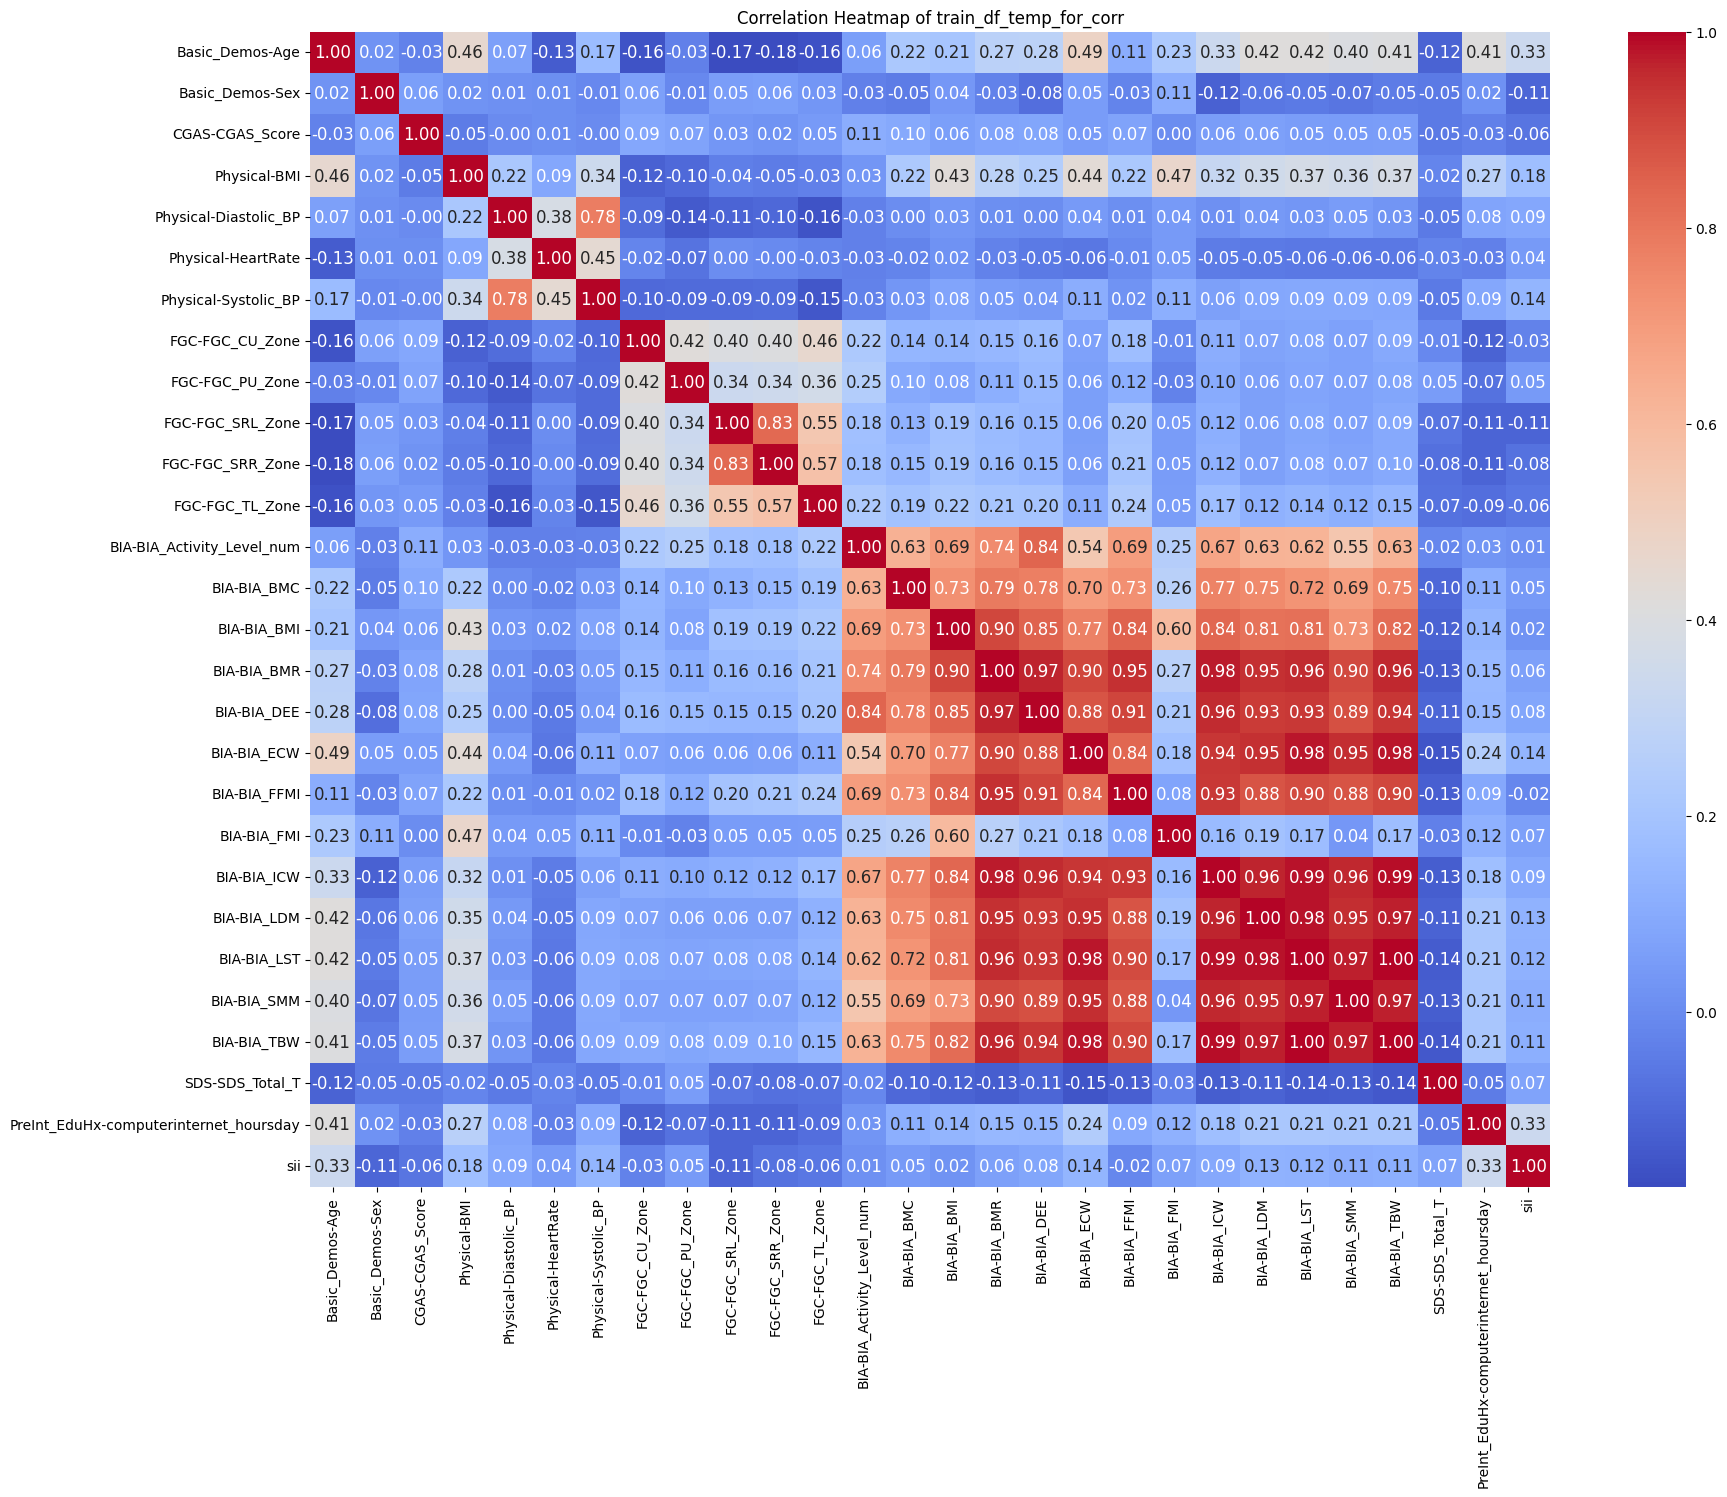

In [141]:
# Correlation heat map for combined_df_temp_for_corr

correlation_matrix = train_df_temp_for_corr.corr()
plt.figure(figsize=(20, 15))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 12})
plt.title("Correlation Heatmap of train_df_temp_for_corr")
plt.show()

### Table 1: Demo Data Correlation Table

In [142]:
# Create table of highest correlations in reduced_train_df_temp, sorted descending

# Remove diagonal part (correlation with itself)
correlation_matrix = correlation_matrix.mask(np.equal(*np.indices(correlation_matrix.shape)))

# Stack the correlation matrix and reset index
correlations = correlation_matrix.stack().reset_index()

# Rename columns
correlations.columns = ['Feature 1', 'Feature 2', 'Correlation']

# Sort by correlation in descending order
correlations = correlations.sort_values(by=['Correlation'], ascending=False)

# Display the top correlations
print(correlations.head(200))



                                  Feature 1                               Feature 2  Correlation
617                             BIA-BIA_LST                             BIA-BIA_TBW     0.997291
670                             BIA-BIA_TBW                             BIA-BIA_LST     0.997291
563                             BIA-BIA_ICW                             BIA-BIA_TBW     0.988753
668                             BIA-BIA_TBW                             BIA-BIA_ICW     0.988753
561                             BIA-BIA_ICW                             BIA-BIA_LST     0.985536
614                             BIA-BIA_LST                             BIA-BIA_ICW     0.985536
588                             BIA-BIA_LDM                             BIA-BIA_LST     0.982542
615                             BIA-BIA_LST                             BIA-BIA_LDM     0.982542
665                             BIA-BIA_TBW                             BIA-BIA_ECW     0.979930
482                           

## Plot 2: Impairment By Age, Sex

Examine impairment ('sii') by age group and sex.

💚 Results

1. Preteen males are more impaired than not.
2. Males are more impaired than females, generally.
3. In the train sample, there are no unimpaired *teen males or females.
4. The 18+ age group is underfrepresented in the study, so impairment results for 18+ males and females are not fully available/ripe for analysis.

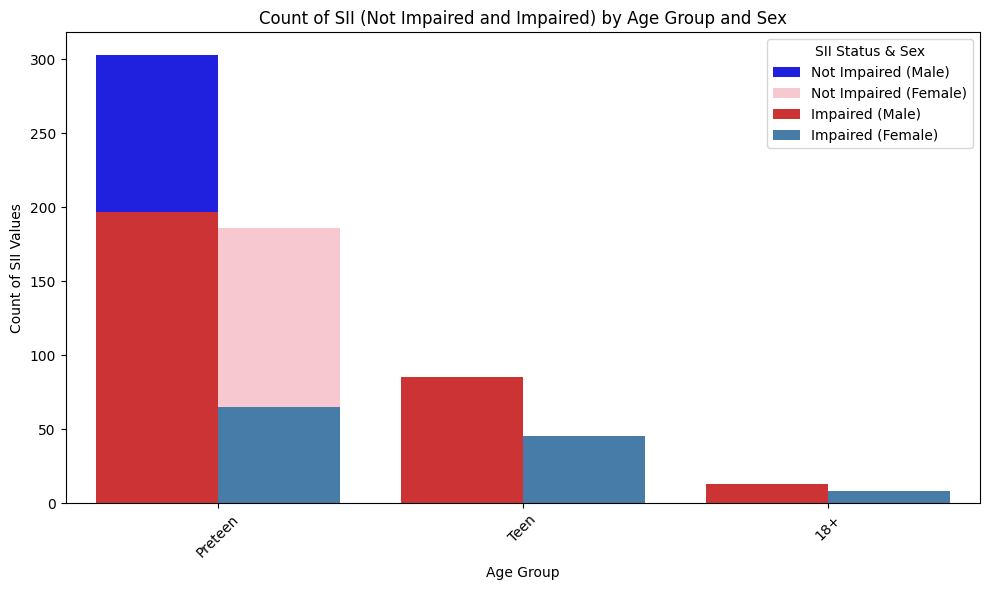

In [143]:
# Impairment by age and sex
# Define age bins and corresponding labels
age_bins = [0, 13, 18, 22]  # Adjust bins as necessary
age_labels = ['Preteen', 'Teen', '18+']  # Labels for each bin

# Create an 'Age_Group' column using pd.cut
train_df_temp_for_corr['Age_Group'] = pd.cut(train_df_temp_for_corr['Basic_Demos-Age'], bins=age_bins, labels=age_labels, right=False)

# Map sii values to "Not Impaired" (0) and "Impaired" (1)
train_df_temp_for_corr['Sii_Label'] = train_df_temp_for_corr['sii'].map({0: 'Not Impaired', 1: 'Impaired'})

# Map Sex values to "Male" (0) and "Female" (1)
train_df_temp_for_corr['Sex_Label'] = train_df_temp_for_corr['Basic_Demos-Sex'].map({0: 'Male', 1: 'Female'})

# Create a plot to visualize sii values (0 and 1) broken out by Age_Group and Sex
plt.figure(figsize=(10, 6))

# Define a custom palette for Male (blue) and Female (pink)
palette = {'Male': 'blue', 'Female': 'pink'}

# Plot for sii = 0 (Not Impaired)
sns.countplot(
    x='Age_Group',
    hue='Sex_Label',  # Breakout by sex (Male, Female)
    data=train_df_temp_for_corr[train_df_temp_for_corr['sii'] == 0],  # Filter for sii = 0
    palette=palette,  # Use custom palette
    hue_order=['Male', 'Female'],  # Ensure correct order of sex labels
    dodge=True  # Separate bars for different Sex within each Age Group
)

# Plot for sii = 1 (Impaired)
sns.countplot(
    x='Age_Group',
    hue='Sex_Label',  # Breakout by sex (Male, Female)
    data=train_df_temp_for_corr[train_df_temp_for_corr['sii'] == 1],  # Filter for sii = 1
    palette='Set1',
    hue_order=['Male', 'Female'],  # Ensure correct order of sex labels
    dodge=True  # Separate bars for different Sex within each Age Group
)

# Title and labels
plt.title('Count of SII (Not Impaired and Impaired) by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Count of SII Values')

# Add a custom legend for Sii_Label and Sex_Label
plt.legend(title='SII Status & Sex', loc='upper right', labels=['Not Impaired (Male)', 'Not Impaired (Female)', 'Impaired (Male)', 'Impaired (Female)'])

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent clipping
plt.tight_layout()

# Show plot
plt.show()



## Plot 3: Activity Intensity, BMI, Impairment

Examine activity intensity ('enmo'), BMI and impairment ('sii').

💚 Results

1. Impairment observations, represented by the yellow dots (sii = 1), are clustered more in the area of the plot representing lower activity intensity ('enmo').
2. We also see more impairment clustered around higher BMIs.

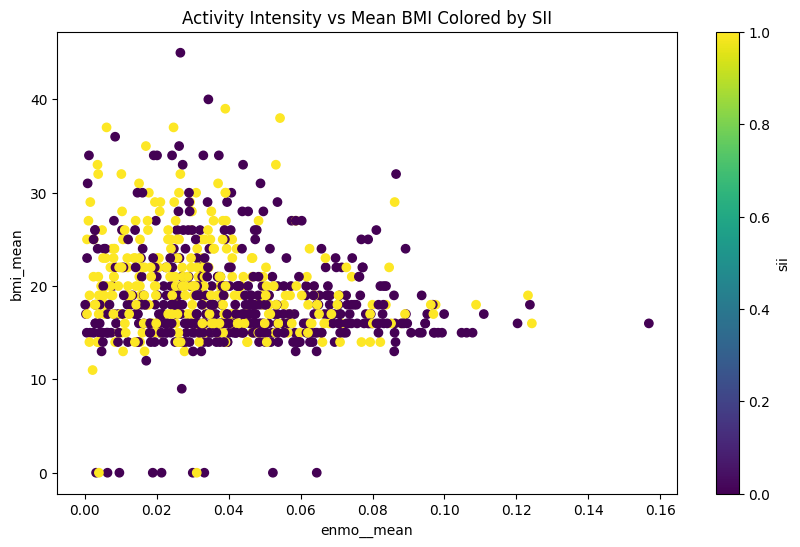

In [144]:
# Examine activity intensity, BMI and sii (impairment)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_MinFC_combined['enmo__mean'], X_train_MinFC_combined['Physical-BMI'], c=X_train_MinFC_combined['sii'])
plt.xlabel('enmo__mean')
plt.ylabel('bmi_mean')
plt.title('Activity Intensity vs Mean BMI Colored by SII')
plt.colorbar(label='sii')
plt.show()

## Plots 4, 5: Activity Level, Fitness, Impairment

BIA-BIA_Activity_Level_num,
FGC-FGC_CU_Zone,  FGC-FGC_PU_Zone,
FGC-FGC_TL_Zone vs sii

💚 Results

1. Looking at activity level (BIA-BIA_Activity_Level_num), it's interesting that 50% of survey participants recording moderate levels of activity are still impaired, while participants recording othe activity levels (very light, light, heavy etc) were less impaired. This does not make alot of sense, but we know these metrics for Bio-electric Impedance Analysis are not simply self-assessment - more analysis needed.

2. For fitness indicators such as curl ups, pull ups, sit and reach and trunk lift, for participants "needing improvement", we see a more even split of impairment. For participants in the "healthy fitness zone', fewer are impaired but there is not a drastic difference.


In [145]:
# Value counts for: BIA-BIA_Activity_Level_num,
# FGC-FGC_CU_Zone,  FGC-FGC_PU_Zone,
# FGC-FGC_SRL_Zone, FGC-FGC_SRR_Zone, FGC-FGC_TL_Zone,

columns_to_check = ['BIA-BIA_Activity_Level_num', 'FGC-FGC_CU_Zone',  'FGC-FGC_PU_Zone',
                    'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone']

for col in columns_to_check:
    if col in X_train_MinFC_combined.columns:
        value_counts = X_train_MinFC_combined[col].value_counts()
        print(f"Value counts for {col}:\n{value_counts}\n")
    else:
        print(f"Column '{col}' not found in the DataFrame.\n")

Value counts for BIA-BIA_Activity_Level_num:
BIA-BIA_Activity_Level_num
3.0    231
0.0    203
2.0    181
1.0     80
4.0     78
5.0     23
Name: count, dtype: int64

Value counts for FGC-FGC_CU_Zone:
FGC-FGC_CU_Zone
0.0    514
1.0    282
Name: count, dtype: int64

Value counts for FGC-FGC_PU_Zone:
FGC-FGC_PU_Zone
0.0    603
1.0    193
Name: count, dtype: int64

Value counts for FGC-FGC_SRL_Zone:
FGC-FGC_SRL_Zone
0.0    449
1.0    347
Name: count, dtype: int64

Value counts for FGC-FGC_SRR_Zone:
FGC-FGC_SRR_Zone
0.0    447
1.0    349
Name: count, dtype: int64

Value counts for FGC-FGC_TL_Zone:
FGC-FGC_TL_Zone
1.0    412
0.0    384
Name: count, dtype: int64



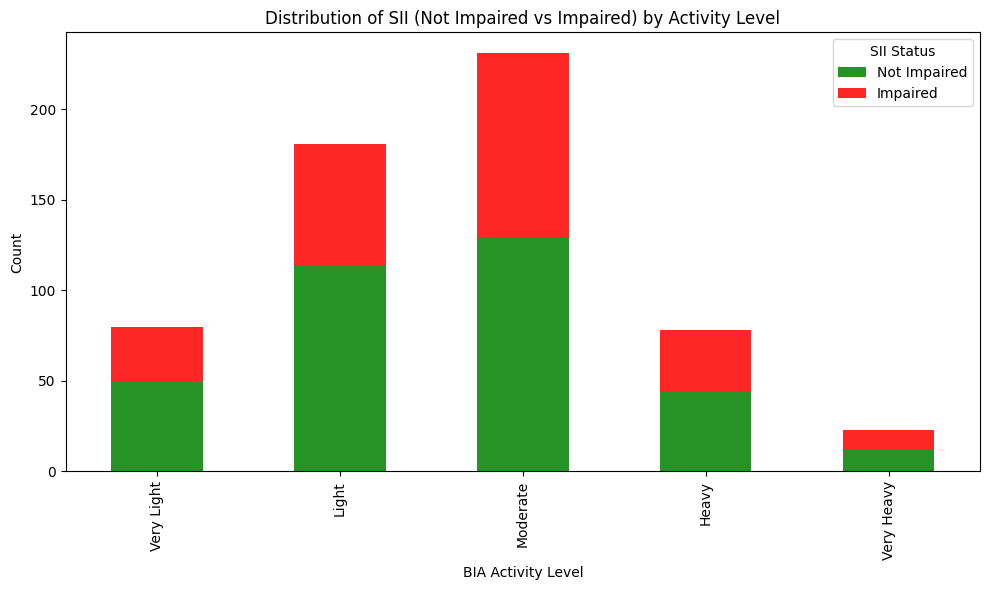

In [146]:
# Activity Level vs Impairment
# Filter the data to remove rows where 'BIA-BIA_Activity_Level_num' is 0 (missing values)
# Keep X_train_MinFC_combined intact for modeling so use
# X_train_MinFC_combined_temp

X_train_MinFC_combined_temp = X_train_MinFC_combined[X_train_MinFC_combined['BIA-BIA_Activity_Level_num'] != 0]

# Group data by 'BIA-BIA_Activity_Level_num' and 'sii' to count occurrences
distribution = X_train_MinFC_combined_temp.groupby(['BIA-BIA_Activity_Level_num', 'sii']).size().unstack(fill_value=0)

# Define labels for activity levels
activity_level_labels = {
    1: "Very Light",
    2: "Light",
    3: "Moderate",
    4: "Heavy",
    5: "Very Heavy"
}

# Rename index for better readability
distribution.index = distribution.index.map(activity_level_labels)

# Create a stacked bar plot
distribution.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6),
    color=['green', 'red'],
    alpha=0.85
)

# Add title, labels, and legend
plt.title("Distribution of SII (Not Impaired vs Impaired) by Activity Level")
plt.xlabel("BIA Activity Level")
plt.ylabel("Count")
plt.legend(["Not Impaired", "Impaired"], title="SII Status", loc="upper right")

# Display the plot
plt.tight_layout()
plt.show()



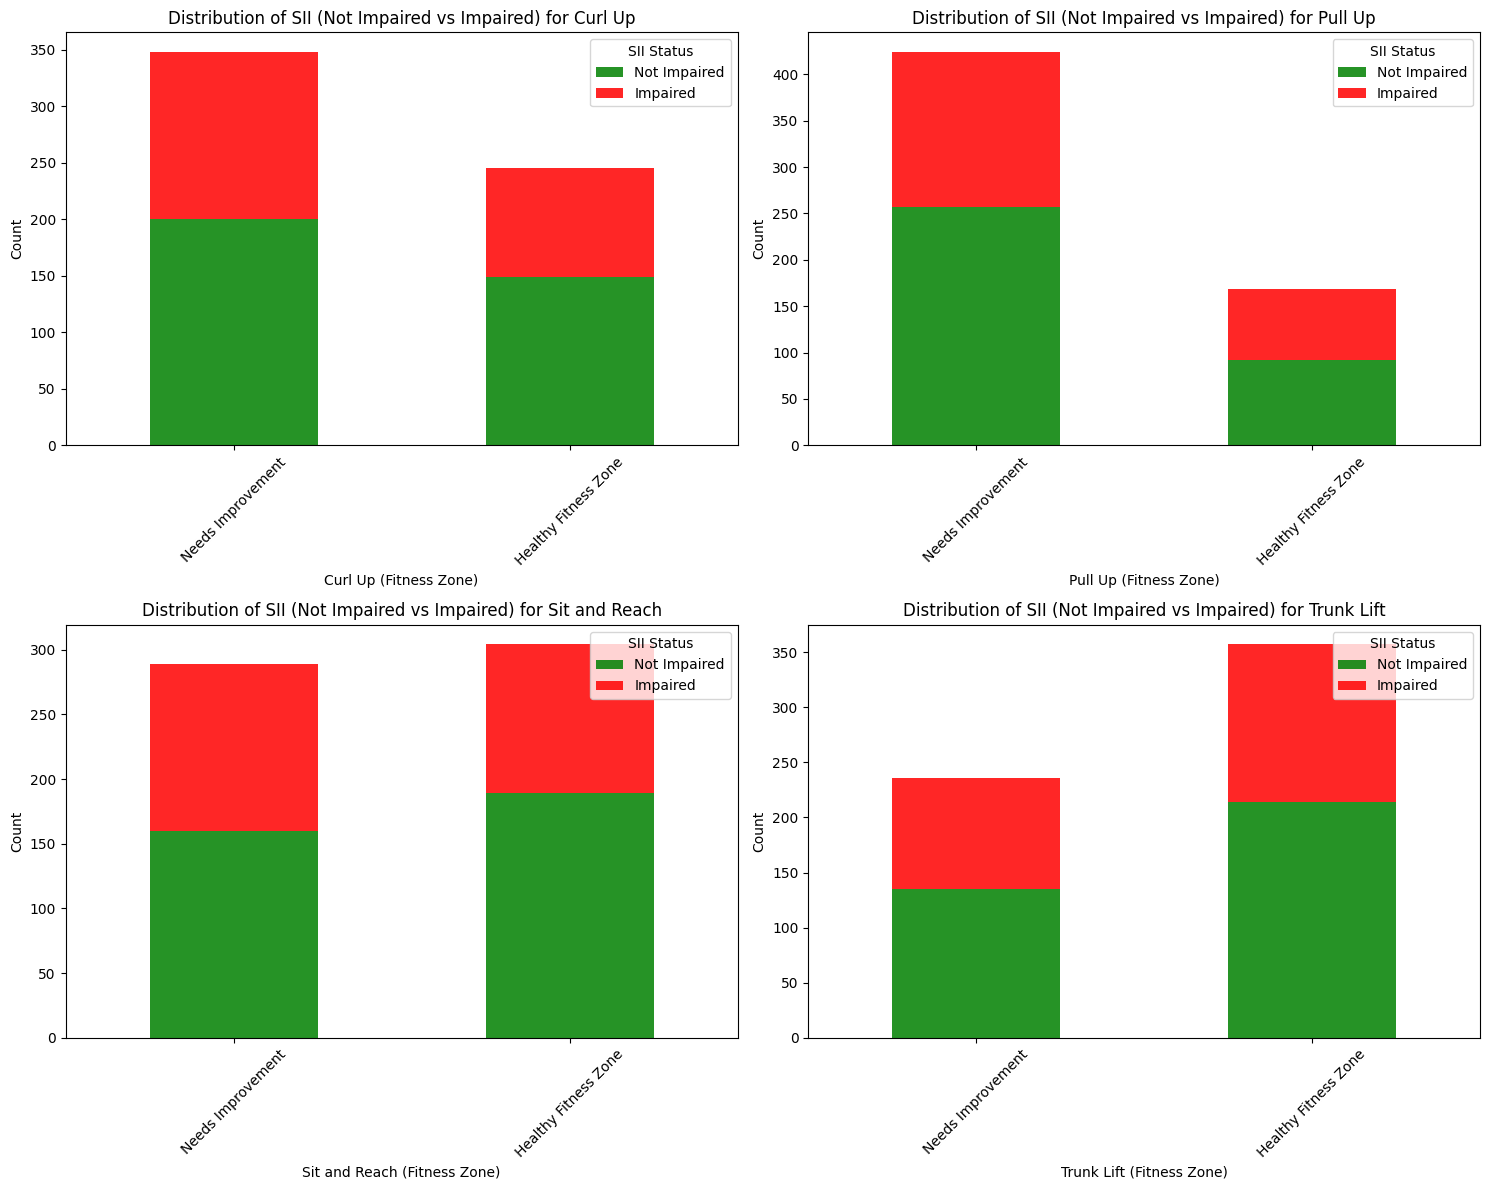

In [147]:
# Fitness Indicators vs Impairment

# Filter data to remove rows where 'BIA-BIA_Activity_Level_num' is 0 (missing values)

X_train_MinFC_combined_temp = X_train_MinFC_combined[
    X_train_MinFC_combined['BIA-BIA_Activity_Level_num'] != 0
]

# Zone labels for 0 and 1
zone_labels = {0: "Needs Improvement", 1: "Healthy Fitness Zone"}

# Define the zone columns and display labels
zone_columns = {
    "FGC-FGC_CU_Zone": "Curl Up",
    "FGC-FGC_PU_Zone": "Pull Up",
    "FGC-FGC_SRR_Zone": "Sit and Reach",
    "FGC-FGC_TL_Zone": "Trunk Lift"
}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()  # Flatten the 2D array of axes

# Loop through each zone column and plot
for idx, (zone, display_name) in enumerate(zone_columns.items()):
    # Group data by zone and sii
    distribution = X_train_MinFC_combined_temp.groupby([zone, 'sii']).size().unstack(fill_value=0)

    # Rename index for better readability
    distribution.index = distribution.index.map(zone_labels)

    # Create a stacked bar plot on the corresponding subplot
    distribution.plot(
        kind='bar',
        stacked=True,
        color=['green', 'red'],
        alpha=0.85,
        ax=axes[idx]
    )

    # Add title, labels, and legend
    axes[idx].set_title(f"Distribution of SII (Not Impaired vs Impaired) for {display_name}")
    axes[idx].set_xlabel(f"{display_name} (Fitness Zone)")
    axes[idx].set_ylabel("Count")
    axes[idx].legend(["Not Impaired", "Impaired"], title="SII Status", loc="upper right")

# Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()



## Table 2: Accelerator Data Summary Statistics, X,Y,Z Data

Let's start by looking at summary statistics for the accelerator data and try to visualize the X,Y,Z movement.

💚 Summary statistics

1. Why would X__length, Y__length amd Z__length have the same summary statistics if they represent movement in different planes??
2. I tried to represent the X,Y,Z movement coordinates visually (but didn't really yield anything discernible (to me, at least)).

In [148]:
# Create a subset of accelerometer data for analysis
# Define the prefixes to search for
prefixes = ('X', 'Y', 'Z', 'anglez', 'enmo', 'sii', 'time_of_day')

# Select columns starting with the specified prefixes
accelerator_subset_df = X_train_MinFC_combined.loc[:, X_train_MinFC_combined.columns.str.startswith(prefixes)]

# Display the new DataFrame
print(accelerator_subset_df.info)


<bound method DataFrame.info of      sii  X__absolute_maximum  X__length  X__maximum   X__mean     X__median  X__minimum  \
0    1.0             1.746094    43330.0    1.507865 -0.316384 -3.668489e-01   -1.746094   
1    1.0             1.038711   396396.0    1.034351 -0.004272 -2.062227e-02   -1.038711   
2    1.0             1.952594   414384.0    1.666465  0.208036  1.944045e-01   -1.952594   
3    0.0             2.284304   370956.0    1.000692 -0.343396 -4.732941e-01   -2.284304   
4    0.0             3.341210    97048.0    3.341210  0.018670  3.637551e-02   -2.143912   
5    0.0             2.076125   352596.0    1.230955 -0.163028 -4.250361e-02   -2.076125   
6    1.0             1.246738   368388.0    1.246738  0.250754  4.331616e-01   -1.041804   
7    1.0             1.604528   387060.0    1.513149  0.239876  2.443285e-01   -1.604528   
8    0.0             1.733475   403224.0    1.733475 -0.075508 -6.471034e-03   -1.623467   
9    0.0             2.176702   408049.0    1.54

In [149]:
# Summary statistics for select accelerometer data
accelerator_subset_df.describe()

sii  X__absolute_maximum      X__length  X__maximum     X__mean   X__median  \
count  796.000000           796.000000     796.000000  796.000000  796.000000  796.000000   
mean     0.418342             2.074862  312797.483668    1.657279   -0.066306   -0.083843   
std      0.493597             1.033020  135409.359586    0.880000    0.202347    0.267815   
min      0.000000             0.684554     927.000000    0.395664   -0.638839   -0.733410   
25%      0.000000             1.501761  244794.000000    1.113838   -0.198824   -0.273780   
50%      0.000000             1.883018  381978.000000    1.460310   -0.037966   -0.019413   
75%      1.000000             2.327044  402597.000000    1.881138    0.050521    0.031481   
max      1.000000             8.040816  756212.000000    8.022779    0.509981    0.638854   

       X__minimum  X__root_mean_square  X__standard_deviation  X__sum_values  X__variance  \
count  796.000000           796.000000             796.000000     796.000000   796.000000   
mean    -1.896227             0.518454               0.476047  -19535.802119     0.245092   
std      0.899388             0.147015               0.135993   62267.803698     0.110886   
min     -8.040816             0.025136               0.024780 -234123.649479     0.000614   
25%     -2.188083             0.458702               0.414134  -51570.882997     0.171507   
50%     -1.759744             0.576032               0.514484   -6853.200360     0.264694   
75%     -1.350631             0.619301               0.575175   12325.556777     0.330827   
max     -0.069883             0.752703               0.705287  190349.656973     0.497430   

       Y__absolute_maximum      Y__length  Y__maximum     Y__mean   Y__median  Y__minimum  \
count           796.000000     796.000000  796.000000  796.000000  796.000000  796.000000   
mean              2.655353  312797.483668    2.157537    0.022277    0.020374   -2.369604   
std               0.895647  135409.359586    0.933512    0.135273    0.163421    0.900534   
min               0.694427     927.000000    0.694427   -0.687518   -0.999044   -5.429414   
25%               2.047642  244794.000000    1.291234   -0.027316   -0.019778   -2.953276   
50%               2.656457  381978.000000    2.109761    0.010478    0.007132   -2.393238   
75%               3.224418  402597.000000    2.776359    0.058279    0.044519   -1.673363   
max               6.836718  756212.000000    6.836718    0.854616    1.027510   -0.042760   

       Y__root_mean_square  Y__standard_deviation  Y__sum_values  Y__variance  \
count           796.000000             796.000000     796.000000   796.000000   
mean              0.476283               0.459077    8584.379701     0.220433   
std               0.111242               0.098456   48957.942179     0.078291   
min               0.024086               0.021742 -288938.931255     0.000473   
25%               0.440933               0.429796   -5985.160616     0.184725   
50%               0.486342               0.476128    1588.375370     0.226698   
75%               0.525541               0.514872   17029.457880     0.265093   
max               0.963658               0.791726  361492.205486     0.626829   

       Z__absolute_maximum      Z__length  Z__maximum     Z__mean   Z__median  Z__minimum  \
count           796.000000     796.000000  796.000000  796.000000  796.000000  796.000000   
mean              1.883474  312797.483668    1.871253   -0.141034   -0.180001   -1.078244   
std               0.911592  135409.359586    0.917534    0.267176    0.393663    0.303910   
min               0.987990     927.000000    0.167161   -1.048020   -1.047357   -8.040491   
25%               1.251414  244794.000000    1.225194   -0.254742   -0.319697   -1.046534   
50%               1.740934  381978.000000    1.732158   -0.141485   -0.174688   -1.016139   
75%               2.242230  402597.000000    2.233558   -0.011485   -0.000043   -1.005559   
max               8.125557

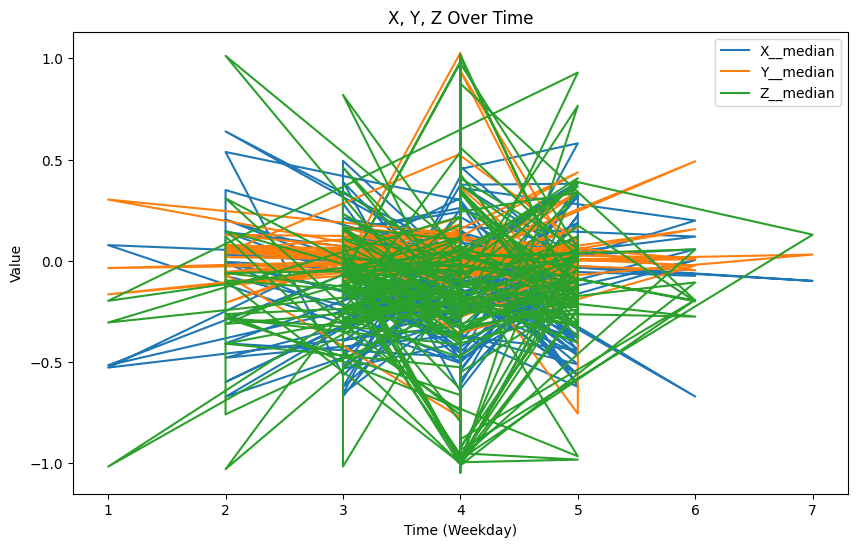

In [150]:
plt.figure(figsize=(10, 6))
plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['X__median'], label='X__median')
plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['Y__median'], label='Y__median')
plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['Z__median'], label='Z__median')
plt.legend()
plt.title('X, Y, Z Over Time')
plt.xlabel('Time (Weekday)')
plt.ylabel('Value')
plt.show()


In [151]:
accelerator_subset_df.columns


Index(['sii', 'X__absolute_maximum', 'X__length', 'X__maximum', 'X__mean', 'X__median',
       'X__minimum', 'X__root_mean_square', 'X__standard_deviation', 'X__sum_values',
       'X__variance', 'Y__absolute_maximum', 'Y__length', 'Y__maximum', 'Y__mean', 'Y__median',
       'Y__minimum', 'Y__root_mean_square', 'Y__standard_deviation', 'Y__sum_values',
       'Y__variance', 'Z__absolute_maximum', 'Z__length', 'Z__maximum', 'Z__mean', 'Z__median',
       'Z__minimum', 'Z__root_mean_square', 'Z__standard_deviation', 'Z__sum_values',
       'Z__variance', 'anglez__absolute_maximum', 'anglez__length', 'anglez__maximum',
       'anglez__mean', 'anglez__median', 'anglez__minimum', 'anglez__root_mean_square',
       'anglez__standard_deviation', 'anglez__sum_values', 'anglez__variance',
       'enmo__absolute_maximum', 'enmo__length', 'enmo__maximum', 'enmo__mean', 'enmo__median',
       'enmo__minimum', 'enmo__root_mean_square', 'enmo__standard_deviation', 'enmo__sum_values',
       'enmo__

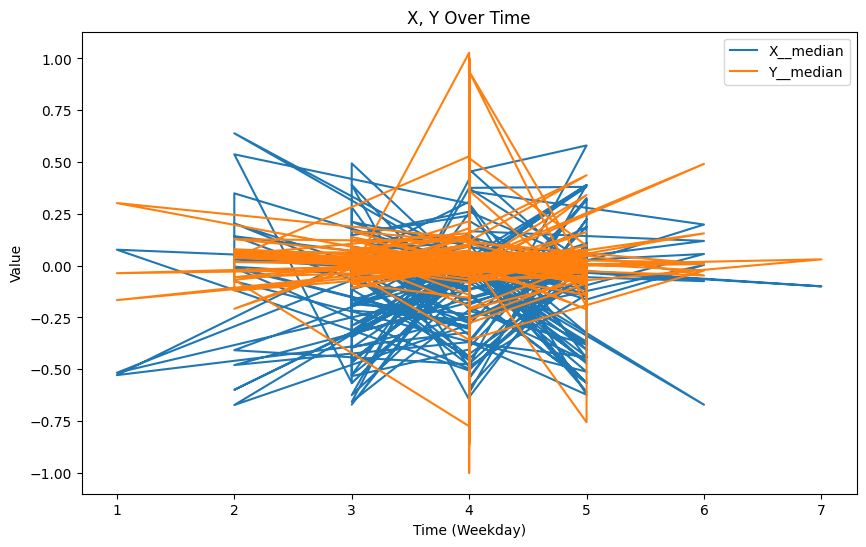

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['X__median'], label='X__median')
plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['Y__median'], label='Y__median')
# plt.plot(X_train_MinFC_combined['weekday__median'], X_train_MinFC_combined['Z__median'], label='Z__median')
plt.legend()
plt.title('X, Y Over Time')
plt.xlabel('Time (Weekday)')
plt.ylabel('Value')
plt.show()

## Plot 6: Activity Intensity, Time of Day

Based on the plot below, activity intensity by time_of_day_mean does not really provide intelligence about activity intensity timeframes. Recall how time_of_day is recorded:

time_of_day - Time of day representing the start of a 5s window that the data has been sampled over, with format %H:%M:%S.%9f.

Let's redo the plot using time_of_day_sum_values to look at the min and max of activity intensity.

💚 Results

1. I think what we are seeing on the second plot using time_of_day_sum__values is that for study respondents who kept their accelerometer *on more than others, resulting in more readings and thus greater time_of_day_sum__values, the min/max enmo data is clustered between values 1 through 7. I don't think
using time_of_day_data in summary form tells us much about activity intensity. I'm inclined to look at the data with more granularity, and look at day of week as well.

<ipython-input-153-5cc366dd8be7>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


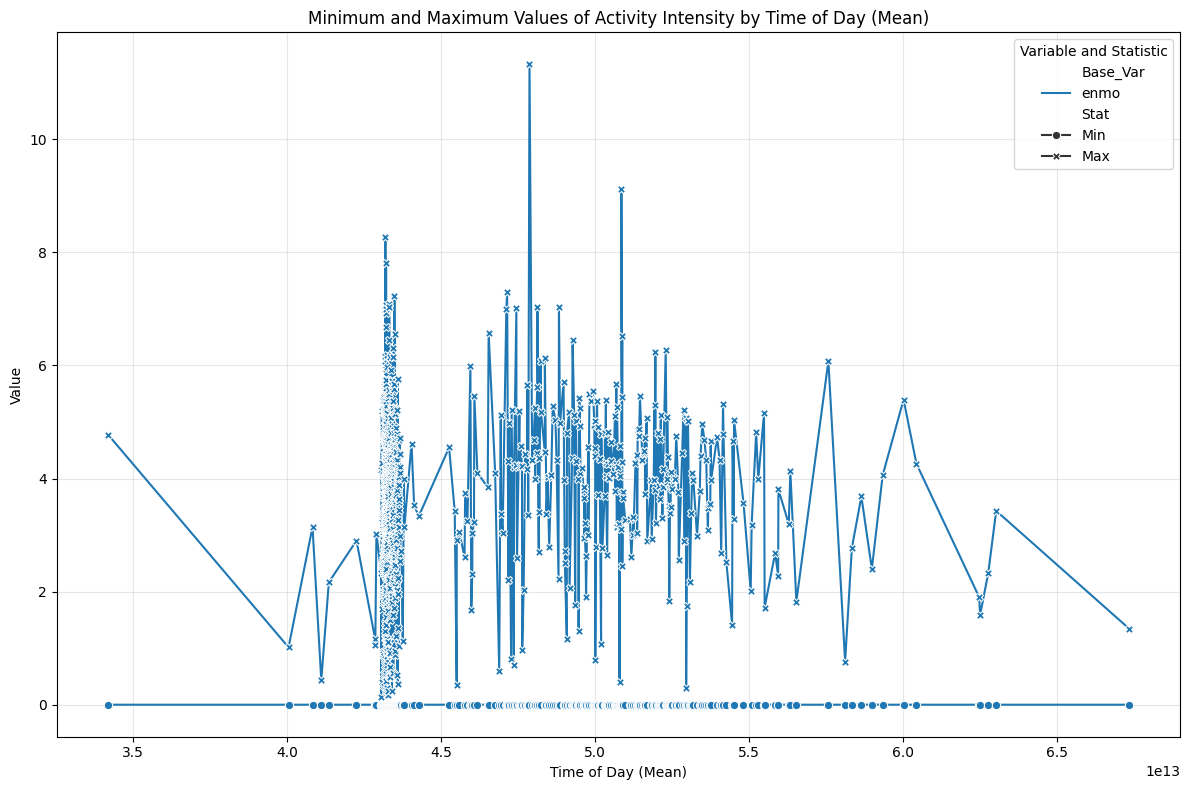

In [153]:
# activity intensity by time_of_day_mean
columns_to_plot = ['enmo']
time_var = 'time_of_day__mean'

# Melt the dataframe for easier plotting
plot_data = accelerator_subset_df.melt(
    id_vars=[time_var],
    value_vars=[f"{var}__minimum" for var in columns_to_plot] + [f"{var}__maximum" for var in columns_to_plot],
    var_name="Variable",
    value_name="Value"
)

# Extract min/max indicator and base variable name
plot_data['Stat'] = plot_data['Variable'].apply(lambda x: 'Min' if '__minimum' in x else 'Max')
plot_data['Base_Var'] = plot_data['Variable'].str.split('__').str[0]

# Plot

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=plot_data,
    x=time_var,
    y="Value",
    hue="Base_Var",
    style="Stat",
    markers=True,
    dashes=False,
    ci=None
)
plt.title("Minimum and Maximum Values of Activity Intensity by Time of Day (Mean)")
plt.xlabel("Time of Day (Mean)")
plt.ylabel("Value")
plt.legend(title="Variable and Statistic")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<ipython-input-154-f0fa6f5a2ebc>:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


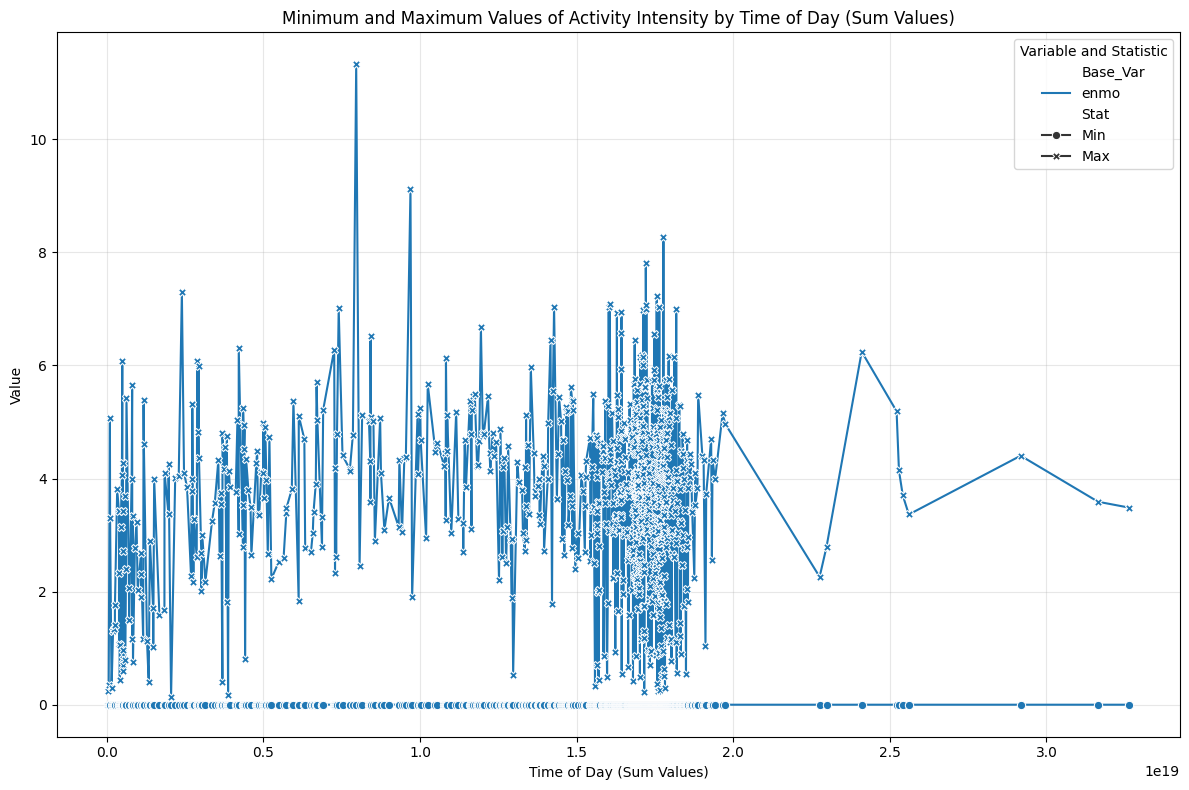

In [154]:
# activity intensity by time_of_day_sum_values
columns_to_plot = ['enmo']
time_var = 'time_of_day__sum_values'

# Melt the dataframe for easier plotting
plot_data = accelerator_subset_df.melt(
    id_vars=[time_var],
    value_vars=[f"{var}__minimum" for var in columns_to_plot] + [f"{var}__maximum" for var in columns_to_plot],
    var_name="Variable",
    value_name="Value"
)

# Extract min/max indicator and base variable name
plot_data['Stat'] = plot_data['Variable'].apply(lambda x: 'Min' if '__minimum' in x else 'Max')
plot_data['Base_Var'] = plot_data['Variable'].str.split('__').str[0]

# Plot

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=plot_data,
    x=time_var,
    y="Value",
    hue="Base_Var",
    style="Stat",
    markers=True,
    dashes=False,
    ci=None
)
plt.title("Minimum and Maximum Values of Activity Intensity by Time of Day (Sum Values)")
plt.xlabel("Time of Day (Sum Values)")
plt.ylabel("Value")
plt.legend(title="Variable and Statistic")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [155]:
# Refresh
X_train_MinFC_combined.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

## Table 3: Movement, Angle of Movement, Activity Intensity, Light, sii

💚 Results

The table below shows the relationship between the means for movement, angle, activity intensity, light and impairment, where weekdays are numbered 1 through 7 (Monday = 1). The table was repeated for median values as well to mitigate against gross outliers.

1. In the median table, we see the highest levels of activity intensity on weekday_median = 6 and 7, Saturday and Sunday, perhaps indicating the influence of parents on weekends/lack of school? However, we do not see a drastic reduction in median sii for both those days of the week.

                    X__mean   Y__mean  anglez__mean  enmo__mean  light__mean       sii
        weekday__mean                                                                     
        1             -0.450011  0.227668    -17.393038    0.055518     6.874756  0.000000
        2              0.089030  0.016948    -19.001829    0.056895    36.791346  0.200000
        3             -0.123469  0.000232     -8.125515    0.057543    70.010579  0.619048
        4             -0.064840  0.022986    -12.167540    0.038580    38.723847  0.398537
        5             -0.127512 -0.021114     -5.653545    0.059282    57.056216  0.625000
        6              0.040530  0.029551     -5.196295    0.058828    47.573617  0.666667

                      X__median  Y__median  anglez__median  enmo__median  light__median       sii
        weekday__median                                                                             
        1                -0.522383   0.132930      -14.919467      0.026845      12.430833  0.500000
        2                 0.065857   0.004330      -20.285051      0.030870      12.559488  0.444444
        3                -0.206871   0.012224       -4.215043      0.024271      11.458450  0.535714
        4                -0.081762   0.021552      -14.783538      0.012514       7.308482  0.402697
        5                -0.084326  -0.021648       -1.366269      0.023028       9.882948  0.428571
        6                -0.061331   0.099864       -9.287583      0.027908       9.648962  0.500000
        7                -0.099883   0.030495        7.933793      0.031480       5.679778  0.000000

In [156]:
# Movement, angle of movement, activity intensity, light vs weekday
accelerometer_vars = ['X__mean', 'Y__mean', 'anglez__mean', 'enmo__mean', 'light__mean', 'sii']
# round to integer 'weekday__mean'
# keep X_train_MinFC_combined intact for modeling

X_train_MinFC_combined_temp['weekday__mean'] = X_train_MinFC_combined['weekday__mean'].round().astype(int)

summary_by_weekday = X_train_MinFC_combined_temp.groupby('weekday__mean')[accelerometer_vars].mean()
print(summary_by_weekday)


                X__mean   Y__mean  anglez__mean  enmo__mean  light__mean       sii
weekday__mean                                                                     
1             -0.450011  0.227668    -17.393038    0.055518     6.874756  0.000000
2              0.089030  0.016948    -19.001829    0.056895    36.791346  0.200000
3             -0.123469  0.000232     -8.125515    0.057543    70.010579  0.619048
4             -0.064840  0.022986    -12.167540    0.038580    38.723847  0.398537
5             -0.127512 -0.021114     -5.653545    0.059282    57.056216  0.625000
6              0.040530  0.029551     -5.196295    0.058828    47.573617  0.666667


<ipython-input-156-fcee429f8150>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_MinFC_combined_temp['weekday__mean'] = X_train_MinFC_combined['weekday__mean'].round().astype(int)


In [157]:
# Movement, angle of movement, activity intensity, light vs weekday
accelerometer_vars = ['X__median', 'Y__median', 'anglez__median', 'enmo__median', 'light__median', 'sii']
# round to integer 'weekday__mean'
# keep X_train_MinFC_combined intact for modeling

X_train_MinFC_combined_temp['weekday__median'] = X_train_MinFC_combined['weekday__median'].round().astype(int)

summary_by_weekday = X_train_MinFC_combined_temp.groupby('weekday__median')[accelerometer_vars].mean()
print(summary_by_weekday)

                 X__median  Y__median  anglez__median  enmo__median  light__median       sii
weekday__median                                                                             
1                -0.522383   0.132930      -14.919467      0.026845      12.430833  0.500000
2                 0.065857   0.004330      -20.285051      0.030870      12.559488  0.444444
3                -0.206871   0.012224       -4.215043      0.024271      11.458450  0.535714
4                -0.081762   0.021552      -14.783538      0.012514       7.308482  0.402697
5                -0.084326  -0.021648       -1.366269      0.023028       9.882948  0.428571
6                -0.061331   0.099864       -9.287583      0.027908       9.648962  0.500000
7                -0.099883   0.030495        7.933793      0.031480       5.679778  0.000000


<ipython-input-157-f837b3708c11>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_MinFC_combined_temp['weekday__median'] = X_train_MinFC_combined['weekday__median'].round().astype(int)


## Table 4: Weekday/Weekend, Enmo, Light, sii

Examine whether there are significant differences between the weekday and weekend activity intensity, ambient light and impairment readings.

💚 Using mean data, we see a higher level of activity intensity on weekends, more ambient light (implying more time outdoors?) but similar levels of impairment.

                enmo__mean  light__mean       sii
    is_weekend                                   
    False         0.039947    40.247253  0.411263
    True          0.052543    44.818291  0.428571

In [158]:
# Ensure we're working with a copy of the DataFrame to avoid SettingWithCopyWarning
X_train_MinFC_combined_temp = X_train_MinFC_combined_temp.copy()


X_train_MinFC_combined_temp['weekday__median'] = X_train_MinFC_combined['weekday__median'].round().astype(int)

# 'is_weekend' = weekday_median = 6,7 =  Sat, Sun
X_train_MinFC_combined_temp['is_weekend'] = X_train_MinFC_combined_temp['weekday__median'].isin([6, 7])

# Group by 'is_weekend' and aggregate the data (compute mean of already existing means)
weekend_comparison = X_train_MinFC_combined_temp.groupby('is_weekend')[['enmo__mean', 'light__mean', 'sii']].mean()

# Print the result
print(weekend_comparison)




            enmo__mean  light__mean       sii
is_weekend                                   
False         0.039947    40.247253  0.411263
True          0.052543    44.818291  0.428571


## Table 5: AbsMax X,Y,Z,sii

💚 Lower values of even the *absolute maximums associated with X,Y,Z show impairment - see plots below after summary statistics. Higher absolute maximum values have less impairment observations.


In [159]:
# X__absolute_maximum,Y__absolute_maximum,Z__absolute_maximum,anglez__absolute_maximum,enmo_absolute_maximum, sii for df = X_train_MinFC_combined

# Create a list of columns for absolute maximum values
cols_to_select = ['X__absolute_maximum', 'Y__absolute_maximum', 'Z__absolute_maximum', 'anglez__absolute_maximum', 'enmo__absolute_maximum', 'sii']

# Create a new DataFrame by selecting the columns and adding the weekday info
# Only select the columns if they exist in the dataframe
cols_to_select_existing = [col for col in cols_to_select if col in X_train_MinFC_combined.columns]

AbsMax_df = X_train_MinFC_combined[cols_to_select_existing]

# Display the table
AbsMax_df



X__absolute_maximum  Y__absolute_maximum  Z__absolute_maximum  anglez__absolute_maximum  \
0               1.746094             2.905339             1.546979                 89.833092   
1               1.038711             1.946303             1.146284                 89.476036   
2               1.952594             2.361866             2.239939                 89.862823   
3               2.284304             2.276082             1.299293                 89.877220   
4               3.341210             4.442658             2.321265                 89.308716   
5               2.076125             2.664351             3.185113                 89.457382   
6               1.246738             1.366126             1.040714                 89.494568   
7               1.604528             2.016762             1.616539                 89.803101   
8               1.733475             2.384679             1.035882                 89.942841   
9               2.176702             1.216318             1.081660                 89.819778   
10              2.369030             2.430707             2.013542                 89.850655   
11              2.389693             1.954204             1.314255                 89.911613   
12              1.878870             2.525253             1.084309                 89.628151   
13              1.008680             0.987266             1.017756                 89.867897   
14              1.883331             2.610384             1.449253                 89.729294   
15              2.124973             3.743157             2.066207                 89.582329   
16              2.157567             3.250170             1.991074                 89.896507   
17              3.653923             5.195954             2.832015                 89.691467   
18              1.227083             1.063542             1.793177                 89.496811   
19              2.009732             2.101446             1.816210                 89.973572   
20              1.796247             4.720018             2.073626                 89.300674   
21              2.796118             4.406117             4.183939                 89.919640   
22              1.757751             2.263728             1.490875                 89.875946   
23              7.108834             6.836718             7.347650                 89.852837   
24              1.421296             2.075604             1.055716                 89.655525   
25              1.948018             3.616529             2.452331                 89.731430   
26              5.600703             2.448318             1.478700                 89.933830   
27              0.995807             0.832643             1.010182                 87.677666   
28              1.850391             3.580182             1.798073                 89.987045   
29              1.522872             3.048567             3.904153                 89.871880   
30              1.108407             1.945050             1.145895                 89.337669   
31              2.443336             2.328683             2.156048                 89.304260   
32              2.414132             3.380917             2.598747                 89.288879   
33              1.389243             2.149015             1.187676                 89.606743   
34              1.987213             1.993464             2.210156                 89.677177   
35              1.775446             3.006762             2.481128                 89.688133   
36              7.967501             3.043977             3.734001                 89.655380   
37              2.156349             3.055914             1.992976                 89.846779   
38              2.583682             1.929492             1.972435                 89.771004   
39              2.552884             3.115721             3.005223                 89.740105   
40              3.156536             2.951608             2.716174   

In [160]:
# Absolute Maximum values summary stats
print(AbsMax_df.describe())


       X__absolute_maximum  Y__absolute_maximum  Z__absolute_maximum  anglez__absolute_maximum  \
count           796.000000           796.000000           796.000000                796.000000   
mean              2.074862             2.655353             1.883474                 89.688865   
std               1.033020             0.895647             0.911592                  0.386772   
min               0.684554             0.694427             0.987990                 85.309799   
25%               1.501761             2.047642             1.251414                 89.635141   
50%               1.883018             2.656457             1.740934                 89.780087   
75%               2.327044             3.224418             2.242230                 89.872890   
max               8.040816             6.836718             8.125557                 90.000000   

       enmo__absolute_maximum         sii  
count              796.000000  796.000000  
mean                 3.669079

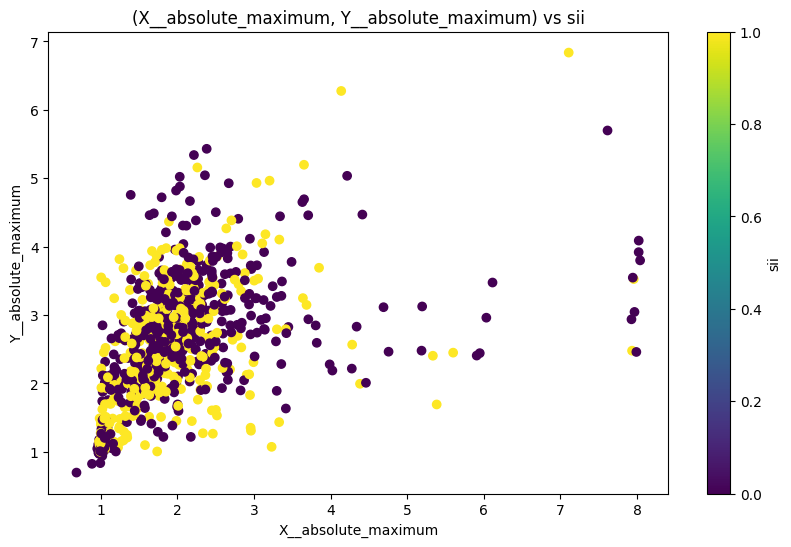

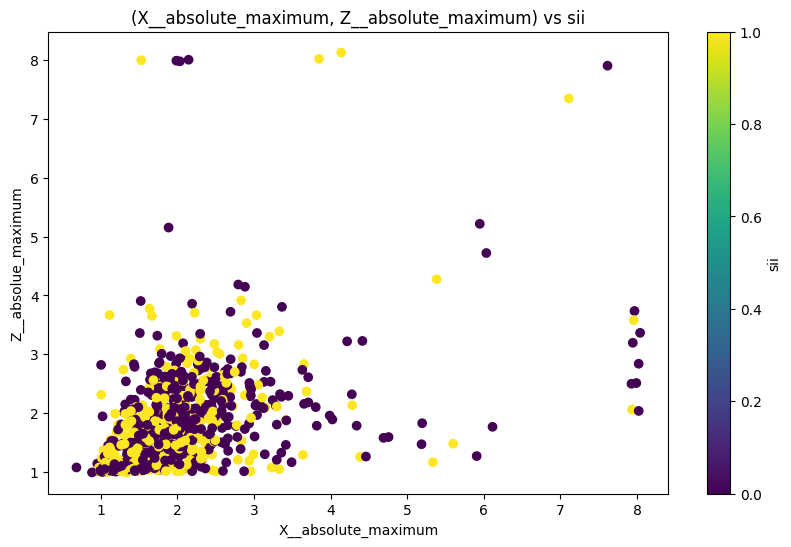

In [161]:
# Plot (X__absolute_maximum, Y__absolute_maximum, Z__maximum_absolute) vs sii
# need 2 plots for (2) 2D

plt.figure(figsize=(10, 6))
plt.scatter(X_train_MinFC_combined['X__absolute_maximum'], X_train_MinFC_combined['Y__absolute_maximum'], c=X_train_MinFC_combined['sii'])
plt.xlabel('X__absolute_maximum')
plt.ylabel('Y__absolute_maximum')
plt.title('(X__absolute_maximum, Y__absolute_maximum) vs sii')
plt.colorbar(label='sii')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(X_train_MinFC_combined['X__absolute_maximum'], X_train_MinFC_combined['Z__absolute_maximum'], c=X_train_MinFC_combined['sii'])
plt.xlabel('X__absolute_maximum')
plt.ylabel('Z__absolue_maximum')
plt.title('(X__absolute_maximum, Z__absolute_maximum) vs sii')
plt.colorbar(label='sii')
plt.show()

# Prepare Data for Modeling

💚 Approach

1. Create demographic data only files for baseline modeling with appropriate id's based on the _F24_withID files. (This is just being anal about keeping the demo data separate).
2. Drop 'id' from all files.
2. I am using MinFC_withID for the accelerometer data to start modeling along with the train_df demographic data.
3. Remove target var 'sii' from X_train,  X_test files
4. Reduce y_train and y_test files to target var 'sii'
5. Use StandardScaler
  Fit the scaler on the training data: This computes the mean and standard deviation used for scaling. Transform both the training and testing data: This ensures both datasets are scaled using the same parameters (mean and std) derived from the training set.

        train_df shape: (996, 29)

        X_train_F24_withID (796, 15)
        y_train_F24_withID (796, 2)
        X_test_F24_withID  (200, 15)
        y_test_F24_withID  (200, 2)

        MinFC_Results shape: (996, 141)

        X_train_MinFC_combined shape: (796, 169)
        y_train_MinFC_combined shape: (796, 169)
        X_test_MinFC_combined shape: (200, 169)
        y_test_MinFC_combined shape: (200, 169)

        (169 = 29 train_df + 141 MinFC_Results - 1 redun 'id')

## Demographic Data Files

Create demographic data only files for baseline modeling with appropriate id's based on the _F24_withID files. (This is just being anal about keeping the demo data separate).

In [162]:
# demographic data only X_train

only_demo_X_train = train_df[train_df['id'].isin(X_train_F24_withID['id'])]

print("Shape of only_demo_X_train:", only_demo_X_train.shape)
print("\nInfo of only_demo_X_train:", only_demo_X_train.info())


Shape of only_demo_X_train: (796, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 3 to 3958
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      796 non-null    object 
 1   Basic_Demos-Age                         796 non-null    int64  
 2   Basic_Demos-Sex                         796 non-null    int64  
 3   CGAS-CGAS_Score                         796 non-null    float64
 4   Physical-BMI                            796 non-null    int64  
 5   Physical-Diastolic_BP                   796 non-null    float64
 6   Physical-HeartRate                      796 non-null    float64
 7   Physical-Systolic_BP                    796 non-null    float64
 8   FGC-FGC_CU_Zone                         796 non-null    float64
 9   FGC-FGC_PU_Zone                         796 non-null    float64
 10  FGC-FGC_SRL_Zone            

In [163]:
# demo only y_train

only_demo_y_train = train_df[train_df['id'].isin(y_train_F24_withID['id'])]

print("Shape of only_demo_y_train:", only_demo_y_train.shape)
print("\nInfo of only_demo_y_train:", only_demo_y_train.info())

Shape of only_demo_y_train: (796, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 796 entries, 3 to 3958
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      796 non-null    object 
 1   Basic_Demos-Age                         796 non-null    int64  
 2   Basic_Demos-Sex                         796 non-null    int64  
 3   CGAS-CGAS_Score                         796 non-null    float64
 4   Physical-BMI                            796 non-null    int64  
 5   Physical-Diastolic_BP                   796 non-null    float64
 6   Physical-HeartRate                      796 non-null    float64
 7   Physical-Systolic_BP                    796 non-null    float64
 8   FGC-FGC_CU_Zone                         796 non-null    float64
 9   FGC-FGC_PU_Zone                         796 non-null    float64
 10  FGC-FGC_SRL_Zone            

In [164]:
# demo only X_test

only_demo_X_test = train_df[train_df['id'].isin(X_test_F24_withID['id'])]

print("Shape of only_demo_X_test:", only_demo_X_test.shape)
print("\nInfo of only_demo_X_test:", only_demo_X_test.info())

Shape of only_demo_X_test: (200, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 63 to 3945
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      200 non-null    object 
 1   Basic_Demos-Age                         200 non-null    int64  
 2   Basic_Demos-Sex                         200 non-null    int64  
 3   CGAS-CGAS_Score                         200 non-null    float64
 4   Physical-BMI                            200 non-null    int64  
 5   Physical-Diastolic_BP                   200 non-null    float64
 6   Physical-HeartRate                      200 non-null    float64
 7   Physical-Systolic_BP                    200 non-null    float64
 8   FGC-FGC_CU_Zone                         200 non-null    float64
 9   FGC-FGC_PU_Zone                         200 non-null    float64
 10  FGC-FGC_SRL_Zone            

In [165]:
# demo only y_test

only_demo_y_test = train_df[train_df['id'].isin(y_test_F24_withID['id'])]

print("Shape of only_demo_y_test:", only_demo_y_test.shape)
print("\nInfo of only_demo_y_test:", only_demo_y_test.info())

Shape of only_demo_y_test: (200, 29)
<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 63 to 3945
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      200 non-null    object 
 1   Basic_Demos-Age                         200 non-null    int64  
 2   Basic_Demos-Sex                         200 non-null    int64  
 3   CGAS-CGAS_Score                         200 non-null    float64
 4   Physical-BMI                            200 non-null    int64  
 5   Physical-Diastolic_BP                   200 non-null    float64
 6   Physical-HeartRate                      200 non-null    float64
 7   Physical-Systolic_BP                    200 non-null    float64
 8   FGC-FGC_CU_Zone                         200 non-null    float64
 9   FGC-FGC_PU_Zone                         200 non-null    float64
 10  FGC-FGC_SRL_Zone            

In [166]:
# Refresh X_train_MinFC_combined
X_train_MinFC_combined.info(verbose=1)
# (796, 169)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

In [167]:
# Refresh X_test_MinFC_combined
X_test_MinFC_combined.info(verbose=1)
# (200, 169)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 169 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    id                                       object 
 1    Basic_Demos-Age                          int64  
 2    Basic_Demos-Sex                          int64  
 3    CGAS-CGAS_Score                          float64
 4    Physical-BMI                             int64  
 5    Physical-Diastolic_BP                    float64
 6    Physical-HeartRate                       float64
 7    Physical-Systolic_BP                     float64
 8    FGC-FGC_CU_Zone                          float64
 9    FGC-FGC_PU_Zone                          float64
 10   FGC-FGC_SRL_Zone                         float64
 11   FGC-FGC_SRR_Zone                         float64
 12   FGC-FGC_TL_Zone                          float64
 13   BIA-BIA_Activity_Level_num               float64
 14   BIA-BIA_

## Drop 'id' From All Files

In [168]:
# Drop 'id' from only_demo files
only_demo_X_train = only_demo_X_train.drop(columns=['id'])
only_demo_y_train = only_demo_y_train.drop(columns=['id'])
only_demo_X_test = only_demo_X_test.drop(columns=['id'])
only_demo_y_test = only_demo_y_test.drop(columns=['id'])
# Check work
print("only_demo_X_train shape:", only_demo_X_train.shape)
print("only_demo_y_train columns:", only_demo_y_train.columns)
# should be (796,169-1 = 168), good drop

print("only_demo_y_train shape:", only_demo_y_train.shape)
print("only_demo_y_train columns:", only_demo_y_train.columns)
# should be (796,169-1 = 168), good drop

print("only_demo_X_test shape:", only_demo_X_test.shape)
print("only_demo_X_test columns:", only_demo_X_test.columns)
# should be (200,169-1 = 168), good drop

print("only_demo_y_test shape:", only_demo_y_test.shape)
print("only_demo_y_test columns:", only_demo_y_test.columns)
# should be (200,169-1 = 168), good drop

only_demo_X_train shape: (796, 28)
only_demo_y_train columns: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE',
       'BIA-BIA_ECW', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST',
       'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday',
       'sii'],
      dtype='object')
only_demo_y_train shape: (796, 28)
only_demo_y_train columns: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activi

In [169]:
# Drop 'id' from X/y/train/test_MinFC_combined files
X_train_MinFC_combined = X_train_MinFC_combined.drop(columns=['id'])
y_train_MinFC_combined = y_train_MinFC_combined.drop(columns=['id'])
X_test_MinFC_combined = X_test_MinFC_combined.drop(columns=['id'])
y_test_MinFC_combined = y_test_MinFC_combined.drop(columns=['id'])
# Check work
print("X_train_MinFC_combined shape:", X_train_MinFC_combined.shape)
print("X_train_MinFC_combined columns:", X_train_MinFC_combined.columns)
# should be (796,169-1 = 168), good drop

print("y_train_MinFC_combined shape:", y_train_MinFC_combined.shape)
print("y_train_MinFC_combined columns:", y_train_MinFC_combined.columns)
# should be (796,169-1 = 168), good drop

print("X_test_MinFC_combined shape:", X_test_MinFC_combined.shape)
print("X_test_MinFC_combined columns:", X_test_MinFC_combined.columns)
# should be (200,169-1 = 168), good drop

print("y_test_MinFC_combined shape:", y_test_MinFC_combined.shape)
print("y_test_MinFC_combined columns:", y_test_MinFC_combined.columns)
# should be (200,169-1 = 168), good drop

X_train_MinFC_combined shape: (796, 168)
X_train_MinFC_combined columns: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'weekday__median', 'weekday__minimum', 'weekday__root_mean_square',
       'weekday__standard_deviation', 'weekday__sum_values', 'weekday__variance'],
      dtype='object', length=168)
y_train_MinFC_combined shape: (796, 168)
y_train_MinFC_combined columns: Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL_Zone',
       ...
       'weekday__absolute_maximum', 'weekday__length', 'weekday__maximum', 'weekday__mean',
       'we

## Prevent Data Leakage: Drop 'sii' from X_train, X_test Files

In [170]:
# Keep all columns except the target variable 'sii' for only_demo_X_train and only_demo_X_test
only_demo_X_train = only_demo_X_train.drop(columns=['sii'])
only_demo_X_test = only_demo_X_test .drop(columns=['sii'])

# Keep only the target variable 'sii' for only_demo_y_train and only_demo_y_test
only_demo_y_train = only_demo_y_train['sii'] if 'sii' in only_demo_y_train else None
only_demo_y_test = only_demo_y_test['sii'] if 'sii' in only_demo_y_test else None

# Verify the shapes of the datasets
print("only_demo_X_train shape:", only_demo_X_train.shape)
print("only_demo_X_test shape:", only_demo_X_test.shape)
print("only_demo_y_train shape:", only_demo_y_train.shape)
print("only_demo_y_test shape:", only_demo_y_test.shape)

# Ensure the datasets are properly aligned
assert only_demo_X_train.shape[0] == only_demo_y_train.shape[0], "Mismatch between X_train and y_train sizes."
assert only_demo_X_test.shape[0] == only_demo_y_test.shape[0], "Mismatch between X_test and y_test sizes."

only_demo_X_train shape: (796, 27)
only_demo_X_test shape: (200, 27)
only_demo_y_train shape: (796,)
only_demo_y_test shape: (200,)


In [171]:
# Check work
if 'sii' in only_demo_X_train.columns:
    print(only_demo_X_train['sii'].value_counts())
else:
    print("'sii' column is not in only_demo_X_train.")
if 'sii' in only_demo_X_test.columns:
    print(only_demo_X_test['sii'].value_counts())
else:
    print("'sii' column is not in only_demo_X_test.")

'sii' column is not in only_demo_X_train.
'sii' column is not in only_demo_X_test.


In [172]:
# Keep all columns except the target variable 'sii' for X_train and X_test
X_train = X_train_MinFC_combined.drop(columns=['sii'])
X_test = X_test_MinFC_combined.drop(columns=['sii'])

# Keep only the target variable 'sii' for y_train and y_test
y_train = y_train_MinFC_combined['sii'] if 'sii' in y_train_MinFC_combined else None
y_test = y_test_MinFC_combined['sii'] if 'sii' in y_test_MinFC_combined else None

# Verify the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Ensure the datasets are properly aligned
assert X_train.shape[0] == y_train.shape[0], "Mismatch between X_train and y_train sizes."
assert X_test.shape[0] == y_test.shape[0], "Mismatch between X_test and y_test sizes."

# y_train and y_test (x, ) not (x, 1): problem for model?

X_train shape: (796, 167)
X_test shape: (200, 167)
y_train shape: (796,)
y_test shape: (200,)


In [173]:
# Make sure X_train and X_test do not have target var 'sii'
# so no data leakage
if 'sii' in X_train.columns:
    print("X_train contains the target variable 'sii'.")
else:
    print("X_train does not contain the target variable 'sii'.")

if 'sii' in X_test.columns:
    print("X_test contains the target variable 'sii'.")
else:
    print("X_test does not contain the target variable 'sii'.")

X_train does not contain the target variable 'sii'.
X_test does not contain the target variable 'sii'.


## Convert to Numby Arrays

In [174]:
# Convert input features and target variables to numpy arrays
only_demo_X_train = only_demo_X_train.to_numpy()  # Convert to numpy array
only_demo_X_test= only_demo_X_test.to_numpy()    # Convert to numpy array
X_train = X_train.to_numpy()  # Convert to numpy array
X_test= X_test.to_numpy()    # Convert to numpy array
# Ensure target variables are numpy arrays and reshape them to (n_samples, 1)
only_demo_y_train = only_demo_y_train.to_numpy().reshape(-1, 1)
only_demo_y_test = only_demo_y_test.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [175]:
# Check work
print("only_demo_X_train shape:", only_demo_X_train.shape)  # Expected: (796, 27)
print("only_demo_y_train shape:", only_demo_y_train.shape)  # Expected: (796, 1)
print("only_demo_X_test shape:", only_demo_X_test.shape)  # Expected: (796, 27)
print("only_demo_y_test shape:", only_demo_y_test.shape)  # Expected: (796, 1)
print("X_train shape:", X_train.shape)  # Expected: (796, 167)
print("y_train shape:", y_train.shape)  # Expected: (796, 1)
print("X_test shape:", X_test.shape)  # Expected: (796, 167)
print("y_test shape:", y_test.shape)  # Expected: (796, 1)
# good shapes for modeling

only_demo_X_train shape: (796, 27)
only_demo_y_train shape: (796, 1)
only_demo_X_test shape: (200, 27)
only_demo_y_test shape: (200, 1)
X_train shape: (796, 167)
y_train shape: (796, 1)
X_test shape: (200, 167)
y_test shape: (200, 1)


## Check for Nans, Infinites

In [176]:
# Check for NaNs or infs in data which could blow model
print(np.isnan(only_demo_X_train).sum())
print(np.isnan(only_demo_y_train).sum())
print(np.isinf(only_demo_X_test).sum())
print(np.isinf(only_demo_y_test).sum())
print(np.isnan(X_train).sum())
print(np.isnan(y_train).sum())
print(np.isinf(X_test).sum())
print(np.isinf(y_test).sum())


0
0
0
0
0
0
0
0


## StandardScaler

In [177]:
# StandardScaler
# Why?
# Faster convergence: The gradients of the loss function are more uniform,
# preventing large updates to weights that could slow down convergence.
# Preventing dominance of features:
# If some features have larger values or ranges than others,
# they may dominate the training process,
# leading to poor learning of the less dominant features.

# use fit_transform() from StandardScaler() on X_train files
# use transform() to apply that StandardScaler() to X_test files

scaler = StandardScaler()
only_demo_X_train = scaler.fit_transform(only_demo_X_train)
only_demo_X_test = scaler.transform(only_demo_X_test) # apply
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # apply


# Modeling

💚 Approach

1. Run a baseline model for the demographic data only, noting weighed F1 score.
2. Run the same model with accelerometer MinFC_withID features, and compare F1's to decide whether to continue to include accelerometer data in subsequent models.
3. Use DrD's "Cheat Sheet: Building FFNNs" notebook to try different building neural network strategies.
  a. Strategy 1: Hidden Nodes = Input Features, 1 Layer
  b. Strategy 2: Hidden Nodes = (2,3,4...) X Input Features, 1 Layer
  c. Strategy 3: Hidden Nodes = (2,3,4...) X Input Features, >= 2 Layers
  d. Strategy 4: Info Tunnel: Hidden Nodes Decreasing by Half, >= 2 Layers
4. I decided to run a downsampled LSTM model after DrD made downsampling code available (Model #6), to evaluate against baseline and other models.

## Model: Baseline Demographic Data Only, Strategy 1, Hidden Node = Input Features (29), 1 Layer, Dropout = 0.3

Stopping too early in learning? see accuracy plot.

In [178]:
# Refresh train and test shaoes before modeling
print("only_demo_X_train:", only_demo_X_train.shape)
print("only_demo_y_train:", only_demo_y_train.shape)
print("only_demo_X_test", only_demo_X_test.shape)
print("only_demo_y_test:", only_demo_y_test.shape)
# good shapes

only_demo_X_train: (796, 27)
only_demo_y_train: (796, 1)
only_demo_X_test (200, 27)
only_demo_y_test: (200, 1)


In [179]:
# Build baseline model
# Let's use the number of features as the number of hidden units
# Strategy 1 from DrD CheatSheet_BuildingFFNNs notebook

# To set the weights for model to mitigate against training learning during reruns:
# define a function

def create_baselinemodel():
  model = Sequential()
  model.add(Dense(27, input_shape=(only_demo_X_train.shape[1],), activation='relu'))
# don't forget to add an input shape! (features,)(60 cols)
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_baselinemodel()

# Summarize the model architecture
model.summary()
# 784 parms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 27)                  │             756 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 27)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              28 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 784 (3.06 KB)

 Trainable params: 784 (3.06 KB)

 Non-trainable params: 0 (0.00 B)

In [180]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])       # loss function improves when more confident when values are going nearer to 0 and 1


In [181]:
# Add early stopping
es = EarlyStopping(monitor='val_accuracy',
                            mode='max',  # don't minimize the accuracy!
                            patience=10, # wait for 10 epochs w no improvement before stopping
                            restore_best_weights=True)

In [182]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

# Let's initialize then reset weights
# Save initial weights
initial_weights = model.get_weights()


# Fit the model with the reshaped data
history = model.fit(only_demo_X_train, only_demo_y_train,  # Input data and target variable
                    validation_data=(only_demo_X_test, only_demo_y_test),
                    callbacks=[es],        # Early stopping callback
                    epochs=100000,         # Set a large number of epochs
                    batch_size=50,         # Number of samples per batch
                    shuffle=True,          # Shuffle the data for each epoch
                    verbose=1)             # Output the training progress

# When X_test converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5213 - loss: 0.8285 - val_accuracy: 0.5400 - val_loss: 0.7520
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5570 - loss: 0.7860 - val_accuracy: 0.5250 - val_loss: 0.7065
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5822 - loss: 0.7259 - val_accuracy: 0.5950 - val_loss: 0.6809
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5666 - loss: 0.7026 - val_accuracy: 0.6150 - val_loss: 0.6620
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5991 - loss: 0.7053 - val_accuracy: 0.6300 - val_loss: 0.6479
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6209 - loss: 0.6855 - val_accuracy: 0.6200 - val_loss: 0.6352
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6233 - loss: 0.6746 - val_accuracy: 0.6150 - val_loss: 0.6245
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6018 - loss: 0.6649 -

### Model Results: trainF1 = 71%, testF1 = 67%

In [183]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

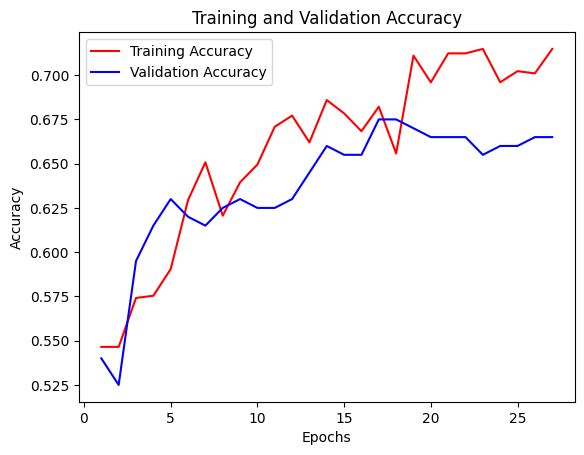

In [184]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [185]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(only_demo_X_train), 0)
test_preds = np.round(model.predict(only_demo_X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [186]:
# train results
trainResults = classification_report(only_demo_y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.72      0.81      0.77       463
         1.0       0.69      0.57      0.62       333

    accuracy                           0.71       796
   macro avg       0.71      0.69      0.69       796
weighted avg       0.71      0.71      0.71       796



In [187]:
# train confusion matrix
print("This is train: \n", confusion_matrix(only_demo_y_train, train_preds))

This is train: 
 [[377  86]
 [144 189]]


In [188]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.


print("This is train:")
tn, fp, fn, tp = confusion_matrix(only_demo_y_train, train_preds).ravel()
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 189 - 23.74 %
TN: 377 - 47.36 %
FP: 86 - 10.8 %
FN: 144 - 18.09 %


In [189]:
# test results
testResults = classification_report(only_demo_y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.71      0.78      0.74       120
         1.0       0.61      0.53      0.56        80

    accuracy                           0.68       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.67      0.68      0.67       200



In [190]:
# test confusion matrix
print("This is test: \n", confusion_matrix(only_demo_y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos


This is test: 
 [[93 27]
 [38 42]]


In [191]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 42 - 21.0 %
TN: 93 - 46.5 %
FP: 27 - 13.5 %
FN: 38 - 19.0 %


## **BEST MODEL Model #1**: Combined Demographic and Accelerometer Data; Strategy 1, Same Number of Hidden Nodes as Input Features (167), 1 Layer, Dropout = 0.3

In [192]:
# Refresh train and test shaoes before modeling
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
# good shapes

X_train shape: (796, 167)
y_train shape: (796, 1)
X_test shape: (200, 167)
y_test shape: (200, 1)


In [193]:
# Build Model #1:
# Let's use the number of features as the number of hidden units
# Strategy 1 from DrD CheatSheet_BuildingFFNNs notebook

# To set the weights for model to mitigate against training learning
# during reruns:

def create_model1():
  model = Sequential()
  model.add(Dense(167, input_shape=(X_train.shape[1],), activation='relu'))
# don't forget to add an input shape! (features,)(167 cols)
# model.add(Dropout(0.3))
# specify a percentage between 0 and 0.5 (after each dense layer)
# model.add(Dense(84, activation='relu'))
# input shape is inherited from prev layer
  model.add(Dropout(0.3))
# specify a percentage between 0 and 0.5 (after each dense layer)
  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_model1()

# Summarize the model architecture
model.summary()
# 28,224 parms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,224 (110.25 KB)

 Trainable params: 28,224 (110.25 KB)

 Non-trainable params: 0 (0.00 B)

In [194]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])       # loss function improves when more confident when values are going nearer to 0 and 1



In [195]:
# Add early stopping
es = EarlyStopping(monitor='val_accuracy',
                            mode='max',  # don't minimize the accuracy!
                            patience=10, # wait for 10 epochs w no improvement before stopping
                            restore_best_weights=True)

In [196]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

# Let's initialize then reset weights
# Save initial weights
initial_weights = model.get_weights()


# Fit the model with the reshaped data
history = model.fit(X_train, y_train,  # Input data and target variable
                    validation_data=(X_test, y_test),
                    callbacks=[es],        # Early stopping callback
                    epochs=100000,         # Set a large number of epochs
                    batch_size=50,         # Number of samples per batch
                    shuffle=True,          # Shuffle the data for each epoch
                    verbose=1)             # Output the training progress

# When X_test converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4931 - loss: 0.7707 - val_accuracy: 0.6550 - val_loss: 0.6423
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6404 - loss: 0.6488 - val_accuracy: 0.6450 - val_loss: 0.6003
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6856 - loss: 0.5945 - val_accuracy: 0.6850 - val_loss: 0.5848
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7429 - loss: 0.5200 - val_accuracy: 0.6900 - val_loss: 0.5718
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7179 - loss: 0.5528 - val_accuracy: 0.6900 - val_loss: 0.5729
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7533 - loss: 0.4971 - val_accuracy: 0.6950 - val_loss: 0.5657
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7537 - loss: 0.5140 - val_accuracy: 0.6550 - val_loss: 0.5716
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7584 - loss: 0.4984 -

### Model Results: trainF1 = 88%, testF1 = 72%

In [197]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

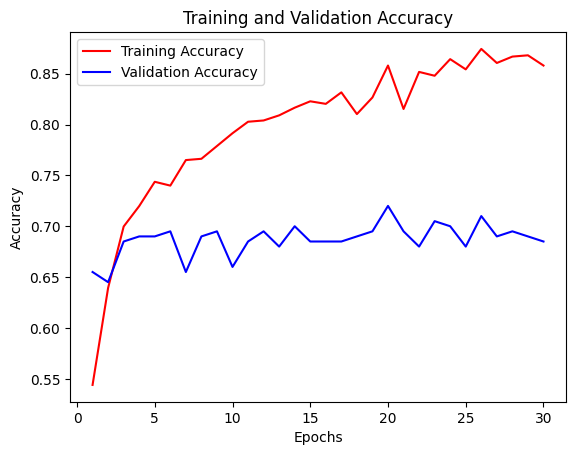

In [198]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [199]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train), 0)
test_preds = np.round(model.predict(X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [200]:
# train results
trainResults = classification_report(y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.89      0.89      0.89       463
         1.0       0.85      0.85      0.85       333

    accuracy                           0.88       796
   macro avg       0.87      0.87      0.87       796
weighted avg       0.88      0.88      0.88       796



In [201]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train, train_preds))

This is train: 
 [[414  49]
 [ 49 284]]


In [202]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 284 - 35.68 %
TN: 414 - 52.01 %
FP: 49 - 6.16 %
FN: 49 - 6.16 %


In [203]:
# test results
testResults = classification_report(y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.78      0.75      0.76       120
         1.0       0.64      0.68      0.66        80

    accuracy                           0.72       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.72      0.72      0.72       200



In [204]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[90 30]
 [26 54]]


In [205]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 54 - 27.0 %
TN: 90 - 45.0 %
FP: 30 - 15.0 %
FN: 26 - 13.0 %


## Model #2: Combined Data; Strategy 2, Hidden Nodes = 2x Input Features (334), 1 Layer, Dropout = 0.3


In [206]:
# Add another dense layer to Model #1
# Double the number of features as the number of hidden units
# Strategy 2 from DrD CheatSheet_BuildingFFNNs notebook

def create_model2():
  model = Sequential()
  model.add(Dense(334, input_shape=(X_train.shape[1],), activation='relu'))
  model.add(Dropout(0.3))
# specify a percentage between 0 and 0.5 (after each dense layer)
  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_model2()

# Summarize the model architecture
model.summary()
# 56,447 parms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 334)                 │          56,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 334)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             335 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,447 (220.50 KB)

 Trainable params: 56,447 (220.50 KB)

 Non-trainable params: 0 (0.00 B)

In [207]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])       # loss function improves when more confident when values are going nearer to 0 and 1

In [208]:
es = EarlyStopping(monitor='val_accuracy',
                            mode='max', # don't minimize the accuracy!
                            patience=10,
                            restore_best_weights=True)

In [209]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

history = model.fit(X_train, y_train,   # input data, target var
                    validation_data = (X_test, y_test),
                    callbacks=[es],     # early stopping callbacks encouraged
                    epochs=100000,      # set epochs to a big number
                    batch_size=50,      # hyperparameter means 50 batches of data in each epoch
                    shuffle=True,       # best practice to shuffle your data
                    verbose=1)          # prints the output as the model trains
# When X_text converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4888 - loss: 0.7604 - val_accuracy: 0.6600 - val_loss: 0.6206
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6677 - loss: 0.6148 - val_accuracy: 0.6800 - val_loss: 0.5772
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7144 - loss: 0.5510 - val_accuracy: 0.7150 - val_loss: 0.5718
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7418 - loss: 0.5181 - val_accuracy: 0.6950 - val_loss: 0.5639
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7694 - loss: 0.4971 - val_accuracy: 0.7000 - val_loss: 0.5657
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7797 - loss: 0.4632 - val_accuracy: 0.6950 - val_loss: 0.5682
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7707 - loss: 0.4622 - val_accuracy: 0.6750 - val_loss: 0.5607
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7998 - loss: 0.4310 -

### Model Results: trainF1 = 86%, testF1 = 72%

Results were the SAME AS MODEL #1 - no performance improvement with increased complexity.

In [210]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

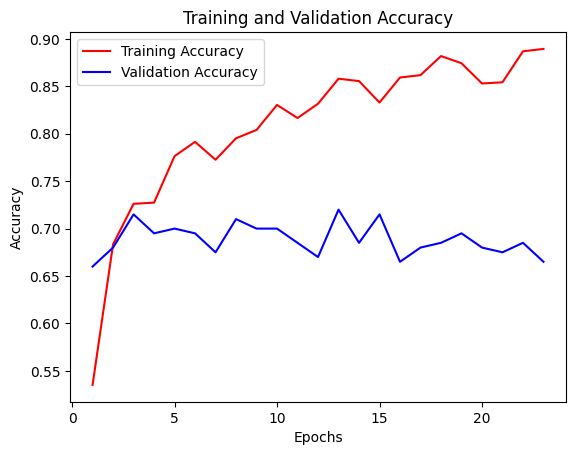

In [211]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [212]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train), 0)
test_preds = np.round(model.predict(X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [213]:
# train results
trainResults = classification_report(y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       463
         1.0       0.84      0.83      0.84       333

    accuracy                           0.86       796
   macro avg       0.86      0.86      0.86       796
weighted avg       0.86      0.86      0.86       796



In [214]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train, train_preds))

This is train: 
 [[410  53]
 [ 55 278]]


In [215]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 278 - 34.92 %
TN: 410 - 51.51 %
FP: 53 - 6.66 %
FN: 55 - 6.91 %


In [216]:
# test results
testResults = classification_report(y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       120
         1.0       0.66      0.62      0.64        80

    accuracy                           0.72       200
   macro avg       0.71      0.70      0.71       200
weighted avg       0.72      0.72      0.72       200



In [217]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[94 26]
 [30 50]]


In [218]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 50 - 25.0 %
TN: 94 - 47.0 %
FP: 26 - 13.0 %
FN: 30 - 15.0 %


## Model #3: Model #1 with Reduced Dropout = 0.1, Lower LR, Increase Batch Size and Patience = 50, Monitor val_loss

Same results despite making these changes. Monitored val_loss because  validation accuracy can plateau while validation loss continues to decrease, indicating potential model improvements.

In [219]:
# Build Model #3: same as Model #1 but reduced dropout = 0.1,
# Lower LR, Smaller Batch Size = 10,
# Increase Batch Size and Patience = 50, Monitor val_loss

# Reduce learning rate when learning plateaus
# learn better?

# number of features = number of hidden units
# Strategy 1 from DrD CheatSheet_BuildingFFNNs notebook

def create_model3():
  model = Sequential()
  model.add(Dense(167, input_shape=(X_train.shape[1],), activation='relu'))
  model.add(Dropout(0.1))
# specify a percentage between 0 and 0.5 (after each dense layer)
  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model


# Call the function to create the model
model = create_model3()

# Summarize the model architecture
model.summary()
# 28,224 parms

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0.00001)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,224 (110.25 KB)

 Trainable params: 28,224 (110.25 KB)

 Non-trainable params: 0 (0.00 B)

In [220]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])       # loss function improves when more confident when values are going nearer to 0 and 1

In [221]:
# es = EarlyStopping(monitor='val_accuracy',
#                             mode='max', # don't minimize the accuracy!
es = EarlyStopping(monitor='val_loss',
                            mode='min', # don't minimize the accuracy!
# Validation accuracy can plateau while validation loss
# continues to decrease, indicating potential improvements
                            patience=50,
                            restore_best_weights=True)

In [222]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

history = model.fit(X_train, y_train,   # input data, target var
                    validation_data = (X_test, y_test),
#                   callbacks=[es],     # early stopping callbacks encouraged
                    callbacks=[es, reduce_lr], # try reducing lr when learning plateaus
                    epochs=100000,      # set epochs to a big number
                    batch_size=50,      # hyperparameter means 50 batches of data in each epoch
                    shuffle=True,       # best practice to shuffle your data
                    verbose=1)          # prints the output as the model trains
# When X_text converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5401 - loss: 0.7780 - val_accuracy: 0.6550 - val_loss: 0.6128 - learning_rate: 0.0010
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6541 - loss: 0.6236 - val_accuracy: 0.6950 - val_loss: 0.5849 - learning_rate: 0.0010
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7476 - loss: 0.5423 - val_accuracy: 0.6850 - val_loss: 0.5676 - learning_rate: 0.0010
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7629 - loss: 0.5272 - val_accuracy: 0.7050 - val_loss: 0.5600 - learning_rate: 0.0010
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7795 - loss: 0.4967 - val_accuracy: 0.6900 - val_loss: 0.5542 - learning_rate: 0.0010
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7816 - loss: 0.4647 - val_accuracy: 0.7100 - val_loss: 0.5497 - learning_rate: 0.0010
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7772 - 

### Model Results: trainF1 = 83%, testF1 = 71%

In [223]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])

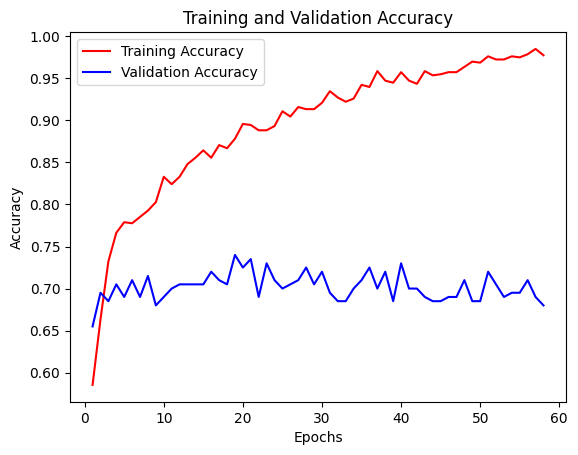

In [224]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [225]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train), 0)
test_preds = np.round(model.predict(X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [226]:
# train results
trainResults = classification_report(y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       463
         1.0       0.84      0.74      0.79       333

    accuracy                           0.83       796
   macro avg       0.84      0.82      0.83       796
weighted avg       0.83      0.83      0.83       796



In [227]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train, train_preds))

This is train: 
 [[417  46]
 [ 86 247]]


In [228]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 247 - 31.03 %
TN: 417 - 52.39 %
FP: 46 - 5.78 %
FN: 86 - 10.8 %


In [229]:
# test results
testResults = classification_report(y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.74      0.80      0.77       120
         1.0       0.66      0.59      0.62        80

    accuracy                           0.71       200
   macro avg       0.70      0.69      0.70       200
weighted avg       0.71      0.71      0.71       200



In [230]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[96 24]
 [33 47]]


In [231]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 47 - 23.5 %
TN: 96 - 48.0 %
FP: 24 - 12.0 %
FN: 33 - 16.5 %


## Model #4: Strategy 3, >=2 Layers, Hidden Nodes =  Input Features (167), Dropout = 0.1

In [232]:
# Build Model #4:
# Two or more layers, same number of hidden units as input data features
# Strategy 3 from DrD CheatSheet_BuildingFFNNs notebook

def create_model4():
  model = Sequential()
  model.add(Dense(167, input_shape=(X_train.shape[1],), activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(167, activation='relu'))
# input shape is inherited from prev layer
  model.add(Dropout(0.1))

  model.add(Dense(167, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(167, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_model4()

# Summarize the model architecture
model.summary()
# 112,392 parms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             168 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 112,392 (439.03 KB)

 Trainable params: 112,392 (439.03 KB)

 Non-trainable params: 0 (0.00 B)

In [233]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])       # loss function improves when more confident when values are going nearer to 0 and 1

In [234]:
# Add early stopping
es = EarlyStopping(monitor='val_accuracy',
                            mode='max',  # don't minimize the accuracy!
                            patience=10, # wait for 10 epochs w no improvement before stopping
                            restore_best_weights=True)

In [235]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

# Let's initialize then reset weights
# Save initial weights
initial_weights = model.get_weights()


# Fit the model with the reshaped data
history = model.fit(X_train, y_train,  # Input data and target variable
                    validation_data=(X_test, y_test),
                    callbacks=[es],        # Early stopping callback
                    epochs=100000,         # Set a large number of epochs
                    batch_size=50,         # Number of samples per batch
                    shuffle=True,          # Shuffle the data for each epoch
                    verbose=1)             # Output the training progress

# When X_test converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5509 - loss: 0.6849 - val_accuracy: 0.6500 - val_loss: 0.6373
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6644 - loss: 0.6271 - val_accuracy: 0.6850 - val_loss: 0.6028
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7514 - loss: 0.5622 - val_accuracy: 0.6850 - val_loss: 0.5951
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7640 - loss: 0.5106 - val_accuracy: 0.7050 - val_loss: 0.5891
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7801 - loss: 0.4699 - val_accuracy: 0.6750 - val_loss: 0.5923
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8042 - loss: 0.4498 - val_accuracy: 0.6700 - val_loss: 0.6233
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8380 - loss: 0.3683 - val_accuracy: 0.6550 - val_loss: 0.6777
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8184 - loss: 0.4024 -

### Model Results: trainF1 = 78%, testF1 = 69%

In [236]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

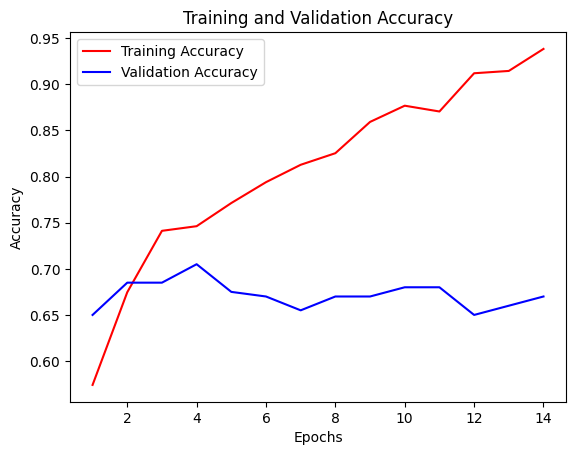

In [237]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [238]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train), 0)
test_preds = np.round(model.predict(X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [239]:
# train results
trainResults = classification_report(y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       463
         1.0       0.83      0.60      0.70       333

    accuracy                           0.78       796
   macro avg       0.80      0.76      0.77       796
weighted avg       0.79      0.78      0.78       796



In [240]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train, train_preds))

This is train: 
 [[423  40]
 [132 201]]


In [241]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 201 - 25.25 %
TN: 423 - 53.14 %
FP: 40 - 5.03 %
FN: 132 - 16.58 %


In [242]:
# test results
testResults = classification_report(y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.71      0.85      0.78       120
         1.0       0.68      0.49      0.57        80

    accuracy                           0.70       200
   macro avg       0.70      0.67      0.67       200
weighted avg       0.70      0.70      0.69       200



In [243]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[102  18]
 [ 41  39]]


In [244]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 39 - 19.5 %
TN: 102 - 51.0 %
FP: 18 - 9.0 %
FN: 41 - 20.5 %


## Model #5: Strategy 4, Info Funnel: >= 2 Layers, Decreasing Hidden Nodes by Half

In [245]:
def create_model5():
  model = Sequential()
  model.add(Dense(167, input_shape=(X_train.shape[1],), activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(83, activation='relu'))
# input shape is inherited from prev layer
  model.add(Dropout(0.1))

  model.add(Dense(41, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(20, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(10, activation='relu'))
  model.add(Dropout(0.1))

  model.add(Dense(1, activation='sigmoid'))
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_model5()

# Summarize the model architecture
model.summary()
# 112,392 parms

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 167)                 │          28,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 167)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 83)                  │          13,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 83)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 41)                  │           3,444 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 41)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 20)                  │             840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,505 (181.66 KB)

 Trainable params: 46,505 (181.66 KB)

 Non-trainable params: 0 (0.00 B)

In [246]:
# compile the model, default Adam learning rate is 0.001
model.compile(optimizer='Adam',           # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])

In [247]:
# Add early stopping
es = EarlyStopping(monitor='val_accuracy',
                            mode='max',  # don't minimize the accuracy!
                            patience=10, # wait for 10 epochs w no improvement before stopping
                            restore_best_weights=True)

In [248]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

initial_weights = model.get_weights()


# Fit the model with the reshaped data
history = model.fit(X_train, y_train,  # Input data and target variable
                    validation_data=(X_test, y_test),
                    callbacks=[es],        # Early stopping callback
                    epochs=100000,         # Set a large number of epochs
                    batch_size=50,         # Number of samples per batch
                    shuffle=True,          # Shuffle the data for each epoch
                    verbose=1)             # Output the training progress

# When X_test converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4915 - loss: 0.7618 - val_accuracy: 0.6100 - val_loss: 0.6715
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6095 - loss: 0.6687 - val_accuracy: 0.6150 - val_loss: 0.6514
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6307 - loss: 0.6587 - val_accuracy: 0.6550 - val_loss: 0.6368
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6231 - loss: 0.6403 - val_accuracy: 0.6450 - val_loss: 0.6071
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6495 - loss: 0.6206 - val_accuracy: 0.6900 - val_loss: 0.5867
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6888 - loss: 0.5846 - val_accuracy: 0.6900 - val_loss: 0.5747
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7243 - loss: 0.5527 - val_accuracy: 0.6850 - val_loss: 0.5753
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7811 - loss: 0.5102 -

### Model Results: trainF1 = 94%, testF1 = 72%

In [249]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

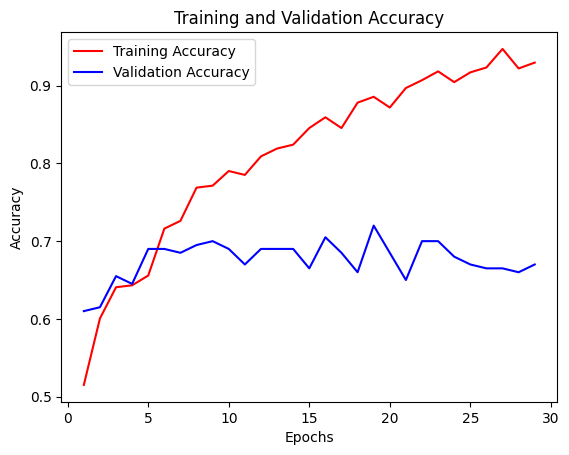

In [250]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [251]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train), 0)
test_preds = np.round(model.predict(X_test), 0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [252]:
# train results
trainResults = classification_report(y_train, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       463
         1.0       0.93      0.92      0.92       333

    accuracy                           0.94       796
   macro avg       0.94      0.93      0.94       796
weighted avg       0.94      0.94      0.94       796



In [253]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train, train_preds))

This is train: 
 [[440  23]
 [ 27 306]]


In [254]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 306 - 38.44 %
TN: 440 - 55.28 %
FP: 23 - 2.89 %
FN: 27 - 3.39 %


In [255]:
# test results
testResults = classification_report(y_test, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.76      0.78      0.77       120
         1.0       0.66      0.62      0.64        80

    accuracy                           0.72       200
   macro avg       0.71      0.70      0.71       200
weighted avg       0.72      0.72      0.72       200



In [256]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[94 26]
 [30 50]]


In [257]:
# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 50 - 25.0 %
TN: 94 - 47.0 %
FP: 26 - 13.0 %
FN: 30 - 15.0 %


## Model #6: Downsampling

Read first 0:300 parquet files, every 300th sample, with 2 minute timeout: processing time = 29.5 minutes. 2nd 300 id's = 30 min. 3rd 396 id's = 41min

Net net 10 id's/minute sampling every 300th with 2 min timeout.

In [258]:
import signal
# used for managing interruptions,
# timeouts, or termination requests

fc_settings = EfficientFCParameters()

# Timeout handler
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Path to the directory containing parquet files
parquet_dir_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet"
results_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling"
os.makedirs(results_dir, exist_ok=True)

# Recursively find all parquet files
parquet_files = []
for root, dirs, files in os.walk(parquet_dir_path):
    for file in files:
        if file.endswith('.parquet'):
            parquet_files.append(os.path.join(root, file))

# Limit to the first N_low files to N_high files
# 1st 300 files: start 7:35am, end 8:05am
#   29m 34s completed at 8:04 AM
# 2nd 300 files: start 8:06am, end 8:37am
# 3rd 396v files: start 9:38am

N_low = 601
N_high = 996 # I ran 0:300, 301:600, 600:996
parquet_files = parquet_files[N_low:N_high] # you can edit this! copy the notebook and run in chunks manually

# Process each parquet file
for parquet_file in parquet_files:
    try:
        print(f"Processing file: {parquet_file}")

        # Set a timeout of 2 minutes for processing
        signal.signal(signal.SIGALRM, timeout_handler)
        signal.alarm(120) # you can update this!

        # Load the parquet file as a Dask DataFrame
        df = dd.read_parquet(parquet_file)

        # Ensure 'id' column exists for tsfresh
        if 'id' not in df.columns:
            df['id'] = 1  # Assign a default ID if missing

        # Add a 'time' column if it doesn't exist
        if 'time' not in df.columns:
            df = df.reset_index()
            df['time'] = df.index  # Use the index as the 'time' column

        # Downsample to include every 300th observation
        # Students: you will possibly want to play with this as a hyperparm
        # The bigger the number, the faster it runs, but the coarser the data (less insights possibly)
        df = df[df['time'] % 300 == 0] # you can update this!

        # Extract features using tsfresh
        X = extract_features(
            df,
            column_id="id",
            column_sort="time",
            default_fc_parameters=fc_settings,
            pivot=True
        )

        # Compute the result to get it as a Pandas DataFrame
        result = X.compute()

        # Extract the parquet ID from the file path and use it to name the CSV file
        parquet_id = os.path.basename(os.path.dirname(parquet_file))
        output_file = os.path.join(results_dir, f"{parquet_id}.csv")
        result.to_csv(output_file, index=False)

        print(f"Saved result to: {output_file}")

        # Reset the timeout
        signal.alarm(0)

    except TimeoutException:
        print(f"Skipping file due to timeout: {parquet_file}")
    except Exception as e:
        print(f"Error processing file {parquet_file}: {e}")

print("Processing complete.")


Processing file: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=9cee3c19/part-0.parquet
Saved result to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling/id=9cee3c19.csv
Processing file: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=9cf04c41/part-0.parquet
Saved result to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling/id=9cf04c41.csv
Processing file: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=9d0670dd/part-0.parquet
Saved result to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling/id=9d0670dd.csv
Processing file: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/series_train.parquet/id=9d1b2d2c/part-0.parquet
Saved result to: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling/id=9d1b2d2c.csv
Processing file: /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project

### Housekeeping: Count Downsampled Files
994 files, 2 short of 996.

In [259]:
# Count number of .csv downsampled files

def count_csv_files(directory):
  """Counts the number of .csv files in a given directory.

  Args:
    directory: The path to the directory to search.

  Returns:
    The number of .csv files in the directory.
  """
  count = 0
  for filename in os.listdir(directory):
    if filename.endswith(".csv"):
      count += 1
  return count

# Replace 'directory_path' with YOUR actual directory name
directory_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling'
csv_count = count_csv_files(directory_path)
print(f"Number of .csv files in {directory_path}: {csv_count}")
# 994 (2 short of 996)

Number of .csv files in /content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling: 994


### Join Downsampled Files

Shape is (994, 10879). The downsampled df = combined_df.


### Join Demographic Data With Downsampled Accelerometer Data

Join train_df with  combined_df (downsampled accelerometer data) in preparation for modeling.

    train_df shape: (996, 29)

    X_train_F24_withID (796, 15)
    y_train_F24_withID (796, 2)
    X_test_F24_withID  (200, 15)
    y_test_F24_withID  (200, 2)

    combined_df shape: (994, 10879)

    X_train_ds_df shape: (796, 169)
    y_train_ds_df shape: (796, 169)
    X_test_ds_df shape: (200, 169)
    y_test_ds_df shape: (200, 169)

💚 Approach

1. The mean data in the _F24_withID files are now redundant with the larger features files such as combined_df. We only need the 'id' column from the mean datasets to break out X/y/train/test.
2. Join the reduced train_df demographic data with combined_df accelerometer data, based on the id's in the _F24_withID files.

Ran 5 minutes.

In [360]:
# Use X_train_F24_withID as source of ids for join

# File paths for datasets
X_train_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_F24_withID.csv"
combined_df_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling"

from glob import glob
# Combine all CSV files in the combined_df directory and add 'id' column
all_csv_files = glob(os.path.join(combined_df_dir, "*.csv"))
combined_df_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    combined_df_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("X_train_F24_withID shape:", X_train_F24_withID.shape)
print("combined_df shape:", combined_df.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in X_train_F24_withID.columns, "X_train_F24_withID must have an 'id' column."
assert 'id' in combined_df.columns, "combined_df must have an 'id' column."

# Merge the datasets on 'id'
X_train_ds_df = (
    train_df
    .merge(combined_df, on='id', how='inner')       # Join with combined combined_df
    .merge(X_train_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from X_train_F24_withID
)

# Debug: Check the shape and columns of the combined DataFrame
print("X_train_ds_df_df:", X_train_ds_df.shape)
print("X_train_ds_df columns:", X_train_ds_df.columns)


# Save the combined DataFrame to a new CSV file (optional)
X_train_ds_df.to_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_ds_df.csv', index=False)
print(X_train_ds_df.shape)


train_df shape: (996, 29)
X_train_F24_withID shape: (796, 15)
combined_df shape: (994, 10879)
X_train_combined_df: (794, 10907)
X_train_combined_df columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__symmetry_looking__r_0.9500000000000001',
       'weekday__time_reversal_asymmetry_statistic__lag_1',
       'weekday__time_reversal_asymmetry_statistic__lag_2',
       'weekday__time_reversal_asymmetry_statistic__lag_3', 'weekday__value_count__value_-1',
       'weekday__value_count__value_0', 'weekday__value_count__value_1', 'weekday__variance',
       'weekday__variance_larger_than_standard_deviation', 'weekday__variation_coefficient'],
      dtype='object', length=10907)
(794, 10907)


In [361]:
# Use y_train_F24_withID as source of ids for join

# File paths for datasets
y_train_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_F24_withID.csv"
combined_df_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling"

from glob import glob
# Combine all CSV files in the combined_df directory and add 'id' column
all_csv_files = glob(os.path.join(combined_df_dir, "*.csv"))
combined_df_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    combined_df_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("y_train_F24_withID shape:", y_train_F24_withID.shape)
print("combined_df shape:", combined_df.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in y_train_F24_withID.columns, "y_train_F24_withID must have an 'id' column."
assert 'id' in combined_df.columns, "combined_df must have an 'id' column."

# Merge the datasets on 'id'
y_train_ds_df = (
    train_df
    .merge(combined_df, on='id', how='inner')       # Join with combined combined_df
    .merge(y_train_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from y_train_F24_withID
)

# Debug: Check the shape and columns of the combined DataFrame
print("y_train_combined_df:", y_train_ds_df.shape)
print("y_train_combined_df columns:", y_train_ds_df.columns)


# Save the combined DataFrame to a new CSV file (optional)
y_train_ds_df.to_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_ds_df.csv', index=False)
print(y_train_ds_df.shape)



train_df shape: (996, 29)
y_train_F24_withID shape: (796, 2)
combined_df shape: (994, 10879)
y_train_combined_df: (794, 10907)
y_train_combined_df columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__symmetry_looking__r_0.9500000000000001',
       'weekday__time_reversal_asymmetry_statistic__lag_1',
       'weekday__time_reversal_asymmetry_statistic__lag_2',
       'weekday__time_reversal_asymmetry_statistic__lag_3', 'weekday__value_count__value_-1',
       'weekday__value_count__value_0', 'weekday__value_count__value_1', 'weekday__variance',
       'weekday__variance_larger_than_standard_deviation', 'weekday__variation_coefficient'],
      dtype='object', length=10907)
(794, 10907)


In [362]:
# Use X_test_F24_withID as source of ids for join

# File paths for datasets
X_test_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_F24_withID.csv"
combined_df_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling"

from glob import glob
# Combine all CSV files in the combined_df directory and add 'id' column
all_csv_files = glob(os.path.join(combined_df_dir, "*.csv"))
combined_df_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    combined_df_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("X_test_F24_withID shape:", X_test_F24_withID.shape)
print("combined_df shape:", combined_df.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in X_test_F24_withID.columns, "X_test_F24_withID must have an 'id' column."
assert 'id' in combined_df.columns, "combined_df must have an 'id' column."

# Merge the datasets on 'id'
X_test_ds_df = (
    train_df
    .merge(combined_df, on='id', how='inner')       # Join with combined combined_df
    .merge(X_test_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from X_test_F24_withID
)

# Debug: Check the shape and columns of the combined DataFrame
print("X_test_ds_df:", X_test_ds_df.shape)
print("X_test_ds_df columns:", X_test_ds_df.columns)


# Save the combined DataFrame to a new CSV file (optional)
X_test_ds_df.to_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_ds_df.csv', index=False)
print(X_test_ds_df.shape)




train_df shape: (996, 29)
X_test_F24_withID shape: (200, 15)
combined_df shape: (994, 10879)
X_test_ds_df: (200, 10907)
X_test_ds_df columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__symmetry_looking__r_0.9500000000000001',
       'weekday__time_reversal_asymmetry_statistic__lag_1',
       'weekday__time_reversal_asymmetry_statistic__lag_2',
       'weekday__time_reversal_asymmetry_statistic__lag_3', 'weekday__value_count__value_-1',
       'weekday__value_count__value_0', 'weekday__value_count__value_1', 'weekday__variance',
       'weekday__variance_larger_than_standard_deviation', 'weekday__variation_coefficient'],
      dtype='object', length=10907)
(200, 10907)


In [363]:
# Use y_test_F24_withID as source of ids for join

# File paths for datasets
y_test_F24_withID_path = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_F24_withID.csv"
combined_df_dir = "/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/Downsampling"

from glob import glob
# Combine all CSV files in the combined_df directory and add 'id' column
all_csv_files = glob(os.path.join(combined_df_dir, "*.csv"))
combined_df_list = []

for file in all_csv_files:
    # Extract the 'id' from the filename, assuming it's formatted as 'id=XXXXXX.csv'
    file_name = os.path.basename(file)
    file_id = file_name.split('=')[1].split('.')[0]  # Extract the part after 'id=' and before '.csv'

    # Read the CSV file
    df = pd.read_csv(file)

    # Add 'id' as the first column
    df.insert(0, 'id', file_id)

    # Append to the list
    combined_df_list.append(df)

# Concatenate all individual CSV files into a single DataFrame
combined_df = pd.concat(combined_df_list, ignore_index=True)

# Debug: Check initial shapes and columns
print("train_df shape:", train_df.shape)
print("y_test_F24_withID shape:", y_test_F24_withID.shape)
print("combined_df shape:", combined_df.shape)

# Ensure 'id' column exists in all datasets
assert 'id' in train_df.columns, "train_df must have an 'id' column."
assert 'id' in y_test_F24_withID.columns, "y_test_F24_withID must have an 'id' column."
assert 'id' in combined_df.columns, "combined_df must have an 'id' column."

# Merge the datasets on 'id'
y_test_ds_df = (
    train_df
    .merge(combined_df, on='id', how='inner')       # Join with combined combined_df
    .merge(y_test_F24_withID[['id']], on='id', how='inner')  # Join only 'id' from y_test_F24_withID
)

# Debug: Check the shape and columns of the combined DataFrame
print("y_test_ds_df:", y_test_ds_df.shape)
print("y_test_ds_df columns:", y_test_ds_df.columns)


# Save the combined DataFrame to a new CSV file (optional)
y_test_ds_df.to_csv('/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_ds_df.csv', index=False)
print(y_test_ds_df.shape)



train_df shape: (996, 29)
y_test_F24_withID shape: (200, 2)
combined_df shape: (994, 10879)
y_test_ds_df: (200, 10907)
y_test_ds_df columns: Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU_Zone',
       'FGC-FGC_PU_Zone',
       ...
       'weekday__symmetry_looking__r_0.9500000000000001',
       'weekday__time_reversal_asymmetry_statistic__lag_1',
       'weekday__time_reversal_asymmetry_statistic__lag_2',
       'weekday__time_reversal_asymmetry_statistic__lag_3', 'weekday__value_count__value_-1',
       'weekday__value_count__value_0', 'weekday__value_count__value_1', 'weekday__variance',
       'weekday__variance_larger_than_standard_deviation', 'weekday__variation_coefficient'],
      dtype='object', length=10907)
(200, 10907)


In [372]:
# To be able to rerun from here without doing merge above

file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_train_ds_df.csv'
X_train_ds_df = pd.read_csv(file_path)
print(X_train_ds_df.shape) # Display shape of dataframe


file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_train_ds_df.csv'
y_train_ds_df = pd.read_csv(file_path)
print(y_train_ds_df.shape) # Display shape of dataframe

file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/X_test_ds_df.csv'
X_test_ds_df = pd.read_csv(file_path)
print(X_test_ds_df.shape) # Display shape of dataframe

file_path = '/content/drive/MyDrive/OPIM_5509_Deep_Learning/Data/Project/y_test_ds_df.csv'
y_test_ds_df = pd.read_csv(file_path)
print(y_test_ds_df.shape) # Display shape of dataframe

(794, 10907)
(794, 10907)
(200, 10907)
(200, 10907)


### Drop 'id' From All Files

In [373]:
# Drop 'id' from combined_df files
X_train_ds_df = X_train_ds_df.drop(columns=['id'])
y_train_ds_df = y_train_ds_df.drop(columns=['id'])
X_test_ds_df = X_test_ds_df.drop(columns=['id'])
y_test_ds_df = y_test_ds_df.drop(columns=['id'])
# Check work
print("X_train_ds_df shape:", X_train_ds_df.shape)

print("y_train_ds_df shape:", y_train_ds_df.shape)

print("X_test_ds_df shape:", X_test_ds_df.shape)

print("y_test_ds_df shape:", y_test_ds_df.shape)



X_train_ds_df shape: (794, 10906)
y_train_ds_df shape: (794, 10906)
X_test_ds_df shape: (200, 10906)
y_test_ds_df shape: (200, 10906)


### Prevent Data Leakage: Drop 'sii' from X_train, X_test Files

In [374]:
# Keep all columns except the target variable 'sii' for X_train and X_test
X_train_ds_df = X_train_ds_df.drop(columns=['sii'])
X_test_ds_df = X_test_ds_df.drop(columns=['sii'])

# Keep only the target variable 'sii' for y_train and y_test
y_train_ds_df = y_train_ds_df['sii'] if 'sii' in y_train_ds_df else None
y_test_ds_df = y_test_ds_df['sii'] if 'sii' in y_test_ds_df else None

# Verify the shapes of the datasets
print("X_train_ds_df shape:", X_train_ds_df.shape)
print("X_test_ds_df shape:", X_test_ds_df.shape)
print("y_train_ds_df shape:", y_train_ds_df.shape)
print("y_test_ds_df shape:", y_test_ds_df.shape)

# Ensure the datasets are properly aligned
assert X_train_ds_df.shape[0] == y_train_ds_df.shape[0], "Mismatch between X_train_ds_df and y_train_ds_df sizes."
assert X_test_ds_df.shape[0] == y_test_ds_df.shape[0], "Mismatch between X_test_ds_df and y_test_ds_df sizes."

X_train_ds_df shape: (794, 10905)
X_test_ds_df shape: (200, 10905)
y_train_ds_df shape: (794,)
y_test_ds_df shape: (200,)


### Convert to Numby Arrays

In [375]:
# Convert input features and target variables to numpy arrays
X_train_ds_df = X_train_ds_df.to_numpy()  # Convert to numpy array
X_test_ds_df= X_test_ds_df.to_numpy()    # Convert to numpy array
# Ensure target variables are numpy arrays and reshape them to (n_samples, 1)
y_train_ds_df = y_train_ds_df.to_numpy().reshape(-1, 1)
y_test_ds_df = y_test_ds_df.to_numpy().reshape(-1, 1)

In [376]:
# Check work
print("X_train_ds_df shape:", X_train_ds_df.shape)
print("y_train_ds_df shape:", y_train_ds_df.shape)
print("X_test_ds_df shape:", X_test_ds_df.shape)
print("y_test_ds_df shape:", y_test_ds_df.shape)

X_train_ds_df shape: (794, 10905)
y_train_ds_df shape: (794, 1)
X_test_ds_df shape: (200, 10905)
y_test_ds_df shape: (200, 1)


### Check for Nans, Infinites

In [379]:
# Replace np.nan and np.inf with 0 for all datasets
X_train_ds_df = np.nan_to_num(X_train_ds_df, nan=0, posinf=0, neginf=0)
y_train_ds_df = np.nan_to_num(y_train_ds_df, nan=0, posinf=0, neginf=0)
X_test_ds_df = np.nan_to_num(X_test_ds_df, nan=0, posinf=0, neginf=0)
y_test_ds_df = np.nan_to_num(y_test_ds_df, nan=0, posinf=0, neginf=0)

# Check again for NaN or infinity
print("NaN in X_train_ds_df:", np.isnan(X_train_ds_df).sum())
print("NaN in y_train_ds_df:", np.isnan(y_train_ds_df).sum())
print("NaN in X_test_ds_df:", np.isnan(X_test_ds_df).sum())
print("NaN in y_test_ds_df:", np.isnan(y_test_ds_df).sum())

print("Infinity in X_train_ds_df:", np.isinf(X_train_ds_df).sum())
print("Infinity in y_train_ds_df:", np.isinf(y_train_ds_df).sum())
print("Infinity in X_test_ds_df:", np.isinf(X_test_ds_df).sum())
print("Infinity in y_test_ds_df:", np.isinf(y_test_ds_df).sum())


NaN in X_train_ds_df: 0
NaN in y_train_ds_df: 0
NaN in X_test_ds_df: 0
NaN in y_test_ds_df: 0
Infinity in X_train_ds_df: 0
Infinity in y_train_ds_df: 0
Infinity in X_test_ds_df: 0
Infinity in y_test_ds_df: 0


### StandardScaler

In [380]:
scaler = StandardScaler()
X_train_ds_df = scaler.fit_transform(X_train_ds_df)
X_test_ds_df = scaler.transform(X_test_ds_df) # apply


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1156: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:84: RuntimeWarning: overflow encountered in multiply
  upper_bound = n

### Model

In [381]:
# Refresh train and test shaoes before modeling
print("X_train_ds_df shape:", X_train_ds_df.shape)
print("y_train_ds_df shape:", y_train_ds_df.shape)
print("X_test_ds_df shape:", X_test_ds_df.shape)
print("y_test_ds_df shape:", y_test_ds_df.shape)
# good shapes

X_train_ds_df shape: (794, 10905)
y_train_ds_df shape: (794, 1)
X_test_ds_df shape: (200, 10905)
y_test_ds_df shape: (200, 1)


In [409]:
timesteps = 1  # Adjust based on your data structure

def create_model6():
  model = Sequential()
  model.add(LSTM(16, activation='relu', input_shape=(timesteps, X_train_ds_df.shape[1]), recurrent_dropout=0.1))
  model.add(Dropout(0.1))
  model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification
# sigmoid activation function yields number betw 0 and 1
  return model

# Call the function to create the model
model = create_model6()

# Summarize the model architecture
model.summary()
# 699,025  parms

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                       │ (None, 16)                  │         699,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,025 (2.67 MB)

 Trainable params: 699,025 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [419]:

from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
# compile the model, default Adam learning rate is 0.001; changed to 0.01
model.compile(optimizer=Adam(learning_rate=0.01),          # good for adaptive momentum; RMSprop is fine too
              loss='binary_crossentropy', # not MSE; helps model make more confident predictions,
              metrics=['accuracy'])

In [420]:
# Add early stopping
es = EarlyStopping(monitor='val_accuracy',
                            mode='max',  # don't minimize the accuracy!
                            patience=50, # wait for 10 epochs w no improvement before stopping
                            restore_best_weights=True)

In [421]:
# Fit the model
# Assign to new variable called 'history' to be able to review learning curves

X_train_reshaped = X_train_ds_df.reshape(X_train_ds_df.shape[0], timesteps, X_train_ds_df.shape[1])
X_test_reshaped = X_test_ds_df.reshape(X_test_ds_df.shape[0], timesteps, X_test_ds_df.shape[1])

initial_weights = model.get_weights()

# Fit the model
history = model.fit(X_train_reshaped, y_train_ds_df,  # Input data and target variable
                    validation_data= (X_test_reshaped, y_test_ds_df),
                    callbacks=[es],        # Early stopping callback
                    epochs=100000,         # Set a large number of epochs
                    batch_size=50,         # Number of samples per batch
                    shuffle=True,          # Shuffle the data for each epoch
                    verbose=1)             # Output the training progress

# When X_test converges we'll stop
# Monitor accuracy; should increase as epochs run

Epoch 1/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5749 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 2/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5661 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 3/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5936 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 4/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5680 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 5/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5792 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 6/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5653 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 7/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5581 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 8/100000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5866 - loss: nan - val_accuracy: 0.6000 - val_loss: nan
Epoch 9

#### Model Results: trainF1 = 43%, testF1 = 45%

In [422]:
# from Dr D:
"""
 Note that the call to model.fit() returns a History object.
 This object has a member history, which is a dictionary containing data
 about everything that happened
 during training. Let’s look at it:

>>> history_dict = history.history
>>> history_dict.keys()
"""

history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

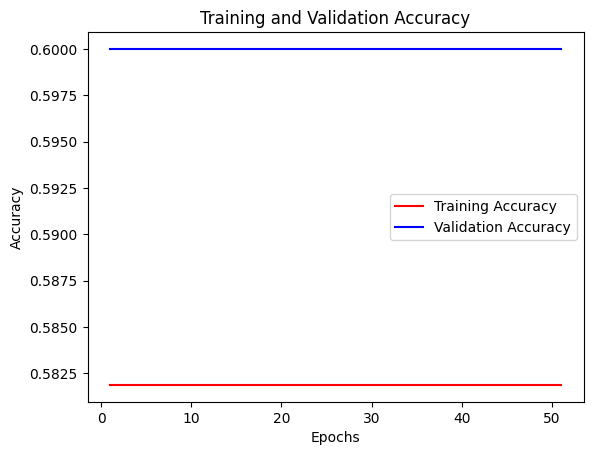

In [423]:
# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
# "r" is for solid red line
# let's use red for training consistenly across plots

plt.plot(epochs, acc, 'r', label='Training Accuracy')
# b is for "solid blue line"
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
# want loss to go down and accuracy to go up

In [424]:
# store the predictions
# if you don't round to a whole number (0 or 1), the confusion matrix won't work!
train_preds = np.round(model.predict(X_train_reshaped), 0)
test_preds = np.round(model.predict(X_test_reshaped), 0)

# found Nans in preds

# Replace np.nan and np.inf with 0 for all datasets
train_preds = np.nan_to_num(train_preds, nan=0, posinf=0, neginf=0)
test_preds = np.nan_to_num(test_preds, nan=0, posinf=0, neginf=0)


# Check again for NaN or infinity
print("NaN in train_preds:", np.isnan(train_preds).sum())
print("NaN in test_preds:", np.isnan(test_preds).sum())


print("Infinity in train_preds:", np.isinf(train_preds).sum())
print("Infinity in test_preds:", np.isinf(test_preds).sum())


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
NaN in train_preds: 0
NaN in test_preds: 0
Infinity in train_preds: 0
Infinity in test_preds: 0


In [425]:
# train results
trainResults = classification_report(y_train_ds_df, train_preds) # (actual, predicted)
# "don't forget to  use 'print' otherwise it looks goofy"
print("This is train: \n", trainResults)

This is train: 
               precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       462
         1.0       0.00      0.00      0.00       332

    accuracy                           0.58       794
   macro avg       0.29      0.50      0.37       794
weighted avg       0.34      0.58      0.43       794



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [426]:
# train confusion matrix
print("This is train: \n", confusion_matrix(y_train_ds_df, train_preds))

This is train: 
 [[462   0]
 [332   0]]


In [427]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.

tn, fp, fn, tp = confusion_matrix(y_train_ds_df, train_preds).ravel()
print("This is train:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is train:
TP: 0 - 0.0 %
TN: 462 - 58.19 %
FP: 0 - 0.0 %
FN: 332 - 41.81 %


In [428]:
# test results
testResults = classification_report(y_test_ds_df, test_preds)
# "don't forget to use 'print' otherwise it looks goofy"
print("This is test: \n", testResults)

This is test: 
               precision    recall  f1-score   support

         0.0       0.60      1.00      0.75       120
         1.0       0.00      0.00      0.00        80

    accuracy                           0.60       200
   macro avg       0.30      0.50      0.38       200
weighted avg       0.36      0.60      0.45       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [397]:
# test confusion matrix
print("This is test: \n", confusion_matrix(y_test_ds_df, test_preds))

# top left is TN true neg
# bottom left is FN false neg (actually 1's predicted to be 0's)
# top right is FP false pos (actually 0 predicted to be 1's)
# bottom right is TP true pos

This is test: 
 [[120   0]
 [ 80   0]]


In [398]:
# here are tp, tn, fp, fn
# The ravel() function returns a contiguous flattened array.
# This means it takes an array of any shape and returns a one-dimensional
# array containing all the elements of the original array.
# Useful when you need to work with a one-dimensional representation of
# an array, for example when using functions that only accept 1D arrays.


# here are tp, tn, fp, fn
tn, fp, fn, tp = confusion_matrix(y_test_ds_df, test_preds).ravel()
print("This is test:")
print("TP:", tp, "-", round(tp/(tp+tn+fp+fn)*100, 2),"%")
print("TN:", tn, "-", round(tn/(tp+tn+fp+fn)*100, 2),"%")
print("FP:", fp, "-", round(fp/(tp+tn+fp+fn)*100, 2),"%")
print("FN:", fn, "-", round(fn/(tp+tn+fp+fn)*100, 2),"%")

This is test:
TP: 0 - 0.0 %
TN: 120 - 60.0 %
FP: 0 - 0.0 %
FN: 80 - 40.0 %


# Interpretability and Discussion


Based on reviewing the data dictionary, performing initial EDA including correlation heat maps and generating other plots, I reduced the demographic features from 82 columns to 29. I thought it would be advisable to reduce the demographic data before modeling with the much larger 996 accelerometer parquet files to reduce complexity up front where possible.

Modeling with the reduced Kaggle train_df demographic dataset, with PCIAT features removed as well as non-numeric columns resulted in weighted F1 scores for the Baseline Model train and test of 71% and 67%, respectively. Some teams, I believe, had better baseline F1 scores, but without knowing which features were dropped, it would be an incomplete analysis/comparison. Given my Baseline Model's results, I saw that including even limited acceleromoeter data from the MinFC_withID dataset with the demographic data (Model #1), improved performance with F1 scores for train and test, 88% and 72%, respectively. The increase in the test F1 score from baseline 67% to 72% with accelerometer data is more important than the increase in the training F1s from baseline to Model #1, and based on the test F1 result, I continued modeling *with accelerometer data.  

I found that various "strategies" (1 layer, same number of hidden units as input features; 1 layer, 2,3..X hidden units as input features; >= 2 layers, same number of hidden units as input features; "info funnel", >= 2 Layers, halving hidden nodes) resulted in similar test F1 performance, ranging between 69-72%. Adding complexity to Models #2, #3, #4 and #5 did not improve test F1 scores, and in the case of Model #4,  adding layers with the same number of hidden nodes as input features decreased test F1.  Large gaps between train F1 and test F1 suggest that the model may be overfitting the training data - the model learns the details/noise in the training data so well that it doesn't generalize to unseen data in the test set. In this case, even though the model had a high train F1 (as in Model #4 info funnel where train F1 = 94%), it's not performing well on the test data, which means it may not generalize well to new or unseen data. A higher train F1 score alone doesn’t necessarily mean that the model is the best - we want our train F1 and test F1 to be close to each other.

My downsampled model had the worst F1 scores of all models (train F1 = 43% and test F1 = 45%) and I'm not sure why (and am running out of time to dig deeper). I tried increasing patience, and changing the number of layers, as I thought the model was not learning, given the horizontal (parallel) training and test accuracy curves. I also increased the model's learning rate from 0.001 to 0.01 - no change.

Examining basic demographic data, we see that preteen males are more impaired than not, and males are more impaired than females, generally. In the training sample, there were no unimpaired teen males or females. This result implies that while males are particularly at risk, impairment peaks for both males and females during the teen years. This could be explained by more limited internet usage in earlier years (more oversight, fewer technical options/devices available, etc). **Recommendations** to limit internet use during the preteen years as a basis for establishing "good practices" for the teenage years could be developed locally (school programs, parent alliances) or more broadly, such as policies to limit social media usage to those over 16 legislated recently for implementation next year in Australia (https://www.bbc.com/news/articles/c89vjj0lxx9o).


Examining accelerometer data along with demographic data did provide more intelligence. We see that when the activity intensity variable 'enmo' is lower, and BMI (body mass) is higher, there are more instances of impairment. For a given BMI, as activity intensity increases, impairment decreases (Plot #3). **Recommendations** to provide programs to increase physical activity, reduce body mass with more intense movement could track to less impairment. The accelerometer data seemed to track impairment better than just the activity level and fitness level variables in the demographic dataset, which was interestiung (and may support accelerometer usage for the study).

Reviewing accelerometer data over the weekday/weekend time periods, it was helpful to see ambient lighting increase and concommitant activity intensity increase on the weekends (for reasons we can't assert, but could hypothesize - more outdoor time, less structured indoor time). Impairment results were not so dissimilar that only "playing more outdoors" would be the recommendation, but **recommendations** could be developed to introduce more outdoor activities during the week. Indoors or outdoors, the key is to reduce usage to reduce impairment.

Activity intensity 'enmo' is a different kind of measurement than the X,Y, and Z motion variables (desscribed above). The data showed that lower values of even the absolute maximums associated with X,Y,Z show impairment (see the plots associated with Table 5). Higher absolute maximum values have fewer impairment observations. I interpreted this as activity intensity helped, but just moving through the X,Y and Z planes as best you could helped as well - as in, you don't need to run, walk fast if you can, with big strides. This supports **recommendations** for *any type of movement.

This study's findings are consistent with other studies' findings pertaining to at-risk young men. Recent studies indicate that young men, particularly in the U.S., are falling behind their female counterparts in several educational areas. According to Pew Research Center, women now outpace men in higher education completion, with a notable gap emerging in college enrollment and graduation rates. This trend has been attributed to a range of factors, including shifts in academic performance and social dynamics that favor female students in terms of academic achievement and college retention (https://www.pewresearch.org/topic/gender-lgbtq/education-gender/). Not to minimize the impact of social media on girls' physical and mental health, but boys particularly are falling behind. Some studies indicate that young people, (including males) may be especially vulnerable to overstimulation and even addiction due to constant engagement with digital content. This addiction-like behavior can contribute to further negative impacts on emotional health and lead to disengagement from offline activities, including physical exercise or face-to-face interactions (https://www.yalemedicine.org/news/social-media-teen-mental-health-a-parents-guide). We know that physical exercise has both physical and mental advantages, and **recommendations** to incorprate off-screen/in-person interaction/physical activity and connection need to be taken seriously. Impairment can become self-fulfilling, meaning, higher BMIs and low activity intensity may make kids disinclined to try to be active, and thus default to internet use.

In summary, the time series accelerometer data was helpful (when gathered) to assess true physical activity over time periods. All teens (male/female) are at risk of being impaired but young men are particularly at risk. Recommendations for actions to mitigate impairment should focus on decreasing internet usage overall and increasing physical activity across all days of the week.


# Conclusions

1. My first thought is about completeness of data. I expected the Kaggle competition accelerometer data to be alot more robust. I did find it provided some intelligence about activity (movement and intensity) and some other feature relationships, but it was limited to only the records/observations with complete data.
2. I feel that having a gameplan to start to model with the different "strategies" we were taught helped. I still found myself trying to decide which strategy to focus on, and would have liked to have then focused more on trying to TUNE a particular strategy to dig deeper there.
3. I was disappointed that my downsampled LSTM models didn't perform as well as the models using demo data plus MinFC_withID - I had high hopes for the downasmpled data. I don't think it was a problem with lack of
data/downsampling - I think if I could have played with the LSTM models more, perhaps I could have cracked what was going on there. I just ran out of time over the holiday.
4. It was very helpful to get exposure to other tools such as TSFresh and downsampling. My initial reaction to downsampling was a bit of, well, that's cheating, but that's an emotional rather than a statistical response. When I saw how long it took to downsample the parquet files, understanding how to chunk out the processing, pick a downsample size and specify timeout will be helpful in the future.
5. For this project, I needed to think more about the logistics/coding for storing files on MyDrive to decrease run times. That meant I needed to keep track of what was where, and which code could be commented out second time in, versus which code needed to be rerun each time.
